In [1]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt
        
    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin
    

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [2]:
# Cart pole system parameters
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

# Linearized system specification:
n, m = 6, 2                                                         # Number of states, number of control inputs
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [3]:
q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 100                                                     # Number of trajectories to execute, data collection
noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust]) - hover_thrust    # Actuation constraint, trajectory generation
umin = np.array([0., 0.]) - hover_thrust
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = 'examples/planar_quad_models'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
save_figures = True
dropbox_folder = '/Users/carlaxelfolkestad/Dropbox/Apps/Overleaf/Koopman NMPC (ICRA21)/'

[-1.05167985  0.17915793 -0.2965979  -0.94936112  0.98033777  0.30802426]
[-1.06110884  0.18868304 -0.29350901 -0.93645843  0.92469114  0.30975335]
[-1.07028361  0.19806986 -0.29037324 -0.89856097  0.95269115  0.31740024]
[-1.07910776  0.20764866 -0.28723391 -0.86632679  0.96308578  0.31046724]
[-1.08763594  0.21724801 -0.28430398 -0.83935452  0.95679717  0.27551757]
[-1.09592195  0.22669467 -0.281769   -0.81787898  0.93254576  0.23147901]
[-1.10391582  0.23617032 -0.27946754 -0.78094309  0.96259684  0.22881245]
[-1.11155838  0.24588893 -0.27721861 -0.74761231  0.9811383   0.22097441]
[-1.11888348  0.25574203 -0.27506398 -0.717446    0.9894934   0.20995123]
[-1.12588704  0.26575362 -0.27303982 -0.68330697  1.01283628  0.19488135]
[-1.13256458  0.27594821 -0.27123364 -0.65223549  1.02608992  0.16635395]
[-1.13892352  0.28630747 -0.26966989 -0.6195833   1.04577148  0.14639546]
[-1.14503137  0.29659361 -0.26817926 -0.60200285  1.01145994  0.15173054]
[-1.15098855  0.3064469  -0.26661646 -

[-0.49886455  1.00593898  0.0386311   1.2264647   0.04021712  0.56542644]
[-0.48661245  1.0061604   0.04410595  1.2238987   0.0040648   0.52954321]
[-0.47438596  1.0059827   0.04942183  1.22135182 -0.03960831  0.53363457]
[-0.4621849   1.00533918  0.0548464   1.21881593 -0.08909701  0.55127918]
[-0.45001838  1.0043389   0.06047234  1.21441689 -0.110963    0.57390894]
[-0.43792461  1.00354541  0.0662887   1.20418084 -0.0477449   0.58936239]
[-0.42592773  1.00323468  0.07225754  1.19506304 -0.01441062  0.60440493]
[-0.41402094  1.0031892   0.07836813  1.18617456  0.00530434  0.61771329]
[-0.40220107  1.0032712   0.08461556  1.17769133  0.01108793  0.63177226]
[-0.39047584  1.00348603  0.09095399  1.16722911  0.03186668  0.6359145 ]
[-0.37883613  1.00366331  0.09721735  1.16063989  0.0035822   0.616757  ]
[-0.36728409  1.00375445  0.1033087   1.14965762  0.01463562  0.60151266]
[-0.35582714  1.00378523  0.1092554   1.14165798 -0.00848807  0.58782869]
[-0.3444531   1.00359068  0.11521318  

[ 0.27268605  0.83380466  0.40771753 -0.25013732  0.46289989 -0.21802791]
[ 0.27002739  0.83830804  0.40540664 -0.28156481  0.43778936 -0.24414926]
[ 0.26697824  0.84274076  0.40289705 -0.32822084  0.44877286 -0.25777005]
[ 0.26349481  0.84721125  0.40022598 -0.36842305  0.44534348 -0.27644317]
[ 0.25958777  0.85170223  0.39733974 -0.41293435  0.45287489 -0.30080588]
[ 0.25535285  0.85599275  0.39428299 -0.43402246  0.40524013 -0.3105436 ]
[ 0.25086726  0.85990507  0.39116897 -0.46306008  0.37723752 -0.31225944]
[ 0.2460501   0.86364064  0.388044   -0.50032554  0.3698971  -0.31273409]
[ 0.24074596  0.86758734  0.38499213 -0.56042593  0.41947268 -0.29764065]
[ 0.23498154  0.87168799  0.38182239 -0.59241644  0.40067362 -0.33630756]
[ 0.22888817  0.87562703  0.37830469 -0.62620767  0.38715398 -0.36723259]
[ 0.22243495  0.87949074  0.37458023 -0.66437739  0.38561198 -0.37766013]
[ 0.21560003  0.88334435  0.37080865 -0.7025442   0.38513399 -0.37665568]
[ 0.20843417  0.88706768  0.36717797 -

[ 1.01386568 -0.93814738  0.52364133  0.26548398 -0.78809521 -0.00644472]
[ 1.01630353 -0.94614298  0.52331727  0.22209046 -0.8110222  -0.05836616]
[ 1.01823048 -0.954234    0.52265346  0.16331204 -0.80717377 -0.07439776]
[ 1.01962043 -0.96237385  0.52175176  0.11468948 -0.82078995 -0.10594136]
[ 1.02050308 -0.97061219  0.52047009  0.06186027 -0.82686698 -0.15039281]
[ 1.02084536 -0.97888869  0.51879285  0.00662349 -0.8284179  -0.18505445]
[ 1.02071539 -0.98731922  0.51675829 -0.03259375 -0.85767376 -0.22185802]
[ 1.0199969  -0.99569445  0.51447502 -0.11105248 -0.81734248 -0.23479635]
[ 1.01858791 -1.00382935  0.51194526 -0.17070054 -0.80961236 -0.27115434]
[ 1.01655805 -1.01184017  0.50916253 -0.23521887 -0.79252198 -0.28539353]
[ 1.01382557 -1.01957312  0.50617241 -0.3112086  -0.7540309  -0.31263016]
[ 1.01047195 -1.02716713  0.50289472 -0.35946674 -0.76474419 -0.34290785]
[ 1.00660426 -1.03480733  0.49928172 -0.41401257 -0.76326369 -0.37969131]
[ 1.00218447 -1.04241609  0.49531524 -

[ 0.10544104  0.59518941  0.20543142  1.4688325  -1.40331798  0.1160225 ]
[ 0.11996444  0.58145564  0.20667516  1.43581478 -1.34344247  0.13272575]
[ 0.13421681  0.56803419  0.20789584  1.41463733 -1.34085325  0.1114103 ]
[ 0.14822011  0.55481214  0.2089886   1.38599939 -1.30356087  0.10714174]
[ 0.16195479  0.54187591  0.21000654  1.36091559 -1.28368972  0.09644611]
[ 0.17541079  0.5292659   0.21102393  1.3302594  -1.23831653  0.10703225]
[ 0.18862102  0.51682272  0.21189231  1.31177501 -1.25032353  0.06664213]
[ 0.20158783  0.50452991  0.21253104  1.28157142 -1.20824195  0.06110443]
[ 0.21427797  0.49253836  0.21306644  1.25644708 -1.19007041  0.04597547]
[ 0.22677802  0.48044472  0.21341586  1.24355931 -1.22865699  0.0239097 ]
[ 0.23913369  0.46803635  0.21354896  1.22757227 -1.25301752  0.00270963]
[ 0.25131298  0.45546036  0.21354602  1.20828562 -1.2621812  -0.00329787]
[ 0.26317234  0.44337876  0.21344541  1.16359114 -1.15413683 -0.01682341]
[ 0.27467352  0.43196867  0.213294    

[ 1.85259794 -0.35089422  0.31623151  0.81678348  1.40980443  0.17282135]
[ 1.86080033 -0.33739208  0.31792625  0.82370026  1.29062679  0.16612629]
[ 1.86893505 -0.32466608  0.31952615  0.80322798  1.25456632  0.15385336]
[ 1.87687889 -0.31234407  0.32093157  0.78552779  1.2098335   0.12723122]
[ 1.88456612 -0.3002314   0.32216095  0.75189711  1.21269187  0.11864414]
[ 1.89194893 -0.28818758  0.32330113  0.72464907  1.19606751  0.10939128]
[ 1.89895117 -0.27598926  0.32426576  0.67577587  1.24358921  0.08353538]
[ 1.90548384 -0.26337481  0.32504029  0.63074042  1.27929521  0.07137164]
[ 1.91158231 -0.25045286  0.32575399  0.58893956  1.30508996  0.07136715]
[ 1.91738898 -0.23764774  0.32641048  0.57238953  1.25593081  0.05993213]
[ 1.92292385 -0.22502091  0.32704311  0.53457192  1.26943146  0.06659204]
[ 1.92815434 -0.21247766  0.32763418  0.51152009  1.23921725  0.05162269]
[ 1.93308829 -0.20004297  0.32804766  0.47526141  1.24771859  0.03107317]
[ 1.93773767 -0.18775307  0.32837139  

[-0.19306295 -0.48684974 -0.09387513  1.99462777  0.02975921  0.48520893]
[-0.17304989 -0.48632092 -0.08908519  2.00786896  0.0760155   0.47278039]
[-0.15293056 -0.48558802 -0.08429139  2.01592237  0.07057169  0.48597821]
[-0.13272639 -0.48483028 -0.07937146  2.02482291  0.08098222  0.49800952]
[-0.11245404 -0.48420127 -0.07448666  2.02959656  0.04482516  0.47895003]
[-0.09212306 -0.48376387 -0.06966793  2.03652375  0.04265995  0.48479552]
[-0.07170675 -0.48307879 -0.06496531  2.04661971  0.09436472  0.45572767]
[-0.05122044 -0.48230916 -0.06046884  2.05059422  0.0595639   0.4435667 ]
[-0.03065813 -0.48124955 -0.05604312  2.06172769  0.15236586  0.4415772 ]
[-0.01002397 -0.47990756 -0.0518465   2.0650607   0.11603349  0.39774824]
[ 0.01065227 -0.47873075 -0.04793978  2.07012281  0.11933241  0.38359519]
[ 0.03137761 -0.4775117  -0.04416481  2.07487997  0.12448109  0.37139934]
[ 0.05214696 -0.4762791  -0.04043776  2.07892918  0.12204219  0.3740095 ]
[ 0.07295495 -0.47507214 -0.0366998   

[-1.09337936 -1.20237029  0.12842278 -0.50199699 -0.68632808 -0.20913281]
[-1.09846349 -1.20922444  0.12628009 -0.51479348 -0.68449699 -0.21940485]
[-1.10366285 -1.21615245  0.12407358 -0.52504879 -0.70110013 -0.22189768]
[-1.10897546 -1.22315268  0.12174326 -0.53743561 -0.69894252 -0.24416598]
[-1.11443015 -1.22997164  0.1193267  -0.55344751 -0.66484155 -0.23914674]
[-1.12003308 -1.23653577  0.11705402 -0.56709623 -0.64797951 -0.21538916]
[-1.12578255 -1.24283423  0.11486653 -0.58274904 -0.61170742 -0.22210762]
[-1.13167545 -1.24887116  0.11264348 -0.5957887  -0.5956733  -0.22250288]
[-1.13770552 -1.25467608  0.11040966 -0.61017617 -0.56530539 -0.22426149]
[-1.14387696 -1.26018667  0.10806206 -0.62406265 -0.53680803 -0.24525797]
[-1.1501812  -1.26545449  0.10571367 -0.63673851 -0.51675044 -0.22441957]
[-1.15662556 -1.27038191  0.10356456 -0.6520824  -0.46872743 -0.20540426]
[-1.1631496  -1.27552852  0.10148368 -0.65272372 -0.56059434 -0.21077117]
[-1.16971776 -1.28122033  0.09944162 -

[ 0.99717196 -1.01976575  0.22976116 -1.87068919 -0.93476282 -0.77096055]
[ 0.97833125 -1.02902498  0.2219519  -1.89730268 -0.91704849 -0.790891  ]
[ 0.95915908 -1.03779246  0.21389671 -1.93689076 -0.83639422 -0.82014704]
[ 0.93965175 -1.04600111  0.20566362 -1.96439878 -0.80529892 -0.82647057]
[ 0.91988911 -1.05396796  0.19748588 -1.98797111 -0.78803771 -0.80907689]
[ 0.89991085 -1.06183929  0.18935452 -2.00754598 -0.78620267 -0.81719592]
[ 0.87976742 -1.06983182  0.18099374 -2.02103886 -0.81228403 -0.85495901]
[ 0.85945163 -1.07785973  0.17241838 -2.04195267 -0.79326769 -0.86011466]
[ 0.83893295 -1.08570377  0.16387419 -2.06161783 -0.77551265 -0.8487217 ]
[ 0.8182815  -1.09373225  0.15540843 -2.06861173 -0.83017434 -0.8444314 ]
[ 0.79751995 -1.10203398  0.14690934 -2.08355904 -0.83014991 -0.85538582]
[ 0.77666773 -1.11071137  0.13847562 -2.08685244 -0.90532312 -0.83135808]
[ 0.7556801  -1.11938287  0.13021859 -2.11043347 -0.82894483 -0.82004767]
[ 0.73452752 -1.12778648  0.12213866 -

[ 1.39085208 -1.06429653  0.23388447 -1.63252822  0.43546722 -0.48571026]
[ 1.37444756 -1.06009736  0.22906765 -1.64832281  0.40438037 -0.4776523 ]
[ 1.35781098 -1.05588156  0.22420631 -1.67888458  0.43880406 -0.49461651]
[ 1.34091265 -1.05150018  0.21911963 -1.70069928  0.43749019 -0.52271875]
[ 1.32382471 -1.04724923  0.2138144  -1.71682527  0.4127147  -0.53832755]
[ 1.30659903 -1.04334579  0.20845754 -1.72826326  0.36798204 -0.53304526]
[ 1.28919508 -1.03957782  0.20300351 -1.75242129  0.38563433 -0.5577608 ]
[ 1.27157247 -1.03572943  0.19745451 -1.77201077  0.38406109 -0.55203868]
[ 1.25375279 -1.03187681  0.19195563 -1.79183327  0.38648103 -0.54773687]
[ 1.23582975 -1.02847807  0.18653108 -1.79276952  0.29326938 -0.53717407]
[ 1.21780357 -1.02550882  0.18112488 -1.81237205  0.30059731 -0.54406616]
[ 1.19955753 -1.0223185   0.17570986 -1.836715    0.33748805 -0.53893752]
[ 1.18115191 -1.01921517  0.17038965 -1.8443701   0.28318496 -0.52510363]
[ 1.16263941 -1.0164697   0.16507032 -

[ 1.58189398  0.28978492  0.32295301 -1.4880714   1.80723059 -0.69786884]
[ 1.56688631  0.30774905  0.31590439 -1.51337318  1.78562454 -0.71185592]
[ 1.55159609  0.32559741  0.30882337 -1.54455568  1.78408599 -0.70434853]
[ 1.53602758  0.34333639  0.30155017 -1.56905335  1.76373896 -0.75029123]
[ 1.52017667  0.36100351  0.29395464 -1.60099634  1.76972434 -0.7688145 ]
[ 1.50402577  0.37868014  0.28625546 -1.62906215  1.76563796 -0.77102039]
[ 1.48766759  0.39607776  0.27848049 -1.64251464  1.71390482 -0.78397453]
[ 1.47112138  0.41315393  0.2707334  -1.66661599  1.70135931 -0.76544249]
[ 1.45442613  0.4297829   0.26299221 -1.67240728  1.62444184 -0.78279593]
[ 1.43753045  0.44618089  0.25518652 -1.70656058  1.65520144 -0.77834255]
[ 1.42035381  0.4626726   0.24734227 -1.72865429  1.64316963 -0.79050673]
[ 1.40297183  0.47899597  0.23951929 -1.74764248  1.62152965 -0.77409025]
[ 1.3854047   0.49509634  0.23200848 -1.76568944  1.59856555 -0.72807248]
[ 1.36765202  0.5110014   0.22468047 -

[-1.31344543 -0.1373806  -0.45466346 -0.74686212  0.2985722  -0.00916324]
[-1.32066233 -0.13437042 -0.45458771 -0.6965182   0.30346557  0.02431157]
[-1.32746731 -0.13149837 -0.4541054  -0.66448309  0.27094724  0.07215122]
[-1.33398747 -0.12902384 -0.45338534 -0.63955583  0.22396095  0.07186042]
[-1.34026588 -0.12703413 -0.45249254 -0.61613262  0.17398547  0.10669942]
[-1.34612603 -0.12516466 -0.45136354 -0.55592107  0.19991843  0.11910208]
[-1.35149429 -0.12326165 -0.45007057 -0.5177491   0.18069255  0.13949139]
[-1.35650449 -0.12159854 -0.44861971 -0.48430647  0.15193831  0.15068013]
[-1.3610394  -0.11992865 -0.44712188 -0.42270801  0.1820536   0.14888606]
[-1.36508981 -0.1182297  -0.44557337 -0.38739277  0.15774678  0.16081546]
[-1.36876616 -0.11672845 -0.44385046 -0.34790041  0.14251414  0.18376706]
[-1.3719874  -0.11525084 -0.44195678 -0.29638199  0.15302399  0.19496846]
[-1.37473586 -0.11375516 -0.43983369 -0.25334203  0.14612774  0.22965053]
[-1.37713425 -0.11249687 -0.43756116 -

[ 0.11291873  1.13289732 -0.17775504 -0.43976265  0.06661794  0.07305259]
[ 0.10860179  1.13352275 -0.17700795 -0.42363684  0.05847135  0.07636483]
[ 0.10447061  1.13420585 -0.17627148 -0.40261369  0.07815113  0.07092888]
[ 0.10057907  1.13525358 -0.17551774 -0.37571344  0.13139807  0.07982072]
[ 0.09689615  1.13649622 -0.17463224 -0.36088334  0.1171309   0.09727854]
[ 0.0933465   1.13751313 -0.17364696 -0.34905725  0.08625372  0.09977791]
[ 0.08994914  1.13841758 -0.17269959 -0.33043127  0.09463858  0.08969646]
[ 0.08676151  1.13954352 -0.17183332 -0.30711456  0.13055365  0.08355713]
[ 0.08371995  1.1405293  -0.17091581 -0.30120362  0.06660392  0.09994524]
[ 0.08081087  1.14130248 -0.17004236 -0.28062903  0.08803438  0.07474333]
[ 0.07806748  1.14205926 -0.1691716  -0.26805935  0.06332395  0.09940995]
[ 0.07545366  1.14259373 -0.16808632 -0.25471982  0.04357131  0.11764542]
[ 0.07298878  1.14302529 -0.16686016 -0.23827436  0.04274416  0.1275857 ]
[ 0.070691    1.14346798 -0.16555159 -

[ 0.20583227  0.29842266 -0.13983016 -0.37063434 -0.64281523  0.35374784]
[ 0.20220949  0.2921029  -0.13621008 -0.35399345 -0.6211253   0.37026917]
[ 0.19870322  0.28564903 -0.13253239 -0.3472911  -0.66964493  0.36526901]
[ 0.19528717  0.27889263 -0.12874586 -0.33597449 -0.68162826  0.39203543]
[ 0.19197317  0.27194295 -0.12469009 -0.3268732  -0.70830277  0.41911867]
[ 0.18875599  0.26478539 -0.12052174 -0.3166211  -0.72320126  0.41455225]
[ 0.18567034  0.25773592 -0.11632313 -0.30060288 -0.68668089  0.42516892]
[ 0.1826863   0.25056914 -0.11207142 -0.29623203 -0.74667283  0.42517463]
[ 0.17980059  0.24330149 -0.1077932  -0.28100749 -0.70684664  0.43046894]
[ 0.17706314  0.23642285 -0.1033604  -0.26658432 -0.66886929  0.45609004]
[ 0.1744771   0.23002466 -0.09876398 -0.25074238 -0.61075814  0.46319506]
[ 0.17201531  0.22389448 -0.09414356 -0.24168754 -0.61527004  0.46088761]
[ 0.16964103  0.21770994 -0.08950914 -0.23323945 -0.62163235  0.46599622]
[ 0.16738631  0.21188399 -0.08482176 -

[-1.33406566 -0.26893415 -0.33982511 -0.18281619  0.62732955  0.39737809]
[-1.33576285 -0.2627793  -0.3356978  -0.15667328  0.60365798  0.42808304]
[-1.33717097 -0.25677654 -0.33148606 -0.12501475  0.59691661  0.41426678]
[-1.33832141 -0.25100687 -0.32737841 -0.10511194  0.55703167  0.40726277]
[-1.33919589 -0.24540457 -0.32321885 -0.06985774  0.56345161  0.42464962]
[-1.33974248 -0.23980466 -0.31888284 -0.03952651  0.55655342  0.44255133]
[-1.33995588 -0.23417605 -0.31456794 -0.00323235  0.56919457  0.42042848]
[-1.33979689 -0.2283838  -0.31036708  0.03494761  0.5892806   0.41974378]
[-1.33934184 -0.22265071 -0.30606559  0.05601581  0.55735351  0.44055431]
[-1.33862071 -0.21705566 -0.30168259  0.08813499  0.56168024  0.43604549]
[-1.3375304  -0.2112544  -0.29730082  0.12982743  0.59860191  0.44030961]
[-1.33601002 -0.20503012 -0.29290562  0.17414246  0.64628579  0.43872946]
[-1.33414987 -0.19866194 -0.28833294  0.19782802  0.62736966  0.47580744]
[-1.33201661 -0.19235318 -0.2836192   

[ 0.80905852  0.40325656  0.37277506  0.23071625  0.10922503 -0.18685404]
[ 0.81109844  0.404543    0.37082445  0.17731057  0.14807992 -0.20326861]
[ 0.81269202  0.40599598  0.36867327  0.14143919  0.14252808 -0.22696714]
[ 0.8138903   0.40749143  0.36628282  0.09826197  0.15658026 -0.25112219]
[ 0.81470325  0.40901019  0.36365588  0.06436696  0.14718533 -0.27426632]
[ 0.81516235  0.41047784  0.36090798  0.02749814  0.14636163 -0.27531401]
[ 8.15297972e-01  4.11821213e-01  3.58160260e-01 -3.40650494e-04
  1.22326572e-01 -2.74229741e-01]
[ 0.81514814  0.41294625  0.35547949 -0.02959039  0.10269358 -0.26192377]
[ 0.81467544  0.41396022  0.35278124 -0.06490797  0.10011588 -0.27772731]
[ 0.81387223  0.41489067  0.35005581 -0.09569485  0.08598915 -0.26735912]
[ 0.81269895  0.41585422  0.34743093 -0.13890864  0.10674033 -0.25761565]
[ 0.81106325  0.41711401  0.34478259 -0.1881709   0.14523848 -0.27205235]
[ 0.80900229  0.41857646  0.34203353 -0.22397543  0.14726822 -0.2777597 ]
[ 0.80655511 

[-1.71153484 -0.3380049  -0.43281934  0.68541895  2.00005438  0.41441455]
[-1.7045365  -0.31818169 -0.42840293  0.71420372  1.96460954  0.46886686]
[-1.69710085 -0.29838044 -0.42350395  0.77282168  1.99568809  0.51092921]
[-1.68909243 -0.27828958 -0.4182028   0.82875176  2.02253386  0.54930059]
[-1.6806405  -0.25818294 -0.41259408  0.86156465  1.99882473  0.57244454]
[-1.67183024 -0.23823826 -0.40681709  0.9004      1.99014702  0.58295313]
[-1.66257493 -0.21824085 -0.40091975  0.95054748  2.00938565  0.59651432]
[-1.65275504 -0.19789156 -0.39484347  1.01327983  2.0605346   0.61874213]
[-1.64233738 -0.17708916 -0.38861937  1.07010884  2.10000598  0.6260772 ]
[-1.63148082 -0.1561976  -0.38237503  1.10112429  2.07833676  0.62279121]
[-1.62033241 -0.13556163 -0.37623716  1.12848709  2.04888558  0.60478418]
[-1.60892416 -0.11524912 -0.37020246  1.15309946  2.01364127  0.60215411]
[-1.59722461 -0.09516628 -0.36413254  1.1867225   2.00296073  0.61183091]
[-1.5852408  -0.07531938 -0.35791735  

[-0.15880527 -0.80190666  0.33341263  0.29993247 -0.05024633  0.13187525]
[-0.15586451 -0.80273079  0.33480496  0.28821241 -0.11458149  0.14659071]
[-0.15316812 -0.80383406  0.3362777   0.25103879 -0.10608341  0.14795735]
[-0.15088021 -0.80474993  0.33774653  0.20651159 -0.07710106  0.14580892]
[-0.14886056 -0.80588219  0.33905909  0.19741405 -0.14935345  0.11670145]
[-0.14709112 -0.80728651  0.34020966  0.15645071 -0.13151792  0.11341271]
[-0.14584128 -0.80820429  0.34132033  0.09348481 -0.05205023  0.10872117]
[-0.1450107  -0.80892211  0.34241972  0.07262068 -0.09151676  0.11115682]
[-0.14448216 -0.80977391  0.34357501  0.03306596 -0.07885169  0.11990129]
[-0.14432611 -0.8105655   0.3448411  -0.00187696 -0.07947266  0.13331683]
[-0.14451549 -0.81137639  0.346135   -0.03601974 -0.08271345  0.12546335]
[-0.14504834 -0.81221597  0.34749186 -0.07057102 -0.08521006  0.14590872]
[-0.14606146 -0.81271111  0.34898371 -0.13209546 -0.01383366  0.15246229]
[-0.14753348 -0.81292545  0.35043855 -

[-0.65941173 -0.07618155 -0.02921311  0.32899377  0.16402342 -0.16090803]
[-0.65610109 -0.07433632 -0.03087105  0.33317268  0.20502106 -0.17068042]
[-0.65274574 -0.07202583 -0.03262245  0.3379401   0.25707617 -0.17959964]
[-0.64935045 -0.0694676  -0.03454238  0.34114952  0.25456745 -0.20438504]
[-0.64592824 -0.06710826 -0.0365753   0.34331368  0.2173002  -0.20219968]
[-0.64248287 -0.06509746 -0.03858811  0.34578254  0.18485972 -0.20036261]
[-0.63900678 -0.06327432 -0.0404959   0.34946365  0.1797673  -0.18119565]
[-0.63548759 -0.06136967 -0.04215008  0.35440748  0.20116175 -0.14963874]
[-0.63192107 -0.05932214 -0.04346781  0.35892032  0.20834222 -0.11390907]
[-0.62832076 -0.05747613 -0.04468455  0.36115216  0.16086014 -0.12943728]
[-0.62469278 -0.05599364 -0.04599846  0.36445847  0.13563564 -0.13334561]
[-0.62103363 -0.05481427 -0.04729996  0.36738593  0.10023758 -0.12695405]
[-0.61732473 -0.05356888 -0.04863388  0.37442661  0.14883998 -0.13983066]
[-0.61355268 -0.05200553 -0.05000755  

[-0.46981589 -0.21259915  0.17486578  1.1603917  -0.71151322  0.63965058]
[-0.45833102 -0.21953918  0.18116155  1.13644305 -0.67651744  0.6195021 ]
[-0.44705327 -0.22632712  0.18743225  1.11900963 -0.68109011  0.63463815]
[-0.43594066 -0.23322462  0.19370824  1.10342817 -0.69842513  0.62056076]
[-0.42499715 -0.24024163  0.19985819  1.08517978 -0.70499618  0.6094298 ]
[-0.41424025 -0.24731841  0.20591402  1.06610547 -0.71037783  0.60173638]
[-0.40368631 -0.25440497  0.21191018  1.0445819  -0.7069559   0.59749495]
[-0.39332554 -0.2615735   0.21792093  1.02749299 -0.72676713  0.60465415]
[-0.38313706 -0.26894493  0.22387954  1.01012622 -0.74753725  0.58706928]
[-0.37314824 -0.27642139  0.2296386   0.98754501 -0.74777589  0.56474242]
[-0.36338146 -0.28392866  0.23519807  0.96572559 -0.75369848  0.54715168]
[-0.35399384 -0.29083997  0.24070783  0.91159369 -0.62861225  0.55479962]
[-0.34498788 -0.29717211  0.24626539  0.88951613 -0.63783805  0.55671322]
[-0.33618741 -0.30366718  0.25177098  

[-0.03351058 -0.3807334   0.20877928  0.54961705 -0.98772451  0.33082461]
[-0.02815813 -0.39042638  0.21188155  0.52080483 -0.95088772  0.28963001]
[-0.02306745 -0.39988262  0.21469681  0.49727879 -0.94037138  0.27342159]
[-0.0181987  -0.40930185  0.21751576  0.47642725 -0.9434843   0.29036895]
[-0.01353267 -0.41878475  0.22050712  0.45673493 -0.95310583  0.30790328]
[-0.00902309 -0.42854979  0.2235761   0.44515346 -0.99990726  0.30589312]
[-0.00474563 -0.43827747  0.22673725  0.41025978 -0.94564797  0.32633711]
[-6.94117874e-04 -4.48004098e-01  2.29975166e-01  4.00018306e-01
 -9.99682430e-01  3.21245090e-01]
[ 0.0031729  -0.45792535  0.23316445  0.37332546 -0.9845831   0.3166118 ]
[ 0.00681068 -0.46786152  0.23636326  0.35418662 -1.00266059  0.32315109]
[ 0.01020991 -0.4777892   0.2395133   0.32559753 -0.9828903   0.30685528]
[ 0.01335186 -0.48764372  0.2425241   0.30274614 -0.98802548  0.29530451]
[ 0.01615966 -0.49713034  0.24550684  0.25872633 -0.90931892  0.30124358]
[ 0.01858008 

[-1.00981899  0.51316549  0.22535575 -0.10620539  0.98810951 -0.01094317]
[-1.01093298  0.52278264  0.22536929 -0.11659253  0.93532161  0.01365057]
[-1.01223397e+00  5.32234369e-01  2.25433894e-01 -1.43605785e-01
  9.55023626e-01 -7.30028813e-04]
[-1.01377637  0.54175783  0.22540842 -0.16487418  0.94966837 -0.00436548]
[-1.01551464  0.55115446  0.22536391 -0.18277894  0.92965896 -0.00453681]
[-1.01744367  0.56040222  0.22524332 -0.20302587  0.91989323 -0.01958015]
[-1.01954115  0.56940409  0.22506912 -0.21646758  0.8804814  -0.01526068]
[-1.02178766  0.57807597  0.22487482 -0.23283349  0.85389413 -0.02359808]
[-1.02425035  0.58671199  0.22455032 -0.25969675  0.87331214 -0.04130143]
[-1.02692989  0.59531636  0.22412026 -0.27620554  0.84756232 -0.04471079]
[-1.02978276  0.60370019  0.22367143 -0.29436411  0.82920521 -0.04505677]
[-1.03277404  0.61171134  0.22307463 -0.3038879   0.77302528 -0.07430262]
[-1.03588752  0.61928032  0.2223286  -0.31879946  0.74077207 -0.07490367]
[-1.03911073 

[ 0.46588636 -1.54989991  0.09140506 -2.18729902 -0.57422718 -0.73980495]
[ 0.44396929 -1.55563836  0.08401394 -2.19599345 -0.57345263 -0.73841929]
[ 0.42196239 -1.56128864  0.07656417 -2.20524477 -0.55659087 -0.7515341 ]
[ 0.39985648 -1.56662471  0.06911966 -2.21575667 -0.51061164 -0.7373687 ]
[ 0.37768356 -1.57199137  0.06184673 -2.21877212 -0.56271643 -0.71721686]
[ 0.35547497 -1.5777584   0.05460061 -2.22286092 -0.59068499 -0.7320076 ]
[ 0.33321754 -1.58360391  0.04743311 -2.22849403 -0.57840904 -0.70149315]
[ 0.31090958 -1.5893688   0.04059573 -2.23298093 -0.57456472 -0.66598253]
[ 0.28855915 -1.59506821  0.03406739 -2.23698806 -0.56531244 -0.63968594]
[ 0.26616071 -1.60031669  0.02748844 -2.24250558 -0.48437701 -0.67610302]
[ 0.2437254  -1.60524496  0.02081694 -2.24446597 -0.50127612 -0.65819727]
[ 0.22126474 -1.60989017  0.01433585 -2.24747974 -0.42776234 -0.63802096]
[ 0.19878262 -1.61405815  0.0079483  -2.24881733 -0.40583226 -0.63948908]
[ 1.76290324e-01 -1.61790024e+00  1.62

[-0.27683198  1.74564771 -0.05289075  0.61820078  0.16770648  0.28771001]
[-0.27063046  1.7472098  -0.04987161  0.6220651   0.14471449  0.31611799]
[-0.26439875  1.74839278 -0.04674068  0.62425327  0.0918819   0.31006867]
[-0.25812381  1.74952926 -0.04377027  0.63066433  0.13541687  0.28401327]
[-0.25179232  1.75097303 -0.04082448  0.6355768   0.15334063  0.30514364]
[-0.24542941  1.75219541 -0.03775976  0.63698799  0.09113539  0.30780102]
[-0.23903222  1.75335887 -0.03481616  0.64237665  0.14155925  0.28092009]
[-0.23259709  1.75461925 -0.03194771  0.64461667  0.11051732  0.29276973]
[-0.22615114  1.755227   -0.0290714   0.64457447  0.01103392  0.28249105]
[-0.21969775  1.75511857 -0.02623759  0.64607782 -0.03272093  0.28427242]
[-0.21322001  1.75497127 -0.02346491  0.64940912  0.0032641   0.27026223]
[-0.20671439  1.75502382 -0.02082248  0.65166894  0.00724627  0.25822432]
[-0.20018409  1.75528821 -0.01811756  0.65432947  0.0456333   0.28276048]
[-0.19363692  1.7554796  -0.01535292  

[ 1.77464293  0.21189159  0.21709965 -0.16272096 -1.61760867 -0.15908602]
[ 1.77293592  0.1955877   0.21549423 -0.17866147 -1.64316508 -0.16199861]
[ 1.77105373  0.17910332  0.21383967 -0.19775225 -1.65370571 -0.16891365]
[ 1.76895709  0.1626258   0.21215238 -0.22154564 -1.64179181 -0.16854404]
[ 1.76663864  0.14619685  0.21045019 -0.24211648 -1.6439932  -0.17189344]
[ 1.76411379  0.12975322  0.20860991 -0.26282402 -1.64472492 -0.19616207]
[ 1.76137433  0.1133426   0.20651613 -0.28503003 -1.6373928  -0.2225953 ]
[ 1.75835468  0.09728953  0.20425547 -0.31883871 -1.57320806 -0.22953623]
[ 1.75499523  0.081896    0.20195272 -0.35298928 -1.50548434 -0.23101332]
[ 1.75130929  0.06711587  0.19952675 -0.38413594 -1.4505298  -0.25418116]
[ 1.74734246  0.05274337  0.19677625 -0.40917281 -1.42395815 -0.29591877]
[ 1.74312613  0.03864158  0.19372896 -0.43402878 -1.3963881  -0.31353882]
[ 1.7386606   0.02482918  0.19053609 -0.45901016 -1.36607688 -0.32503501]
[ 1.73409068  0.01057269  0.18728829 -

[ 0.90034439 -0.38260463  0.37717443  0.95713934  0.45306031  0.30305105]
[ 0.90980595 -0.37828808  0.38014605  0.93514548  0.41023911  0.2912731 ]
[ 0.91909397 -0.37451787  0.38317408  0.92244101  0.3437961   0.31433355]
[ 0.92806716 -0.37094909  0.38639134  0.87213055  0.36993335  0.32911733]
[ 0.9366933  -0.36750707  0.38965035  0.85307205  0.31845971  0.32268615]
[ 0.94491213 -0.36405578  0.39288284  0.79061227  0.37176444  0.32381156]
[ 0.95259977 -0.36030307  0.39617547  0.74685871  0.3787532   0.33471384]
[ 0.95989441 -0.35659148  0.39945705  0.71202378  0.36354726  0.3216016 ]
[ 0.96683317 -0.35301791  0.40269953  0.67568263  0.35114546  0.32689471]
[ 0.97332256 -0.34937105  0.4060232   0.62212617  0.37819698  0.33783971]
[ 0.97937213 -0.34568144  0.40939446  0.58774206  0.35970618  0.33641147]
[ 0.98502789 -0.34206562  0.41277267  0.54335399  0.363433    0.33923055]
[ 0.99038577 -0.33874954  0.41620087  0.52820101  0.29977403  0.34641115]
[ 0.99557674 -0.33603698  0.41960025  

[-0.31653277 -0.48357261 -0.16736675  1.93026635 -0.76545546  0.54934172]
[-0.2972071  -0.49157998 -0.16178951  1.93484057 -0.83601565  0.56610617]
[-0.27776074 -0.49982327 -0.15614945  1.95431806 -0.81262328  0.56190499]
[-0.25809624 -0.50765983 -0.15049147  1.97843519 -0.75466566  0.56969122]
[-0.23824098 -0.51522331 -0.14476771  1.99252576 -0.75801757  0.57506103]
[-0.21817359 -0.52230576 -0.13897709  2.02076099 -0.65844557  0.58306208]
[-0.19788581 -0.52879928 -0.13307309  2.03668102 -0.64024142  0.59773826]
[-0.17745672 -0.53521977 -0.1270641   2.04904233 -0.64384495  0.60406024]
[-0.15685697 -0.54127894 -0.12093613  2.0707294  -0.5679674   0.62153333]
[-0.13609191 -0.54696537 -0.11474225  2.08218428 -0.56930703  0.61724211]
[-0.11522975 -0.55279268 -0.10851048  2.09017285 -0.5961456   0.62911316]
[-0.09425085 -0.55852226 -0.10233848  2.1054595  -0.54975487  0.60528591]
[-0.07311724 -0.56372533 -0.09625902  2.1211027  -0.49084334  0.61060646]
[-0.05187976 -0.56884436 -0.09012981  

[0.97995589 1.08869402 0.17476954 0.88716445 0.99669202 0.13559875]
[0.98876976 1.09849678 0.17602682 0.87559696 0.96385798 0.11585694]
[0.99750432 1.10776498 0.17715414 0.87130977 0.88978193 0.10960852]
[1.00611061 1.11676771 0.17812465 0.84992893 0.91075981 0.08449195]
[1.0145536  1.12569704 0.17899336 0.83865897 0.87510516 0.08925026]
[1.02282009 1.13462025 0.17990218 0.81461884 0.90953347 0.09251359]
[1.03089616 1.1436099  0.18085001 0.80058471 0.88839429 0.09705275]
[1.03884215 1.15233013 0.18181174 0.78860224 0.85564858 0.09529248]
[1.04670438 1.16052528 0.18277943 0.78384035 0.78338073 0.0982456 ]
[1.0544503  1.16836799 0.18382439 0.76532583 0.78515833 0.1107471 ]
[1.06203521 1.17609596 0.18485202 0.7516437  0.7604333  0.09477848]
[1.06944244 1.18379285 0.18577184 0.72978357 0.77894085 0.0891862 ]
[1.07668988 1.19135947 0.18664777 0.71969669 0.73438195 0.08600064]
[1.08383133 1.19850626 0.18753969 0.70858582 0.69497578 0.09238148]
[1.09087573 1.20518367 0.1884399  0.70028577 0.6

[ 0.55091143 -1.03665844 -0.21735895 -0.20671955  0.5244148   0.37528247]
[ 0.54894929 -1.03142628 -0.21365745 -0.18576745  0.52203075  0.36501722]
[ 0.54716045 -1.02637738 -0.21004594 -0.17204019  0.48775701  0.35728467]
[ 0.54558409 -1.02131068 -0.20648982 -0.14331148  0.52559984  0.35393892]
[ 0.54423426 -1.01614522 -0.20288029 -0.12670257  0.50750249  0.36796872]
[ 0.54309691 -1.01092635 -0.19912654 -0.10084748  0.53628759  0.38277955]
[ 0.54216406 -1.00567672 -0.19528827 -0.08577008  0.51364775  0.38487567]
[ 0.54147508 -1.00017201 -0.19140625 -0.05213813  0.58731552  0.39152817]
[ 0.54106909 -0.99418965 -0.18744481 -0.02913882  0.60917094  0.40075914]
[ 0.54086825 -0.98810747 -0.18335607 -0.01109344  0.60727794  0.41698929]
[ 0.54079462 -0.98232248 -0.17912732 -0.00366247  0.54972609  0.42876023]
[ 0.54083851 -0.97686737 -0.17485198  0.01237774  0.5413068   0.42630763]
[ 0.54104124 -0.97149419 -0.17064057  0.02810397  0.53334058  0.41597592]
[ 0.54137454 -0.96634542 -0.16632657  

[ 0.15022144 -0.79995145  0.06388109  1.65884885 -0.48388075  0.51141979]
[ 0.16676125 -0.80453974  0.06903397  1.64898658 -0.43378523  0.51915543]
[ 0.18321786 -0.8088988   0.07416345  1.64225435 -0.43803235  0.50673993]
[ 0.19957948 -0.812968    0.07926555  1.62993275 -0.37581904  0.51368084]
[ 0.21585161 -0.81688167  0.08444115  1.62443673 -0.40691903  0.52143909]
[ 0.2320309  -0.82068782  0.08948519  1.61129416 -0.35432173  0.48737002]
[ 0.24809936 -0.82423461  0.09426707  1.6023207  -0.3550439   0.46900495]
[ 0.26412025 -0.8282514   0.0987489   1.60185293 -0.4483137   0.42736064]
[ 0.28009836 -0.83282291  0.10299984  1.59371285 -0.4659954   0.42282823]
[ 0.29599711 -0.83760708  0.10718895  1.58598558 -0.49084392  0.41499277]
[ 0.31180158 -0.84249789  0.11129647  1.57483926 -0.48732421  0.40651138]
[ 0.32748441 -0.84728193  0.11521452  1.56165026 -0.4694943   0.37709961]
[ 0.34305127 -0.85204308  0.11894716  1.55166947 -0.48274181  0.36942814]
[ 0.35854189 -0.85714503  0.12254495  

[-1.26946016  0.99419489  0.07244315 -0.54368207  1.35331532 -0.06869429]
[-1.27491968  1.00755137  0.07165143 -0.54821304  1.31798008 -0.08964965]
[-1.28041586  1.0204373   0.07071336 -0.55101743  1.25920681 -0.09796548]
[-1.28593282  1.03263504  0.06975181 -0.55237049  1.18034148 -0.09434426]
[-1.29147802  1.04425704  0.0688602  -0.55666109  1.14405803 -0.08397757]
[-1.29708367  1.05577544  0.06797571 -0.56445084  1.15962332 -0.09292095]
[-1.30273581  1.06699388  0.06694024 -0.56597419  1.08406535 -0.11417209]
[-1.3084287   1.07784128  0.06587481 -0.57258691  1.0854158  -0.09891518]
[-1.31418275  1.08863431  0.06482239 -0.5782077   1.07319184 -0.11156897]
[-1.31997866  1.09908999  0.06377539 -0.58096632  1.01794347 -0.09783066]
[-1.32579538  1.10888992  0.06294411 -0.58237426  0.94204371 -0.06842572]
[-1.33165564  1.11840127  0.06237293 -0.58966772  0.96022658 -0.04581026]
[-1.33758222  1.127993    0.06192845 -0.59564125  0.95811997 -0.04308477]
[-1.34354405  1.13717126  0.06147348 -

[-0.14669217 -1.36557242 -0.35088127 -0.87903274 -0.15016276 -0.1057962 ]
[-0.15530297 -1.36707461 -0.35191888 -0.84311104 -0.15028195 -0.1017263 ]
[-0.1635594  -1.36859269 -0.35285444 -0.80815904 -0.15333938 -0.08538612]
[-0.17149459 -1.37021939 -0.35359287 -0.77887023 -0.17200301 -0.06230072]
[-0.17914504 -1.37205558 -0.35416167 -0.75121208 -0.19523772 -0.05145874]
[-0.18642494 -1.37387072 -0.35463704 -0.70475701 -0.16779351 -0.04361419]
[-0.19325103 -1.37544126 -0.35495544 -0.66045449 -0.14631718 -0.02006738]
[-0.19964323 -1.37682216 -0.3551511  -0.61798208 -0.12986423 -0.01906291]
[-0.20564426 -1.37812932 -0.35527984 -0.58222315 -0.1315691  -0.00668632]
[-0.21120565 -1.3792325  -0.35526726 -0.53005512 -0.08906636  0.00920303]
[-0.21624984 -1.37992259 -0.35510538 -0.47878665 -0.04895044  0.02317302]
[-0.22093315 -1.38062055 -0.35484868 -0.45787646 -0.09064066  0.02816744]
[-0.22524185 -1.38128838 -0.35448842 -0.40387395 -0.04292314  0.04388287]
[-0.22907011 -1.38163916 -0.35398731 -

[ 1.09016061  0.92601856  0.36806898 -0.80545779 -0.34475264 -0.03325752]
[ 1.08193034  0.92253629  0.36759161 -0.84058844 -0.35169815 -0.06221597]
[ 1.07336775  0.91893604  0.36675709 -0.87191852 -0.36834869 -0.10468951]
[ 1.06445598  0.91526389  0.36572948 -0.91041675 -0.36607364 -0.10083235]
[ 1.05522296  0.91144949  0.36456723 -0.93617436 -0.39680203 -0.13161704]
[ 1.04566166  0.90751465  0.36300281 -0.97605925 -0.39015618 -0.18126631]
[ 1.03571211  0.90362101  0.36095414 -1.0138155  -0.38855873 -0.2284688 ]
[ 1.02532387  0.89990901  0.35848232 -1.06377809 -0.35382076 -0.26589551]
[ 1.01453581  0.89628253  0.35565428 -1.09379714 -0.37146048 -0.29971064]
[ 1.00346296  0.89244165  0.35260999 -1.12073504 -0.39670164 -0.30914762]
[ 0.99205946  0.88851893  0.34935002 -1.15990781 -0.38782228 -0.3428475 ]
[ 0.98025395  0.88471889  0.34585817 -1.20112705 -0.37215996 -0.35552133]
[ 0.96801815  0.88113226  0.34215745 -1.24595517 -0.34513961 -0.38462334]
[ 0.95540535  0.87762241  0.33823694 -

[ 0.12947556 -0.49745035  0.36431086 -0.05731405  0.56638366 -0.07266291]
[ 0.12868827 -0.49171501  0.3634755  -0.10012689  0.58069023 -0.09441028]
[ 0.12754018 -0.48601221  0.36237575 -0.12947796  0.55987537 -0.12553854]
[ 0.12599593 -0.48024514  0.361213   -0.17934544  0.59354821 -0.10701322]
[ 0.12396306 -0.47416573  0.3601116  -0.2272056   0.62234266 -0.11326543]
[ 0.12154173 -0.46803591  0.35895515 -0.25704442  0.60362769 -0.11802498]
[ 0.11888226 -0.46225257  0.35780275 -0.27484164  0.55304419 -0.11245445]
[ 0.11604396 -0.45697193  0.35657549 -0.29280905  0.50308626 -0.13299914]
[ 0.1129078  -0.45187225  0.35525544 -0.33439711  0.51685883 -0.13101053]
[ 0.10943708 -0.44685203  0.35381782 -0.35973097  0.48719131 -0.15651334]
[ 0.10560961 -0.44184648  0.35222559 -0.4057299   0.51393176 -0.16193137]
[ 0.10143285 -0.4368721   0.3505978  -0.42960411  0.48094963 -0.16362737]
[ 0.09695266 -0.43204871  0.34896197 -0.46640677  0.48373993 -0.16353954]
[ 0.09212054 -0.42723916  0.34733846 -

[-1.29596422  1.06620854 -0.13268394  1.07590437 -0.12252803  0.21360419]
[-1.28509258  1.06534092 -0.1305926   1.09836418 -0.05098738  0.20466488]
[-1.27402045  1.06501788 -0.12853055  1.11601545 -0.01361477  0.20774365]
[-1.26282252  1.0646851  -0.12639579  1.12354879 -0.05293755  0.21920839]
[-1.25152248  1.06417628 -0.12415252  1.13642205 -0.04882203  0.22944743]
[-1.24004921  1.06407697 -0.12172795  1.15815954  0.02896844  0.2554664 ]
[-1.2284095   1.06435462 -0.11913185  1.16974116  0.02656649  0.26375207]
[-1.21664547  1.0646906  -0.11638884  1.18301357  0.04063503  0.28485148]
[-1.2048062   1.06468524 -0.1135893   1.18483351 -0.04170659  0.27505556]
[-1.19287851e+00  1.06447891e+00 -1.10879353e-01  1.20064043e+00
  4.48660152e-04  2.66934028e-01]
[-1.18083842  1.06429793 -0.10817715  1.20734991 -0.03664162  0.27350694]
[-1.16871727  1.0638836  -0.10542245  1.21684042 -0.04621985  0.27743275]
[-1.15648756  1.06351547 -0.10261311  1.22904674 -0.02740151  0.28443434]
[-1.14414707 

[ 0.56170609 -0.07549719 -0.38767716 -0.10293601  0.60453696  0.17068218]
[ 0.56090481 -0.06938284 -0.38591092 -0.05735306  0.61834537  0.18256408]
[ 0.56050119 -0.06327093 -0.38402072 -0.02339672  0.60404787  0.19547597]
[ 0.5603565  -0.0574996  -0.38196033 -0.00555746  0.55022448  0.2166021 ]
[ 0.56062033 -0.05169101 -0.37976949  0.0582667   0.61151722  0.22156602]
[ 0.56130351 -0.04581398 -0.37755401  0.07835017  0.56389571  0.22153067]
[ 0.56226329 -0.04022007 -0.37530826  0.11357148  0.55489902  0.22761888]
[ 0.56370478 -0.03438372 -0.37298373  0.17466633  0.61239528  0.23728791]
[ 0.56561324 -0.02833579 -0.37054498  0.2069929   0.5972037   0.25046195]
[ 0.56775677 -0.02266434 -0.36807114  0.22169675  0.53709211  0.24430497]
[ 0.57026358 -0.01703048 -0.36553204  0.27960113  0.58970371  0.2635162 ]
[ 0.57320978 -0.01123049 -0.36286329  0.30960419  0.57030868  0.27023336]
[ 0.57643425 -0.0056787  -0.36009605  0.33525919  0.54006011  0.28321382]
[ 5.79988751e-01 -2.30807603e-04 -3.57

[-1.24204993  0.52474639 -0.25215299 -0.44388545 -0.28459328  0.02932584]
[-1.2463545   0.52193142 -0.25172528 -0.41703701 -0.27840012  0.05621607]
[-1.25039624  0.51915742 -0.25129859 -0.39131777 -0.27639763  0.0291215 ]
[-1.25418137  0.51640194 -0.25096668 -0.36571346 -0.2746975   0.03726095]
[-1.25772611  0.51360311 -0.25049192 -0.34324204 -0.28506551  0.05769157]
[-1.26099024  0.5109202  -0.24992419 -0.30959676 -0.25151334  0.0558535 ]
[-1.26385965  0.50880284 -0.24932412 -0.26430295 -0.17195502  0.06416122]
[-1.26640916  0.50696043 -0.2486514  -0.24560617 -0.19652366  0.07038233]
[-1.2686712   0.50526962 -0.2478795  -0.20682233 -0.14163455  0.08399871]
[-1.27058418  0.50397696 -0.24695571 -0.17579151 -0.11689265  0.100759  ]
[-1.27212721  0.50317103 -0.24603361 -0.13284252 -0.04428662  0.0836609 ]
[-1.27333437  0.50272117 -0.24516468 -0.10860197 -0.04568171  0.09012585]
[-1.27429695  0.50226782 -0.24435485 -0.08392738 -0.04498502  0.07183844]
[-1.27497494  0.50197492 -0.24369246 -

[ 0.21817665  1.72851911  0.09975451  0.21210333  0.06738753 -0.05909025]
[ 0.22023424  1.7293376   0.09919851  0.19942638  0.09631098 -0.05210905]
[ 0.22220113  1.73008582  0.09856263  0.19395687  0.05333417 -0.07506702]
[ 0.22408807  1.73066211  0.09793477  0.18344299  0.06192487 -0.05050534]
[ 0.22587994  1.73122488  0.09736026  0.17493858  0.05063045 -0.06439711]
[ 2.27605928e-01  1.73148078e+00  9.66536028e-02  1.70265241e-01
  5.49376568e-04 -7.69333605e-02]
[ 0.22925578  1.73154185  0.095892    0.15971813  0.01166657 -0.07538684]
[ 0.23079378  1.73178472  0.095238    0.14789697  0.03690899 -0.05541363]
[ 0.23221855  1.73223178  0.09469198  0.1370676   0.05250304 -0.05379028]
[ 0.2335641   1.7325314   0.09425324  0.13204467  0.00742223 -0.03395799]
[ 0.23482458  1.73275011  0.09396426  0.12005879  0.03631941 -0.02383689]
[ 0.23594641  1.73345924  0.09376253  0.10431124  0.10550827 -0.01650952]
[0.23694145 1.73453517 0.09370806 0.09469874 0.10967747 0.00561418]
[0.23784664 1.73558

[-0.46334867  0.43228163 -0.30006216  1.70697333 -0.68693117  0.86578556]
[-0.44609967  0.42550724 -0.29126512  1.74265459 -0.66789619  0.89362168]
[-0.42851058  0.41888589 -0.28232586  1.77499954 -0.65632508  0.89422992]
[-0.41058679  0.41243806 -0.27326664  1.80957514 -0.63318841  0.9176149 ]
[-0.39237065  0.40605036 -0.26405652  1.83352084 -0.64431554  0.92440835]
[-0.37386904  0.39973983 -0.25466635  1.86660575 -0.61773805  0.9536257 ]
[-0.35508094  0.39354693 -0.24522208  1.89086465 -0.62080432  0.93522865]
[-0.33601512  0.38748483 -0.23587596  1.92210048 -0.5915658   0.93399462]
[-0.31676749  0.381191   -0.22648456  1.92739082 -0.66719175  0.94428678]
[-0.29730557  0.37485635 -0.2170427   1.96473153 -0.59968032  0.94408485]
[-0.27757571  0.3687491  -0.20750027  1.98112021 -0.62174346  0.96440056]
[-0.25764835  0.36260187 -0.19780045  2.00417075 -0.60766472  0.97556424]
[-0.23749593  0.35659653 -0.18814403  2.02613129 -0.59336943  0.95571872]
[-0.21717882  0.35047056 -0.17860195  

[ 2.0478841  -0.7601637   0.21167924 -1.10320579  0.03921923 -0.55321439]
[ 2.0367636  -0.75984679  0.2062888  -1.12081897  0.02417838 -0.52487345]
[ 2.02542106 -0.75944791  0.20112985 -1.14757729  0.05562151 -0.50691755]
[ 2.01388746 -0.7590961   0.19607051 -1.15909445  0.01474924 -0.50495061]
[ 2.00220093 -0.75895361  0.19107624 -1.17813104  0.01376559 -0.49390194]
[ 1.99028238 -0.75859069  0.18620868 -1.20546316  0.0588406  -0.47961052]
[ 1.97818384 -0.75825764  0.18141671 -1.21420756  0.00777612 -0.47878366]
[ 1.96595653 -0.75820152  0.17662922 -1.23117899  0.00346153 -0.47871443]
[ 1.95351396 -0.75791794  0.17192351 -1.25721877  0.05327411 -0.46242765]
[ 1.9408844  -0.75754222  0.16734037 -1.26864346  0.02187948 -0.45420077]
[ 1.92811238 -0.75730259  0.16281161 -1.28568232  0.02605989 -0.45155129]
[ 1.91515732 -0.75692886  0.15840293 -1.30524039  0.04870036 -0.43018486]
[ 1.90202189 -0.75640778  0.15412735 -1.32177118  0.05552772 -0.42492948]
[ 1.88870591 -0.75570444  0.14980719 -

[-2.10804902 -0.72368277 -0.50000294  1.02056905 -0.71392466  0.57342252]
[-2.09736532 -0.7304335  -0.49409666  1.11599614 -0.63612706  0.6078343 ]
[-2.08590229 -0.73671985 -0.48782072  1.17649212 -0.62107911  0.64735326]
[-2.07381257 -0.74280575 -0.48115669  1.24131482 -0.59602869  0.68545307]
[-2.06114711 -0.7487705  -0.47408338  1.29166372 -0.59686164  0.72920739]
[-2.04798108 -0.75474062 -0.46661544  1.3414202  -0.59710106  0.76438141]
[-2.03430121 -0.76067131 -0.45875061  1.39441384 -0.58896749  0.80858397]
[-2.02012754 -0.76658356 -0.45052752  1.440191   -0.59341877  0.83603555]
[-2.00539513 -0.77232002 -0.44198398  1.50609607 -0.55378123  0.87267247]
[-1.99009732 -0.777844   -0.43305151  1.55331448 -0.55094263  0.91382019]
[-1.97434502 -0.78336604 -0.42378788  1.59699808 -0.55339943  0.93890614]
[-1.95816011 -0.78891006 -0.41421642  1.63983059 -0.55533578  0.9753852 ]
[-1.94154625 -0.79445923 -0.40427803  1.68277819 -0.55442639  1.01229399]
[-1.92443628 -0.79982821 -0.39406041  

[-1.85788743 -0.91346507 -0.09349111  0.28200134  0.44144591  0.39992013]
[-1.85501594 -0.90898403 -0.08937024  0.29221968  0.45476997  0.42425259]
[-1.852075   -0.90471427 -0.08515947  0.29593892  0.39918442  0.41790199]
[-1.84906087 -0.90056102 -0.0810182   0.30679683  0.43147177  0.41035181]
[-1.84595425 -0.89625257 -0.07682139  0.31445782  0.43022421  0.42901091]
[-1.84277994 -0.89204715 -0.07256134  0.32034962  0.41086468  0.42299844]
[-1.83951495 -0.88756625 -0.06832321  0.33252548  0.48532404  0.42462717]
[-1.83615881 -0.88274245 -0.06401106  0.33863712  0.47944056  0.4378031 ]
[-1.83273249 -0.87780084 -0.05966803  0.34653377  0.50888567  0.43080228]
[-1.82922283 -0.87244196 -0.05526652  0.35528726  0.5628979   0.44950077]
[-1.82563887 -0.86672618 -0.05089894  0.3614197   0.58026173  0.42401572]
[-1.82199941 -0.86090384 -0.04664805  0.36640107  0.58420977  0.42616126]
[-1.81832504 -0.85532324 -0.04233406  0.36844059  0.53191169  0.43663641]
[-1.81461908 -0.84996774 -0.03796339  

[ 0.15395333 -0.8884771   0.19585633  0.3944809  -0.68128874  0.08059123]
[ 0.15782729 -0.89542385  0.19656049  0.38030262 -0.70806343  0.0602395 ]
[ 0.16148477 -0.9022649   0.19720408  0.35117861 -0.66014849  0.06847807]
[ 0.16489532 -0.90885078  0.19793147  0.33091764 -0.6570305   0.07700169]
[ 0.16811495 -0.91546571  0.19862783  0.31299984 -0.66595726  0.06226989]
[ 0.17112721 -0.9220315   0.19935463  0.28943706 -0.64720271  0.08308952]
[ 0.17391463 -0.92846546  0.20022809  0.26803236 -0.63959291  0.09160279]
[ 0.17651236 -0.93494555  0.20117943  0.25150029 -0.65642892  0.09866476]
[ 0.1788932  -0.94134358  0.20217799  0.22464522 -0.62318018  0.10104655]
[ 0.18098255 -0.9473007   0.20311296  0.19320077 -0.56825008  0.08594742]
[ 0.18280491 -0.95294212  0.20399822  0.17125649 -0.56003598  0.09110552]
[ 0.18435362 -0.95824209  0.20483037  0.13846369 -0.49996392  0.07532451]
[ 0.18558274 -0.96298448  0.20545829  0.10734392 -0.44851664  0.05026014]
[ 0.18654096 -0.9674077   0.20588669  

[-1.24760145  1.24716882 -0.13748408  0.56836204  0.25833458 -0.12635254]
[-1.24183361  1.24986848 -0.13871904  0.58522992  0.28159397 -0.12063872]
[-1.235911    1.25269609 -0.13991962  0.59931325  0.28392506 -0.11947762]
[-1.22988498  1.25527769 -0.14108289  0.6059      0.23239475 -0.11317591]
[-1.22373979  1.25771624 -0.1423542   0.62316321  0.25531166 -0.14108624]
[-1.21740549  1.26049271 -0.14385324  0.643732    0.29997749 -0.15872251]
[-1.21091128  1.26339329 -0.14537048  0.65512948  0.28013518 -0.14472446]
[-1.20427586  1.26627693 -0.14674776  0.67198233  0.29658796 -0.13073323]
[-1.19750596  1.26909004 -0.14811374  0.68201258  0.26603251 -0.14246144]
[-1.19053108  1.2722937  -0.14952991  0.71301235  0.37469169 -0.14077269]
[-1.18333686  1.27597427 -0.1508503   0.72585074  0.36142058 -0.12330582]
[-1.17603201  1.27940198 -0.15207492  0.73513045  0.32411808 -0.12161774]
[-1.16858035  1.28280576 -0.15326274  0.75522847  0.3566342  -0.11594566]
[-1.16093632  1.28647391 -0.15453875  

[ 1.13830643 -0.15882632  0.20899498 -0.63134608 -0.89964919 -0.04885914]
[ 1.13191456 -0.16794327  0.20836359 -0.64702051 -0.92373885 -0.07741936]
[ 1.12527272 -0.1768584   0.20764353 -0.68132728 -0.85928352 -0.06659247]
[ 1.11834375 -0.18539192  0.20691697 -0.70445432 -0.84741781 -0.07872008]
[ 1.11121914 -0.19397467  0.2060047  -0.72045528 -0.8691289  -0.10373294]
[ 1.10385769 -0.2024043   0.20489619 -0.75180705 -0.8167908  -0.11796907]
[ 1.09620726 -0.21042451  0.20366203 -0.77825195 -0.78724766 -0.12886268]
[ 1.0883218  -0.21828788  0.20224408 -0.79881793 -0.78542003 -0.15472789]
[ 1.08020858 -0.2260211   0.20058395 -0.82379224 -0.76121814 -0.1772988 ]
[ 1.0718915  -0.23373325  0.19871819 -0.83959912 -0.78120657 -0.19585372]
[ 1.06334599 -0.2412908   0.19671067 -0.86945252 -0.73029302 -0.20564925]
[ 1.05457792 -0.24871387  0.19470994 -0.88413729 -0.75431665 -0.19449587]
[ 1.04561552 -0.25613173  0.19271323 -0.90830058 -0.72924792 -0.20484659]
[ 1.03633724 -0.26291027  0.19058629 -

[ 0.60403002 -0.07060569  0.06302873  1.01861626 -0.99629257  0.27816195]
[ 0.61417439 -0.08040658  0.06586333  1.01019539 -0.96389008  0.28875952]
[ 0.62423743 -0.08995469  0.06878184  1.00235763 -0.94573614  0.29494169]
[ 0.63423272 -0.09949765  0.07162832  0.99666177 -0.96285758  0.27435531]
[ 0.64417328 -0.10925803  0.07430275  0.99141734 -0.98922113  0.26053016]
[ 0.65405188 -0.11916836  0.07685772  0.98426263 -0.99284819  0.25046274]
[ 0.66382724 -0.12872324  0.07934344  0.97073764 -0.91813347  0.24668132]
[ 0.67346248 -0.13749698  0.08170978  0.95623956 -0.83661944  0.22658764]
[ 0.68295297 -0.14548358  0.08392752  0.9417936  -0.76070652  0.21696095]
[ 0.69230919 -0.15285379  0.08606771  0.92939873 -0.71334017  0.21107676]
[ 0.70156498 -0.16003859  0.08813785  0.9217295  -0.7236218   0.20295133]
[ 0.71072673 -0.16714146  0.09009995  0.91057968 -0.69695732  0.18946699]
[ 0.71978644 -0.17409497  0.09197911  0.90133059 -0.69374679  0.1863657 ]
[ 0.72875048 -0.18099253  0.09392214  

[-1.52198907  1.1246043  -0.22430841  1.8767427   1.57147485  0.86930339]
[-1.50315025  1.14014571 -0.21566326  1.89093051  1.53682766  0.85972636]
[-1.48419761  1.15522404 -0.20701737  1.89953908  1.47885103  0.8694513 ]
[-1.4650871   1.17007814 -0.19839782  1.92240321  1.49200258  0.85445976]
[-1.44579727  1.18483984 -0.18984102  1.93546763  1.4603553   0.85690018]
[-1.42638463  1.19925931 -0.18115356  1.946972    1.42355475  0.88059126]
[-1.40677473  1.21378253 -0.17240709  1.97478125  1.48113115  0.86870223]
[-1.3869928   1.22830268 -0.16375003  1.98154711  1.42290675  0.86271062]
[-1.36707381  1.24267907 -0.15520293  2.00206792  1.45240095  0.84670813]
[-1.34697876  1.25719684 -0.14680609  2.01680731  1.4511745   0.83265986]
[-1.32675917  1.2715733  -0.13845292  2.02701186  1.42413229  0.83797588]
[-1.30643895  1.28569115 -0.13013019  2.03693027  1.39945029  0.82656952]
[-1.28597593  1.29992672 -0.12207975  2.05547746  1.44768935  0.78351795]
[-1.26537295  1.31431467 -0.11431563  

[-0.63654392 -0.42923397 -0.22133095 -1.50831083 -0.26334147 -0.30039418]
[-0.65150784 -0.43183061 -0.22421402 -1.4844223  -0.25599825 -0.27622026]
[-0.66623634 -0.43437576 -0.22691516 -1.46123194 -0.2530423  -0.26400733]
[-0.68081352 -0.43724512 -0.22953121 -1.45419207 -0.32083384 -0.25920308]
[-0.69525571 -0.44051878 -0.2320945  -1.43421012 -0.33390642 -0.25345325]
[-0.70950854 -0.44397206 -0.23463772 -1.41632358 -0.35675658 -0.25519059]
[-0.72348601 -0.44725586 -0.23711699 -1.37910615 -0.30001899 -0.24066391]
[-0.73709393 -0.44999131 -0.23940138 -1.34242083 -0.2470847  -0.21621434]
[-0.75044261 -0.45264417 -0.241513   -1.32729355 -0.28349364 -0.2061092 ]
[-0.7636008  -0.45550514 -0.24360461 -1.30431103 -0.28870685 -0.21221375]
[-0.77651231 -0.45835478 -0.24568068 -1.27795408 -0.28123173 -0.20299983]
[-0.78916392 -0.46114886 -0.24765406 -1.25233549 -0.27759198 -0.19167587]
[-0.80165345 -0.46428187 -0.24960584 -1.2455619  -0.34901134 -0.19868007]
[-0.81403543 -0.46797444 -0.25177732 -

[ 0.48118131 -1.16613061 -0.16854897  1.33619048 -0.08456034  0.31203327]
[ 0.49461909 -1.16701803 -0.16545112  1.35131836 -0.09291588  0.30753657]
[ 0.50824196 -1.16777662 -0.16233556  1.37318631 -0.05879024  0.31557553]
[ 0.52208351 -1.16818078 -0.15912486  1.39505219 -0.02203075  0.32656366]
[ 0.53611835 -1.16836255 -0.1559375   1.41185948 -0.01431402  0.31090943]
[ 0.55032898 -1.1684068  -0.15281749  1.43020502  0.00547461  0.31309236]
[ 0.56473396 -1.16816962 -0.14972239  1.45072142  0.04197168  0.30592651]
[ 0.57930227 -1.16783254 -0.14666916  1.46290013  0.02544962  0.30471946]
[ 0.59397926 -1.16774135 -0.1434771   1.47246322 -0.00720542  0.33369321]
[ 0.60879527 -1.1676665  -0.14023354  1.49066864  0.02218468  0.31501894]
[ 0.62375677 -1.16754384 -0.13708667  1.50159148  0.00235367  0.31435457]
[ 0.63880697 -1.16776043 -0.13407478  1.50842181 -0.04566883  0.2880236 ]
[ 0.65394587 -1.16829918 -0.131107    1.51931873 -0.06207559  0.30553337]
[ 0.66917029 -1.16917169 -0.12790297  

[ 0.32854093  0.79331413 -0.02184357 -1.09043265 -0.15338895 -0.49965591]
[ 0.31765317  0.79199378 -0.02693117 -1.08700027 -0.11068527 -0.5178628 ]
[ 0.30679506  0.79081111 -0.03218638 -1.08454913 -0.12584941 -0.53318081]
[ 0.29596741  0.7895871  -0.03755181 -1.08088724 -0.11895677 -0.53990503]
[ 0.28517659  0.78836564 -0.04290568 -1.07719482 -0.12533793 -0.53086815]
[ 0.27442077  0.7869826  -0.04812349 -1.07390696 -0.15127424 -0.51269432]
[ 0.26370302  0.78540694 -0.05324669 -1.06956891 -0.16386035 -0.5119457 ]
[ 0.25305527  0.78414912 -0.05840121 -1.05983254 -0.08771129 -0.51895778]
[ 0.24250984  0.78366023 -0.06357744 -1.04910095 -0.01007746 -0.51628859]
[ 0.23204995  0.78354476 -0.06875838 -1.04279575 -0.01302125 -0.51990014]
[ 0.22164485  0.78324779 -0.07393715 -1.03816831 -0.04637684 -0.51585372]
[ 0.21128018  0.78251786 -0.0792397  -1.03472653 -0.09961209 -0.54465476]
[ 0.20098386  0.78165847 -0.0846347  -1.02442445 -0.0722753  -0.53434586]
[ 0.1907893   0.78101885 -0.08988506 -

[-0.44677541  0.15397403 -0.57537904 -0.26460356  1.96983187  0.26176168]
[-0.44913969  0.17361713 -0.57256102 -0.20829374  1.95881367  0.30184113]
[-0.45102335  0.19302462 -0.56938792 -0.1684712   1.92270579  0.33277948]
[-0.45241581  0.21221887 -0.56605574 -0.11007057  1.91617726  0.33365673]
[-0.45335329  0.23114768 -0.56250149 -0.07745602  1.86960292  0.37719269]
[-0.45380116  0.24987286 -0.55862392 -0.01218623  1.87547573  0.39832095]
[-0.45346357  0.26887444 -0.55442711  0.07960099  1.92490347  0.44104088]
[-0.45248914  0.28792209 -0.54981445  0.11524227  1.88465579  0.4814927 ]
[-0.45111261  0.30664517 -0.54490757  0.16000385  1.8599955   0.49988167]
[-0.44920439  0.32526501 -0.53975435  0.22155117  1.86402539  0.5307635 ]
[-0.44672444  0.34385798 -0.5341851   0.2743566   1.85461781  0.58308697]
[-0.44388602  0.36207472 -0.52831644  0.2932957   1.7887487   0.59064488]
[-0.44069507  0.37991576 -0.52230453  0.34480508  1.77951034  0.6117365 ]
[-0.43690573  0.39781609 -0.5161245   

[-0.5566498  -0.61016867 -0.1852894   1.48502177 -1.00939406  0.45854749]
[-0.54167122 -0.62006253 -0.18076842  1.51058935 -0.96935765  0.44564696]
[-0.52644748 -0.62959641 -0.17639305  1.53406329 -0.9374007   0.42942685]
[-0.51096839 -0.63867768 -0.17215229  1.56164433 -0.87883423  0.41872499]
[-0.49527839 -0.64752988 -0.16777666  1.57629292 -0.89159565  0.45640271]
[-0.47940542 -0.65628051 -0.16315777  1.59820074 -0.85851383  0.46737483]
[-0.46334011 -0.66484513 -0.158373    1.61477892 -0.8543954   0.4895797 ]
[-0.44714308 -0.67356802 -0.1535408   1.624577   -0.89017572  0.47685857]
[-0.43079347 -0.68228214 -0.14872772  1.64523607 -0.85263132  0.48575896]
[-0.41424219 -0.69063134 -0.14387779  1.66491343 -0.81719361  0.48422723]
[-0.39751493 -0.69874837 -0.1390664   1.68045037 -0.80619991  0.47804931]
[-0.3806757  -0.70704984 -0.13426268  1.68735588 -0.85408738  0.4826962 ]
[-0.36370953 -0.71538727 -0.1295297   1.70576801 -0.8133855   0.46389803]
[-0.34657308 -0.7233995  -0.12486979  

[-0.27551125  0.54088382 -0.29031288 -1.48698676  0.66161785  0.02081004]
[-0.29025018  0.54744792 -0.2900186  -1.46080327  0.65120271  0.03804558]
[-0.30473929  0.5538681  -0.2896741  -1.43702421  0.6328343   0.03085416]
[-0.31896586  0.56018817 -0.28939151 -1.40829284  0.63118085  0.02566519]
[-0.33297017  0.5662736  -0.28897832 -1.39257442  0.58590636  0.05697257]
[-0.34680142  0.57196022 -0.28848482 -1.37367995  0.55142021  0.04172766]
[-0.36048746  0.57715506 -0.2879752  -1.36353104  0.48754892  0.06019632]
[-0.37396597  0.58206983 -0.28733511 -1.33218111  0.49540814  0.06782135]
[-0.38716598  0.58694592 -0.28664986 -1.30783056  0.47981277  0.06922885]
[-0.40011513  0.59169206 -0.28604956 -1.28200809  0.46941749  0.05083153]
[-0.41269855  0.59670089 -0.28551419 -1.23469138  0.53235199  0.05624066]
[-0.42491363  0.60198338 -0.28481482 -1.20833544  0.52414907  0.08363419]
[-0.43690585  0.60704599 -0.28392954 -1.19011717  0.48837575  0.09342104]
[-0.44868374  0.61186221 -0.28304327 -

[ 0.40766465 -0.28766864  0.05591247 -1.48486418  0.14601129 -0.86838733]
[ 0.39280362 -0.28646566  0.04723379 -1.48727362  0.09458954 -0.86734867]
[ 0.37790957 -0.2855298   0.0385304  -1.49139756  0.09258864 -0.87332889]
[ 0.36296687 -0.28428813  0.02972451 -1.49690516  0.15575197 -0.88784852]
[ 0.34797391 -0.28232776  0.02084227 -1.50142378  0.23632853 -0.88859879]
[ 0.33295663 -0.28028488  0.0119432  -1.5019816   0.17224932 -0.89121611]
[ 0.3179332  -0.27864943  0.00293668 -1.50258322  0.15484072 -0.91008812]
[ 0.30290739 -0.27730744 -0.00619495 -1.50249095  0.11355678 -0.91623793]
[ 0.28788931 -0.27592505 -0.01540622 -1.50089939  0.16292061 -0.9260157 ]
[ 0.27289056 -0.27423252 -0.02466888 -1.49867977  0.17558105 -0.92651591]
[ 0.25790822 -0.27280655 -0.03398876 -1.49773746  0.10961102 -0.93746059]
[ 0.24293253 -0.27215578 -0.04332985 -1.4973881   0.02054206 -0.93075701]
[ 0.22799064 -0.27175214 -0.05261129 -1.49077522  0.06017669 -0.92553061]
[ 0.21310113 -0.27131366 -0.06176203 -

[ 0.62707002 -1.7350177  -0.12681738  0.26380522 -0.30913334  0.07402282]
[ 0.62976484 -1.7381535  -0.12610688  0.27514687 -0.31802422  0.06807895]
[ 0.63255324 -1.74153235 -0.12530951  0.28252561 -0.35774548  0.09139454]
[ 0.63544241 -1.74509164 -0.12437683  0.29529315 -0.3541113   0.09514188]
[ 0.63848251 -1.7484241  -0.12331176  0.31270263 -0.31237681  0.11787165]
[ 0.64167078 -1.75154273 -0.1222321   0.32493288 -0.31134664  0.09806005]
[ 0.64498668 -1.75460335 -0.12128783  0.33822974 -0.3007759   0.09079421]
[ 0.64842645 -1.75762891 -0.12039213  0.34970985 -0.30433461  0.08834596]
[ 0.65195733 -1.76088274 -0.11943658  0.35645872 -0.3464295   0.10276261]
[ 0.65559005 -1.76426813 -0.11837001  0.37006482 -0.3306456   0.11055191]
[ 0.65936561 -1.76743331 -0.11738854  0.38502651 -0.30238781  0.0857426 ]
[ 0.66325472 -1.77061755 -0.11655167  0.39278491 -0.33446058  0.08163157]
[ 0.66729032 -1.77353035 -0.11587529  0.41431476 -0.24809681  0.05364331]
[ 0.67151578 -1.77579348 -0.11525152  

[ 1.15100958  0.53504059  0.2268214  -0.19221447  1.51004663 -0.14956461]
[ 1.14892513  0.5503554   0.22531261 -0.22463887  1.55292178 -0.15219242]
[ 1.14657266  0.565858    0.22387285 -0.2458334   1.54760425 -0.13575996]
[ 1.14402705  0.58122764  0.22261016 -0.26327301  1.52632776 -0.11677885]
[ 1.1413402   0.59623995  0.22139779 -0.27408739  1.47613571 -0.1256938 ]
[ 1.13854411  0.61075661  0.22004358 -0.28511923  1.42719868 -0.14514859]
[ 1.13553665  0.62523836  0.21852839 -0.31633614  1.46915958 -0.15788991]
[ 1.13228797  0.63982464  0.21684406 -0.3333786   1.44810173 -0.17897534]
[ 1.12884211  0.65432529  0.21511284 -0.35576373  1.45203507 -0.16726957]
[ 1.12523231  0.66859458  0.2132859  -0.36618303  1.4018259  -0.19811697]
[ 1.12149913  0.68245281  0.21139624 -0.38043221  1.36982437 -0.17981658]
[ 1.11757908  0.69620134  0.20968484 -0.40354584  1.3798874  -0.16246183]
[ 1.11342371  0.71007473  0.20796811 -0.42749634  1.39479775 -0.18088496]
[ 1.10905925  0.72395765  0.20602662 -

[ 1.06292773  0.77069197  0.16827393 -1.46316788  0.83765313 -0.41143513]
[ 1.04820755  0.7791033   0.16428097 -1.48079969  0.84462561 -0.3871573 ]
[ 1.03328758  0.78773989  0.16046604 -1.50310695  0.88270654 -0.37582837]
[ 1.01821293  0.79634788  0.15673322 -1.51179005  0.83889677 -0.37073586]
[ 1.00300666  0.80480997  0.15315827 -1.52939631  0.85353082 -0.34425433]
[ 0.98763336  0.81337269  0.14968559 -1.54520381  0.85902196 -0.35028072]
[ 0.97212157  0.82187172  0.14622766 -1.55710736  0.84079115 -0.34130462]
[ 0.95651284  0.83004686  0.14272893 -1.56460818  0.79424081 -0.35844323]
[ 0.94079578  0.837997    0.13907683 -1.5787448   0.79579672 -0.3719766 ]
[ 0.92501205  0.84543765  0.13539015 -1.57800405  0.69233266 -0.36535782]
[ 0.90915118  0.85246924  0.13173974 -1.59409593  0.71399571 -0.36472529]
[ 0.89318241  0.85933055  0.12817027 -1.59963321  0.65826906 -0.34916891]
[ 0.87710815  0.86603319  0.12449642 -1.6151448   0.68226846 -0.38560123]
[ 0.86088254  0.87296427  0.12058965 -

[-0.53301907 -0.8138329   0.05981696 -1.10546108 -0.16597416 -0.04297633]
[-0.54409758 -0.81558322  0.05945731 -1.11023593 -0.18408834 -0.02895305]
[-0.5552123  -0.81770672  0.05919162 -1.11270519 -0.24061152 -0.02418392]
[-0.5663926  -0.8197039   0.05909489 -1.12335231 -0.15882517  0.00483652]
[-0.57765136 -0.82135613  0.05915839 -1.12840179 -0.17161994  0.00786302]
[-0.58896663 -0.82303553  0.05923452 -1.13465196 -0.1642606   0.00736433]
[-0.60035193 -0.82451494  0.05936717 -1.1424127  -0.13162151  0.01916496]
[-0.61182422 -0.82551238  0.05959347 -1.15205027 -0.06786746  0.02609591]
[-0.62336297 -0.82637618  0.05997997 -1.15570476 -0.10489344  0.05120336]
[-0.63494826 -0.82744661  0.06043226 -1.16135989 -0.109193    0.03925404]
[-0.64660692 -0.82828579  0.06076754 -1.17038051 -0.05864327  0.02780243]
[-0.65835467 -0.82864143  0.06098485 -1.17917481 -0.01248386  0.01565971]
[-0.67019423 -0.82847452  0.06116079 -1.18874091  0.04586403  0.01952951]
[-0.68210804 -0.82807579  0.06139718 -

[ 0.76508323  0.99319655 -0.18989309  0.16176752 -0.0699702   0.15540243]
[ 0.76676122  0.99232103 -0.18823873  0.17381211 -0.10513103  0.17547001]
[ 0.76857328  0.99116868 -0.18634874  0.18857679 -0.1253329   0.20252749]
[ 0.77054395  0.98987685 -0.18429861  0.20552592 -0.13302748  0.20749946]
[ 0.77270042  0.9886011  -0.18221474  0.22572979 -0.12211625  0.20927308]
[ 0.77508565  0.98758655 -0.17998728  0.25126402 -0.08078433  0.23622001]
[ 0.77766337  0.9866475  -0.17754398  0.26425056 -0.10701978  0.25244005]
[ 0.78045443  0.98591877 -0.17501877  0.29389247 -0.03871419  0.2526013 ]
[ 0.78349996  0.98564699 -0.17247704  0.31516241 -0.01563202  0.25574425]
[ 0.78677459  0.98570985 -0.1698653   0.33970086  0.0282137   0.26660391]
[ 0.79022875  0.98583652 -0.16715133  0.35110149 -0.00287494  0.27619113]
[ 0.79381529  0.98576741 -0.16434871  0.36616368 -0.01093949  0.28433167]
[ 0.79757173  0.98574258 -0.16149788  0.38507108  0.00598195  0.28583437]
[ 0.80148103  0.98567369 -0.15849638  

[-0.45891774  0.03602379 -0.20958882 -1.62647786  0.07567211  0.20688541]
[-0.4751304   0.03653588 -0.20747095 -1.61607118  0.02674963  0.21668914]
[-0.49117283  0.0368768  -0.20525655 -1.59245735  0.04144435  0.22619064]
[-0.5070623   0.03697001 -0.20300399 -1.58544871 -0.02279942  0.22432022]
[-0.52280965  0.03677399 -0.20078237 -1.56405959 -0.01639811  0.22000382]
[-0.53838391  0.03644663 -0.1985432  -1.55081864 -0.04906736  0.22783002]
[-0.55375061  0.03617159 -0.19611912 -1.52257718 -0.00593062  0.2569875 ]
[-0.56885263  0.03624746 -0.19353971 -1.49788139  0.02111642  0.25889376]
[-0.58365387  0.03687836 -0.19090288 -1.4624461   0.10507893  0.26847142]
[-0.59819246  0.03788515 -0.18815475 -1.44531307  0.09628683  0.28115542]
[-0.61254485  0.03888937 -0.1852773  -1.42521515  0.10456561  0.29433498]
[-0.6267157   0.03988066 -0.18224656 -1.40900017  0.09370212  0.31181324]
[-0.64069934  0.04090769 -0.17916046 -1.38778745  0.11171477  0.30540603]
[-0.65450682  0.04192535 -0.17609109 -

[ 2.31467664  1.30537878  0.35407392  0.02166242  1.28886405 -0.29952703]
[ 2.31480292  1.31802211  0.35095388  0.00361762  1.2398117  -0.32448051]
[ 2.31466765  1.33039956  0.34781211 -0.03062198  1.23569649 -0.30387363]
[ 2.31417871  1.3427716   0.34481429 -0.06711561  1.23872935 -0.29568952]
[ 2.31331893  1.35519518  0.34186534 -0.1047876   1.24600628 -0.29410037]
[ 2.31205296  1.36777961  0.33881858 -0.14834482  1.27090011 -0.31525192]
[ 2.31042955  1.38039659  0.33565825 -0.17629411  1.25251078 -0.31681406]
[ 2.30851526  1.39286652  0.33248167 -0.20651841  1.24149235 -0.31850327]
[ 2.30623377  1.40541959  0.32910545 -0.24970806  1.26914567 -0.35673999]
[ 2.30357193  1.41810492  0.32537401 -0.28260146  1.26794084 -0.38954741]
[ 2.30057738  1.43079554  0.32144337 -0.31624209  1.27020571 -0.39658026]
[ 2.29727245  1.44343697  0.31736434 -0.34468459  1.25809996 -0.41922769]
[ 2.29377749  1.45567467  0.31316852 -0.35428817  1.18944573 -0.4199352 ]
[ 2.29016192  1.46730417  0.30900178 -

[ 1.35665157  0.01571433  0.33345268 -1.43192679  0.24095337 -0.61197859]
[ 1.34224307  0.01789268  0.32733345 -1.44972044  0.19473534 -0.61186671]
[ 1.32754938  0.0199321   0.32123116 -1.48889953  0.21318924 -0.6085906 ]
[ 1.3125026   0.02205084  0.31532146 -1.52036181  0.21059011 -0.57334922]
[ 1.2972284   0.02388404  0.30965839 -1.53443852  0.15606287 -0.55926508]
[ 1.28173786  0.02541391  0.30409074 -1.56358334  0.1499371  -0.55426573]
[ 1.26584215  0.02725623  0.29864978 -1.61540852  0.21857425 -0.53392646]
[ 1.24962718  0.02915048  0.29339423 -1.62755004  0.16028673 -0.51718234]
[ 1.2332382   0.03064077  0.28840482 -1.6501824   0.13778932 -0.48069977]
[ 1.21658321  0.03204745  0.28370864 -1.68073424  0.14357063 -0.45853701]
[ 1.19959982  0.03359986  0.27920369 -1.71585284  0.16693907 -0.4424537 ]
[ 1.18229684  0.03528538  0.2749052  -1.74467017  0.17018537 -0.41724425]
[ 1.16476849  0.03678776  0.27081218 -1.76096023  0.13030078 -0.40135947]
[ 1.14698876  0.03821626  0.26679935 -

[-0.15948507 -0.87897721  0.1997901   1.92389279 -1.08056884  0.59576166]
[-0.14033035 -0.88986171  0.20572142  1.9069689  -1.09634831  0.59050306]
[-0.12139369 -0.90068436  0.21150798  1.88024176 -1.06820733  0.56680824]
[-0.10275007 -0.91112418  0.2172461   1.8483427  -1.01978676  0.58081494]
[-0.08443288 -0.9210663   0.22311524  1.81494808 -0.96866934  0.59301439]
[-0.06650629 -0.93027003  0.22896567  1.77018181 -0.87212034  0.57707046]
[-0.04895819 -0.93882781  0.23475018  1.73931055 -0.83946618  0.57983258]
[-0.03164973 -0.94736203  0.24049956  1.72231444 -0.86739505  0.57004336]
[-0.0146203  -0.95574298  0.2460807   1.68342612 -0.80883121  0.54618468]
[ 0.00203935 -0.96363185  0.25138847  1.64838185 -0.7689735   0.51536865]
[ 0.01829809 -0.97094181  0.25640302  1.60322045 -0.6930549   0.48754245]
[ 0.03424278 -0.97803126  0.26133044  1.58566295 -0.72484995  0.49794107]
[ 0.04998009 -0.98532703  0.26618445  1.56172728 -0.73432272  0.47285959]
[ 0.06551717 -0.99286847  0.27087382  

[-1.01035789  1.57689201 -0.16191489  1.25836139  0.03772814  0.0776966 ]
[-0.99773873  1.57699672 -0.16121331  1.2654647  -0.01678571  0.06261791]
[-0.98499641  1.57687816 -0.16064216  1.28298915 -0.00692475  0.05161228]
[-0.97207627  1.57687603 -0.16004238  1.30102758  0.00649912  0.06834442]
[-0.9589608   1.57710304 -0.15948666  1.32205438  0.03890638  0.04279974]
[-0.94564146  1.57761644 -0.15898034  1.34180395  0.06377505  0.05846331]
[-0.93214526  1.57825177 -0.15841449  1.35742668  0.06329271  0.05470644]
[-0.91851558  1.5787415  -0.15786705  1.36850374  0.03465332  0.05478159]
[-0.90473595  1.57919241 -0.15731203  1.38741025  0.05553075  0.05622241]
[-0.89072309  1.58013304 -0.15675453  1.41514538  0.13259691  0.05527847]
[-0.87645977  1.58167708 -0.1563186   1.4375094   0.17621371  0.03190639]
[-0.86199282  1.58353194 -0.1559948   1.4558739   0.19475866  0.03285429]
[-0.84734785  1.58553771 -0.155686    1.47311511  0.20639768  0.02890495]
[-0.83256684  1.58742906 -0.15536075  

[ 0.61031525  0.3731216   0.22117231 -1.94739074  1.55599834 -0.74086998]
[ 0.59077571  0.38848639  0.21376041 -1.96044436  1.51697486 -0.74151026]
[ 0.57110712  0.40346469  0.20638113 -1.97320005  1.4787017  -0.73434645]
[ 0.55129661  0.41814084  0.19906471 -1.98881002  1.45654721 -0.72893693]
[ 0.53135688  0.43247494  0.19192059 -1.99907364  1.4102846  -0.69988778]
[ 0.51129249  0.44647112  0.18492768 -2.01371536  1.38896936 -0.69869382]
[ 0.49107313  0.46031547  0.17793345 -2.03005158  1.3799198  -0.70015107]
[ 0.47069358  0.47406954  0.1711594  -2.04575846  1.37091066 -0.65466045]
[ 0.45015803  0.48774511  0.1646666  -2.06125254  1.36422122 -0.64389982]
[ 0.42945691  0.50143708  0.15834908 -2.07885787  1.37419159 -0.61960411]
[ 0.40856586  0.51533877  0.15221808 -2.0992187   1.40616552 -0.60659463]
[ 0.3875389   0.52913971  0.14624721 -2.10612876  1.3540302  -0.58758045]
[ 0.36644308  0.54242716  0.14041238 -2.11298873  1.30346575 -0.57938455]
[ 0.34521865  0.55564957  0.13473714 -

[ 0.36173716 -0.25567045  0.15609512 -0.59681631 -0.99108447 -0.09714121]
[ 0.3556826  -0.26552156  0.15499492 -0.61407584 -0.97913464 -0.12289923]
[ 0.34949881 -0.27552722  0.15366672 -0.62267036 -1.02199451 -0.14274029]
[ 0.34320025 -0.2857723   0.15224444 -0.63701885 -1.02701851 -0.14171669]
[ 0.33675273 -0.29602741  0.15083523 -0.65246064 -1.0239996  -0.14012585]
[ 0.33012451 -0.30607389  0.14928096 -0.67314898 -0.98529067 -0.170728  ]
[ 0.32325523 -0.31549772  0.14767525 -0.70065676 -0.89946792 -0.1504124 ]
[ 0.31613741 -0.32423234  0.14607675 -0.72286764 -0.84745125 -0.16928758]
[ 0.30879518 -0.33242251  0.14436754 -0.74553355 -0.79057549 -0.17255437]
[ 0.30123685 -0.34010735  0.14257804 -0.76609103 -0.7463858  -0.18534738]
[ 0.2934594  -0.34724622  0.14065971 -0.78934715 -0.68138148 -0.19831776]
[ 0.28548536 -0.35397892  0.13884805 -0.80542632 -0.66515432 -0.16401351]
[ 0.27732854 -0.36038428  0.13730569 -0.82589867 -0.61591238 -0.14445979]
[ 0.26900422 -0.3665593   0.13580345 -

[ 0.74047091  0.63492605  0.25832003 -1.37479191  0.96261697 -0.50636334]
[ 0.72657781  0.64461496  0.25325013 -1.40373461  0.97519038 -0.50761765]
[ 0.71247487  0.65413162  0.24819519 -1.41681211  0.9281528  -0.5033699 ]
[ 0.69827429  0.66305163  0.24316729 -1.42328162  0.85585392 -0.50220961]
[ 0.68396697  0.67142213  0.23827594 -1.43813319  0.8182593  -0.47606125]
[ 0.66953689  0.67931632  0.23355591 -1.44785102  0.7605854  -0.46794484]
[ 0.65488508  0.68716522  0.22889296 -1.48239742  0.80922135 -0.46464594]
[ 0.63993249  0.69532284  0.22428611 -1.50803411  0.82232325 -0.45672257]
[ 0.62481521  0.70321867  0.21970171 -1.51539818  0.75684852 -0.46015885]
[ 0.60958159  0.71065587  0.21513189 -1.53127083  0.73060198 -0.45380331]
[ 0.59419205  0.71782558  0.21054209 -1.54658291  0.70335213 -0.46415724]
[ 0.5786011   0.72495845  0.20599786 -1.57151625  0.72324207 -0.44468921]
[ 0.56279126  0.7321568   0.20165815 -1.59038592  0.71644111 -0.42325171]
[ 0.54678846  0.73931819  0.19744612 -

[-0.56595383  0.52306062  0.24309131 -1.16368844 -0.07990623 -0.47148715]
[-0.57766126  0.52205745  0.23837441 -1.17775229 -0.12071827 -0.47189356]
[-0.58957899  0.52094076  0.23362566 -1.20570202 -0.10259668 -0.47785467]
[-0.60164273  0.51945275  0.22876034 -1.20704204 -0.1950046  -0.49521022]
[-0.61382179  0.51748229  0.22380787 -1.22869164 -0.19906881 -0.4952839 ]
[-0.62621254  0.51546072  0.21897738 -1.24938387 -0.20522811 -0.47081332]
[-0.63883478  0.51349928  0.21412818 -1.27497038 -0.1870402  -0.49902749]
[-0.65166794  0.51152522  0.20922057 -1.29159796 -0.20775914 -0.48249449]
[-0.66472252  0.50961513  0.20441813 -1.31921451 -0.17423619 -0.47799399]
[-0.67808807  0.50822544  0.19962825 -1.35375965 -0.10367435 -0.47998132]
[-0.69169563  0.50704686  0.19487259 -1.36769755 -0.13202952 -0.4711499 ]
[-0.70547293  0.50574858  0.19021395 -1.3876832  -0.12761238 -0.46057977]
[-0.71947806  0.50465379  0.18564555 -1.41323923 -0.09132535 -0.45309954]
[-0.73372385  0.50385892  0.18112996 -

[ 0.31549594  0.27031111  0.09975252  1.98427114 -0.41987462  0.27498626]
[ 0.33531981  0.26580845  0.10238433  1.98048622 -0.4806604   0.25137551]
[ 0.3550592   0.2611434   0.10482461  1.96734127 -0.45235345  0.23668127]
[ 0.3746857   0.25657193  0.10709656  1.95792627 -0.46194573  0.21770869]
[ 0.39421366  0.25193598  0.1092073   1.94763243 -0.46524749  0.20444005]
[ 0.4136073   0.24754235  0.11137709  1.93103957 -0.41348485  0.22951725]
[ 0.43282531  0.24373735  0.11368738  1.91249935 -0.34752242  0.2325416 ]
[ 0.45189932  0.24021513  0.11593653  1.90226967 -0.35692475  0.21728775]
[ 0.47086424  0.23664836  0.11813237  1.89067848 -0.35643321  0.22188018]
[ 0.48972271  0.23299813  0.1201466   1.88098938 -0.37361607  0.18096512]
[ 0.50845624  0.22940098  0.12182713  1.86567989 -0.34581828  0.15514249]
[ 0.52705068  0.22595938  0.12342282  1.85318209 -0.34250463  0.16399432]
[ 0.5455559   0.2222573   0.12514816  1.8478494  -0.39791404  0.18107347]
[ 0.5639685   0.21830894  0.12691814  

[ 1.39774356  0.3435768   0.35622102 -1.7740415  -0.23101022 -1.0777386 ]
[ 1.37979011  0.34135507  0.34544095 -1.81643993 -0.21325833 -1.0782757 ]
[ 1.36138355  0.33941265  0.33447116 -1.86462363 -0.17513941 -1.11568241]
[ 1.34240766  0.33813083  0.32328744 -1.93019597 -0.08110187 -1.12106087]
[ 1.32297582  0.33722186  0.31204917 -1.95602646 -0.10064409 -1.12659433]
[ 1.30322017  0.3363385   0.30062905 -1.99486805 -0.07595355 -1.15743016]
[ 1.28314748  0.33549402  0.28889011 -2.01951097 -0.09289349 -1.19035631]
[ 1.26282737  0.33450139  0.27694048 -2.04434139 -0.10558389 -1.1995703 ]
[ 1.24230116  0.33325081  0.26503831 -2.06078351 -0.14449843 -1.1808635 ]
[ 1.22169608  0.331305    0.25315963 -2.06023586 -0.24466449 -1.19487322]
[ 1.20096106  0.32888919  0.24121272 -2.0865604  -0.23844547 -1.19450738]
[ 1.18000925  0.32637075  0.22940476 -2.10366142 -0.26520978 -1.16708535]
[ 1.15877885  0.32407277  0.21786872 -2.14209453 -0.19431172 -1.14012352]
[ 1.13721084  0.32231563  0.2064731  -

[ 0.52061168 -0.67017145  0.07672557 -1.77421743  0.53002764 -0.68817561]
[ 0.50284121 -0.6649824   0.06998395 -1.77979038  0.50778812 -0.66014962]
[ 0.48498836 -0.65958559  0.0634148  -1.79060402  0.57158576 -0.65368043]
[ 0.46706329 -0.65404993  0.05696405 -1.79434329  0.53555067 -0.63646928]
[ 0.4490917  -0.6486721   0.05061228 -1.7998654   0.54001978 -0.63388351]
[ 0.43106947 -0.64327676  0.04428604 -1.80447755  0.53905306 -0.63136463]
[ 0.41302073 -0.63828267  0.03800394 -1.80525197  0.45976654 -0.62505597]
[ 0.39495898 -0.63391887  0.03183039 -1.80704427  0.41299474 -0.60965355]
[ 0.37687576 -0.62985103  0.02584585 -1.80951427  0.4005769  -0.58725566]
[ 0.35875762 -0.62537308  0.01997001 -1.81392585  0.49501756 -0.58791226]
[ 0.34061125 -0.62051883  0.01414064 -1.81527126  0.47583332 -0.57796133]
[ 0.32245045 -0.61558922  0.00835302 -1.8167601   0.51009059 -0.57956294]
[ 0.30428138 -0.61074854  0.00248554 -1.81701023  0.45804406 -0.59393329]
[ 0.28611096 -0.60604673 -0.00339682 -

[-0.89699912 -0.12764274 -0.41119504 -0.23428151  2.04910804  0.32864887]
[-0.89914941 -0.10719931 -0.40787698 -0.19582493  2.03960013  0.33496222]
[-0.90094102 -0.08690698 -0.40451821 -0.16254036  2.01888453  0.3367916 ]
[-0.90235925 -0.06672326 -0.40133464 -0.12115679  2.01788103  0.29992389]
[-0.90331369 -0.04642737 -0.39830927 -0.06979442  2.04132332  0.3051497 ]
[-0.90376062 -0.02590645 -0.39538803 -0.01964976  2.06288376  0.27909741]
[-0.90370209 -0.00515546 -0.39256053  0.03129832  2.08733893  0.28640381]
[-0.90326921  0.01551781 -0.38962235  0.05525022  2.04732586  0.30123065]
[-0.90252897  0.03595906 -0.38664782  0.0927511   2.04094439  0.29367541]
[-0.90133508  0.05653413 -0.38371409  0.14596426  2.07409485  0.2930711 ]
[-0.89961668  0.07742731 -0.38074925  0.19765096  2.10456576  0.29989743]
[-0.89747239  0.09840285 -0.3777263   0.23116547  2.09056028  0.30469198]
[-0.89495266  0.11934392 -0.37468708  0.27272728  2.09767488  0.30315243]
[-0.89204229  0.14029712 -0.37165391  

[ 0.65671032  0.53621381  0.187618   -1.60671155 -0.81412529 -0.88773331]
[ 0.64051816  0.5282515   0.17876232 -1.63152289 -0.7783007  -0.88340138]
[ 0.62411137  0.52049341  0.16992399 -1.64968411 -0.77328927 -0.88426429]
[ 0.60751043  0.51288772  0.16095147 -1.67031874 -0.7478183  -0.91024154]
[ 0.59067006  0.50578055  0.15176215 -1.69749043 -0.67357298 -0.92762168]
[ 0.57361129  0.49911426  0.1425647  -1.71409322 -0.65965972 -0.91186914]
[ 0.55639036  0.49259684  0.13337273 -1.72991802 -0.6438002  -0.92652478]
[ 0.53903196  0.48612034  0.12410605 -1.74162298 -0.65148338 -0.92681111]
[ 0.52152881  0.47982981  0.11472965 -1.75878255 -0.60659538 -0.94846907]
[ 0.5038976   0.47366058  0.10535771 -1.76733943 -0.62723724 -0.92591815]
[ 0.48616236  0.46750024  0.09615735 -1.77952344 -0.6048109  -0.91415457]
[ 0.46830668  0.46160886  0.08706138 -1.79141587 -0.5734467  -0.9050392 ]
[ 0.45036052  0.45576377  0.07799598 -1.79770118 -0.59556282 -0.90803963]
[ 0.43234533  0.44982574  0.06905398 -

[ 1.50645871 -0.49353285  0.24832995 -0.44862629 -1.33731382 -0.29517608]
[ 1.50186014 -0.5069517   0.24529296 -0.47104345 -1.34644389 -0.31222078]
[ 1.49707805 -0.5206191   0.24206066 -0.48534357 -1.38702975 -0.33424069]
[ 1.49205296 -0.53428128  0.23865023 -0.51959525 -1.34538715 -0.3478435 ]
[ 1.4867258  -0.54768359  0.2350928  -0.54577202 -1.33505761 -0.36364336]
[ 1.4811379  -0.56097825  0.23148716 -0.57174221 -1.32386052 -0.3574838 ]
[ 1.47531612 -0.57426226  0.22790389 -0.5925601  -1.33292809 -0.35917024]
[ 1.46919973 -0.58725491  0.22431054 -0.63062011 -1.26557943 -0.35950124]
[ 1.46278573 -0.59992611  0.22072227 -0.6521224  -1.26864671 -0.35815283]
[ 1.45608326 -0.61229077  0.21718755 -0.68827697 -1.20426455 -0.34879006]
[ 1.44908768 -0.62430984  0.21364587 -0.71077788 -1.19953675 -0.35954687]
[ 1.44182549 -0.63607982  0.20995092 -0.74157108 -1.15443963 -0.37944245]
[ 1.43431912 -0.6476866   0.20610054 -0.75964769 -1.16690461 -0.39063302]
[ 1.42660255 -0.65926796  0.20218294 -

[ 1.96877734  0.33500469  0.2956419  -0.97158384  0.17407947 -0.56125167]
[ 1.95897074  0.33655501  0.28995424 -0.98967903  0.1360014  -0.57627988]
[ 1.94900242  0.33766597  0.28414495 -1.00393866  0.08620462 -0.58557838]
[ 1.93882729  0.33850573  0.27830686 -1.03099749  0.08177305 -0.5820405 ]
[ 1.92834057  0.33945608  0.27251664 -1.06622452  0.10833175 -0.57600264]
[ 1.91761135  0.34029035  0.2667665  -1.07957396  0.05853445 -0.57402598]
[ 1.90675949e+00  3.40592101e-01  2.60997994e-01 -1.09075764e+00
  1.82667971e-03 -5.79674700e-01]
[ 1.89571785  0.34062577  0.2551324  -1.11747245  0.00493326 -0.59344422]
[ 1.88442259e+00  3.40650540e-01  2.49105558e-01 -1.14148533e+00
  4.49310242e-05 -6.11924082e-01]
[ 1.87292583  0.34048527  0.2429113  -1.15780052 -0.03308219 -0.62692698]
[ 1.86120919  0.34022845  0.23660509 -1.1854081  -0.0182525  -0.63431494]
[ 1.84920406  0.3401877   0.23035091 -1.21548631  0.01013315 -0.61652143]
[ 1.83694874e+00  3.40230912e-01  2.24148511e-01 -1.23548884e+

[-0.64525474  0.01324756 -0.27198782 -1.32512235  1.13170212  0.11551914]
[-0.6584825   0.02415833 -0.27075226 -1.32043351  1.05045339  0.13159167]
[-0.67153127  0.0347338  -0.26945818 -1.2893431   1.06464687  0.1272256 ]
[-0.6843756   0.04506783 -0.26822506 -1.27953093  1.00216217  0.11939787]
[-0.69712548  0.05476451 -0.26685787 -1.27045297  0.93717598  0.15403952]
[-0.70974564  0.06395502 -0.26537562 -1.25359373  0.90092851  0.14241107]
[-0.72211588  0.07308464 -0.26382071 -1.2204869   0.92500541  0.16857015]
[-0.73420639  0.08226852 -0.2621937  -1.19763678  0.91177638  0.15683314]
[-0.7460519   0.0913844  -0.26057684 -1.17149273  0.91140602  0.16653707]
[-0.75770636  0.10023527 -0.25887297 -1.15941074  0.85877253  0.17423759]
[-0.76920462  0.10869527 -0.25712071 -1.14026376  0.83323207  0.17621481]
[-0.78052111  0.1168655  -0.25531304 -1.12305459  0.80082022  0.18531853]
[-0.79164346  0.12479882 -0.25345073 -1.10143969  0.78584921  0.18714342]
[-0.80250774  0.13274782 -0.25159877 -

[-1.97325894 -0.52494454 -0.30828881  0.30464968  0.72369257  0.24859212]
[-1.96999984 -0.51752852 -0.30565782  0.34711092  0.75953122  0.27760457]
[-1.96641961 -0.51007676 -0.3028938   0.36890381  0.73082973  0.2752006 ]
[-1.96253893 -0.50264371 -0.30005203  0.40717395  0.75579782  0.29315258]
[-1.95831989 -0.49509849 -0.29708501  0.43658615  0.75326179  0.30025073]
[-1.95379415 -0.48753227 -0.29408289  0.46850915  0.75999781  0.30017347]
[-1.94897926 -0.47999265 -0.29100938  0.49442494  0.74793937  0.31452946]
[-1.94394544 -0.47270353 -0.28775054  0.51230708  0.70989526  0.33723929]
[-1.93873642 -0.46580349 -0.2844418   0.52946407  0.67012168  0.32450743]
[-1.93327784 -0.4590298  -0.28118649  0.56219011  0.68463497  0.32655571]
[-1.92752931 -0.45223379 -0.27807398  0.58747021  0.67458016  0.29594615]
[-1.92153652 -0.44556326 -0.27506074  0.61104617  0.65953765  0.30670058]
[-1.91521019 -0.43869049 -0.27210039  0.65414544  0.71503576  0.28536956]
[-1.9086056  -0.43180355 -0.2692815   

[-0.2647475  -0.15127848  0.06460983  0.8579495  -0.27183097  0.25905526]
[-0.25620095 -0.15398479  0.0672194   0.85131595 -0.26943332  0.26285856]
[-0.24772427 -0.15663473  0.06985956  0.84397268 -0.26055884  0.26517279]
[-0.23934644 -0.15885721  0.07241608  0.83151996 -0.1839428   0.24613288]
[-0.23106876 -0.16067563  0.07479092  0.82397531 -0.17974403  0.22883327]
[-0.22286798 -0.16244871  0.07708246  0.81614114 -0.17487453  0.22947541]
[-0.21476647 -0.1639199   0.07932403  0.80410274 -0.11936869  0.21883826]
[-0.20676325 -0.16513284  0.0814801   0.79650823 -0.12322194  0.21237597]
[-0.19884193 -0.16632441  0.08366488  0.78771794 -0.11509544  0.22457973]
[-0.19098422 -0.16773568  0.08574198  0.78380793 -0.16716004  0.19084088]
[-0.18317797 -0.16953022  0.0876612   0.77741848 -0.1917486   0.19300288]
[-0.17545742 -0.1713324   0.0896621   0.7666498  -0.1686926   0.20717769]
[-0.16785051 -0.17285213  0.09167164  0.7546896  -0.13525577  0.19472912]
[-0.16035465 -0.17414393  0.09365427  

[-0.62539934  0.3531418  -0.1796091  -1.3174461   1.42715897 -0.4194154 ]
[-0.63846961  0.36749219 -0.18388322 -1.29652596  1.44290369 -0.4354087 ]
[-0.65135206  0.38187244 -0.18815205 -1.27990138  1.43313459 -0.41835573]
[-0.66405915  0.39619238 -0.19239792 -1.26144947  1.43084173 -0.43081937]
[-0.67659616  0.41040505 -0.19676438 -1.24589355  1.41167992 -0.44247245]
[-0.68896176  0.4244959  -0.20130565 -1.22715766  1.40647655 -0.46578079]
[-0.70115686  0.43844197 -0.20604781 -1.21180259  1.38272589 -0.48265239]
[-0.71315032  0.45236998 -0.2107906  -1.18679634  1.40285596 -0.4659051 ]
[-0.72495257  0.46621288 -0.21542183 -1.17360532  1.36571352 -0.46034177]
[-0.73655746  0.47997457 -0.21992384 -1.14728524  1.38660395 -0.44005882]
[-0.74799771  0.49349497 -0.22430321 -1.14074309  1.3174716  -0.43581653]
[-0.75933361  0.50649066 -0.22862026 -1.12639132  1.28165648 -0.42759263]
[-0.77051819  0.51915544 -0.23300693 -1.11047567  1.25128779 -0.4497411 ]
[-0.78151443  0.5316321  -0.23739139 -

[ 1.89905981 -0.91383246  0.36740588 -2.01306392 -0.35105936 -1.2692304 ]
[ 1.87878891 -0.91746445  0.35456683 -2.04095829 -0.3752782  -1.29858095]
[ 1.8581315  -0.92102928  0.34148796 -2.09022731 -0.33758063 -1.31719255]
[ 1.83699725 -0.92423368  0.3282768  -2.1363308  -0.30319802 -1.32503887]
[ 1.81541618 -0.92710742  0.31498869 -2.17959602 -0.2714541  -1.33258293]
[ 1.79346052 -0.92981487  0.30176536 -2.21131687 -0.26996589 -1.31208349]
[ 1.77119238 -0.93249938  0.28866422 -2.24209033 -0.26686977 -1.30814432]
[ 1.74860355 -0.93508389  0.27549883 -2.27542357 -0.24995794 -1.32493457]
[ 1.72571602 -0.93759441  0.26234919 -2.30187111 -0.25208826 -1.30499265]
[ 1.70260877 -0.94027025  0.2493068  -2.31943361 -0.2830425  -1.30348524]
[ 1.67927658 -0.94303975  0.23631594 -2.34676514 -0.27079709 -1.29468798]
[ 1.65571658 -0.94584734  0.22344338 -2.36506754 -0.29068286 -1.27982214]
[ 1.6319195  -0.94858743  0.2106659  -2.39406885 -0.25727264 -1.27567459]
[ 1.60786814 -0.95112209  0.19781018 -

[-1.22974072  0.20948201 -0.31123359  1.37128218 -1.40544061  0.55525173]
[-1.21577576  0.19572596 -0.30556095  1.42156099 -1.3457206   0.57927608]
[-1.20126572  0.18271798 -0.29976288  1.48026548 -1.25581959  0.58033829]
[-1.18627406  0.17028494 -0.29410493  1.51794865 -1.23075326  0.55125108]
[-1.17090935  0.15810255 -0.28847454  1.55487821 -1.20568876  0.57482753]
[-1.1552148   0.14604987 -0.28266272  1.58393593 -1.20481987  0.58753628]
[-1.1391981   0.13412631 -0.27665899  1.61928129 -1.1798555   0.61320911]
[-1.12281149  0.12252515 -0.27046231  1.65789791 -1.1403373   0.62612645]
[-1.10612164  0.11103446 -0.26410645  1.67998678 -1.1577779   0.64504538]
[-1.08914488  0.09962591 -0.25770099  1.71522383 -1.12389477  0.63604776]
[-1.07186405  0.08838863 -0.25131025  1.74083873 -1.12353356  0.64209911]
[-1.05423212  0.07754146 -0.2446417   1.78535221 -1.0458514   0.69161154]
[-1.03622073  0.06723106 -0.23770988  1.81677691 -1.01619108  0.69475246]
[-1.0178661   0.05735779 -0.23069151  

[-1.70843738 -0.76101118 -0.20213783  0.01449562 -0.20862738  0.01872492]
[-1.70820839 -0.76317779 -0.20194833  0.03129932 -0.22469341  0.01917503]
[-1.7077625  -0.76526592 -0.2017584   0.05787405 -0.19293253  0.01881141]
[-1.70712725 -0.76740937 -0.20151678  0.06917365 -0.23575743  0.02951371]
[-1.70627943 -0.76949293 -0.20109764  0.10038052 -0.18095216  0.05431321]
[-1.70512241 -0.77104061 -0.2004935   0.13100868 -0.12858147  0.06651475]
[-1.70369449 -0.77223645 -0.19978844  0.15456079 -0.11058333  0.07449686]
[-1.70198894 -0.77304189 -0.19906422  0.18653105 -0.05050025  0.07034703]
[-1.70005417 -0.77369267 -0.19829309  0.20041316 -0.07965388  0.08388018]
[-1.69800461 -0.77475324 -0.19730592  0.20949225 -0.13245941  0.11355322]
[-1.69582893 -0.77616359 -0.19627487  0.22563041 -0.14960656  0.0926562 ]
[-1.69346542 -0.77761006 -0.1951659   0.24705019 -0.13968405  0.12913798]
[-1.6908908  -0.77896956 -0.19401266  0.26785422 -0.13221157  0.10151091]
[-1.68812549 -0.78033978 -0.19297511  

[ 0.1821569  -1.62340549 -0.10100853 -0.32407314 -0.44879229  0.17150949]
[ 0.17898094 -1.62774117 -0.09928195 -0.31115576 -0.41833986  0.17380671]
[ 0.17591714 -1.6319328  -0.09757537 -0.30163146 -0.41998387  0.16750832]
[ 0.17294608 -1.63615819 -0.09591312 -0.29260699 -0.4250913   0.16494198]
[ 0.17002908 -1.64080475 -0.09419613 -0.29079805 -0.50422036  0.1784559 ]
[ 0.16716438 -1.64587635 -0.09235608 -0.28216991 -0.51009687  0.18955371]
[ 0.16439727 -1.6508744  -0.09046118 -0.27129063 -0.48951029  0.18942614]
[ 0.16173149 -1.65573686 -0.08868341 -0.26189532 -0.48297743  0.16612794]
[ 0.15914568 -1.66068208 -0.08701541 -0.2552885  -0.50606578  0.16747304]
[ 0.1566639  -1.66541307 -0.08547998 -0.24110928 -0.44012808  0.13961324]
[ 0.15428994 -1.66986909 -0.08406903 -0.23370293 -0.45107475  0.14257491]
[ 0.15200106 -1.67429561 -0.08259388 -0.2241009  -0.43422601  0.15245645]
[ 0.14981471 -1.67846394 -0.08103473 -0.21320368 -0.3994381   0.15937266]
[ 0.14772768 -1.68239102 -0.07942947 -

[-2.00904542  0.80795209 -0.1471694   0.27357059 -0.31981138  0.52475141]
[-2.00622756  0.8048245  -0.14183647  0.28990204 -0.30569222  0.54183406]
[-2.00327766  0.80163804 -0.13640075  0.30001201 -0.33159156  0.54531072]
[-2.00019883  0.79841288 -0.13098479  0.31564853 -0.3134252   0.53788079]
[-1.99698547  0.79522598 -0.12555207  0.3269451  -0.3239452   0.5486628 ]
[-1.99361108  0.79233994 -0.12002635  0.34777791 -0.25324457  0.55648198]
[-1.99005628  0.78996568 -0.11447735  0.36306136 -0.22159231  0.55331631]
[-1.98637026  0.78774903 -0.10896475  0.37405156 -0.22172711  0.5492046 ]
[-1.98258105  0.78549415 -0.10336621  0.38370667 -0.22924034  0.57050336]
[-1.97868405  0.78329982 -0.09777413  0.39558423 -0.20961434  0.54791237]
[-1.97467171  0.78130001 -0.09243356  0.40677818 -0.1903384   0.5202016 ]
[-1.97055944  0.77939531 -0.08725982  0.41559248 -0.19059355  0.51454578]
[-1.96635494  0.77756517 -0.08222645  0.42521194 -0.17542717  0.49212853]
[-1.9620656   0.77578122 -0.07731832  

[ 0.15896592 -1.8494488   0.28594281  0.50876101 -0.44348881  0.40129056]
[ 0.16393333 -1.85396736  0.28991854  0.48466785 -0.46023899  0.39385526]
[ 0.16867171 -1.85869896  0.29386633  0.46296029 -0.48609443  0.39570336]
[ 0.17314028 -1.86352084  0.29792537  0.43068189 -0.47830335  0.41610391]
[ 0.17730552 -1.86833556  0.30213243  0.40230076 -0.48466176  0.42530828]
[ 0.18117638 -1.87318695  0.30633513  0.3718049  -0.48563824  0.415231  ]
[ 0.18475623 -1.878099    0.3105417   0.34410361 -0.4967904   0.42608273]
[ 0.18795378 -1.88280236  0.31475724  0.29529979 -0.44391636  0.41702548]
[ 0.19077372 -1.88732527  0.31896714  0.26863066 -0.46068403  0.42495567]
[ 0.19318789 -1.89160246  0.32320304  0.2140877  -0.39479274  0.42222304]
[ 0.19515727 -1.89553126  0.32734471  0.17971899 -0.39098937  0.40611122]
[ 0.1967724  -1.89939785  0.33141001  0.14323381 -0.38235406  0.4069487 ]
[ 0.19805837 -1.9032884   0.33550283  0.1139024  -0.39577592  0.41161559]
[ 0.19899932 -1.9071711   0.33956078  

[-0.10080321 -1.30523299 -0.27133995  0.9867211  -0.4599435   0.3396238 ]
[-0.09078949 -1.30979396 -0.26788562  1.01596233 -0.45223187  0.3512413 ]
[-0.08047914 -1.31425509 -0.26428147  1.04604099 -0.43997684  0.36958875]
[-0.06984779 -1.3185105  -0.26043604  1.08014811 -0.41108418  0.39949696]
[-0.05893149 -1.32267868 -0.25636289  1.10305136 -0.42253525  0.41513317]
[-0.04773493 -1.32675751 -0.2522832   1.1361745  -0.39320879  0.40080461]
[-0.03624786 -1.3306912  -0.24823467  1.16117354 -0.39351301  0.40890136]
[-0.02450404 -1.3345927  -0.24409183  1.187518   -0.38676717  0.41966769]
[-0.01250001 -1.33843038 -0.23985448  1.21321556 -0.38075099  0.42780192]
[-2.59042831e-04 -1.34228073e+00 -2.35639216e-01  1.23491432e+00
 -3.89304664e-01  4.15250633e-01]
[ 0.01221216 -1.34615276 -0.23143353  1.25925487 -0.3850845   0.42588625]
[ 0.02499677 -1.34967394 -0.22722615  1.29755105 -0.31912421  0.41558959]
[ 0.0380879  -1.35285245 -0.22307035  1.32060581 -0.31656219  0.41557068]
[ 0.05141091 

[-0.03879199  1.52258935 -0.278061   -0.31495819 -0.28958722  0.11339515]
[-0.04173186  1.51993866 -0.27696853 -0.273043   -0.24054307  0.1050983 ]
[-0.04433175  1.51750256 -0.2759977  -0.24694815 -0.24667429  0.08906768]
[-0.04670898  1.51487138 -0.27508499 -0.22850925 -0.27955861  0.09347442]
[-0.04883729  1.51214148 -0.2740409  -0.19717228 -0.26641487  0.11534261]
[-0.05073893  1.50923656 -0.27268213 -0.18316595 -0.31456673  0.15641167]
[-0.05238782  1.50625521 -0.27121161 -0.14664551 -0.28169325  0.13769265]
[-0.05380361  1.50313034 -0.26984564 -0.13651899 -0.34327832  0.13550117]
[-0.05500097  1.49981481 -0.26864662 -0.10297908 -0.31982108  0.10430235]
[-0.05583933  1.49682246 -0.26749917 -0.06471849 -0.27864139  0.12518938]
[-0.05634689  1.49405578 -0.26637321 -0.03681352 -0.2746898   0.10000126]
[-0.05656859  1.49135576 -0.26542769 -0.00754226 -0.26530915  0.0891026 ]
[-0.05656832  1.48849093 -0.26452435  0.00758685 -0.30765603  0.09156521]
[-0.05631917  1.48556433 -0.26368184  

[ 1.43383279  0.16713153 -0.06030833 -0.34732422 -1.67998447 -0.25198146]
[ 1.43038888  0.15032016 -0.06293301 -0.34141563 -1.68229218 -0.27295464]
[ 1.42700705  0.13351232 -0.06564487 -0.3349058  -1.67927743 -0.26941737]
[ 1.42369307  0.11675554 -0.06824507 -0.32784458 -1.67208185 -0.25062313]
[ 1.42046131  0.10021925 -0.07063756 -0.31845222 -1.63518013 -0.22787542]
[ 1.41731854  0.08396071 -0.07288627 -0.31005909 -1.61653123 -0.22186629]
[ 1.41425455  0.06780135 -0.07498727 -0.30270275 -1.61534403 -0.19833377]
[ 1.41129034  0.05198633 -0.07685551 -0.29008904 -1.54766366 -0.17531418]
[ 1.40843299  0.03658034 -0.07866542 -0.2813456  -1.53353598 -0.18666711]
[ 1.40567562  0.02146032 -0.08049288 -0.27008715 -1.49047155 -0.17882578]
[ 1.40303129  0.00676091 -0.0822723  -0.25873694 -1.44941482 -0.17705793]
[ 1.40051851 -0.00732535 -0.08386318 -0.24377193 -1.36784019 -0.1411179 ]
[ 1.39811133 -0.02113296 -0.08528738 -0.23764642 -1.39368438 -0.14372233]
[ 1.39577869 -0.03505054 -0.08669428 -

[-1.03059424 -1.44029465 -0.05485425  2.12704897 -0.36494977  0.74394892]
[-1.00928586 -1.44371215 -0.04750049  2.13444897 -0.31854061  0.72680355]
[-0.98791487 -1.44680072 -0.04030916  2.13960844 -0.29916697  0.71146232]
[-0.96649304 -1.44960468 -0.03323651  2.14459787 -0.26161981  0.70306782]
[-0.94503865 -1.45243921 -0.02621752  2.14621643 -0.30528496  0.70073105]
[-0.92356589 -1.45553914 -0.01919973  2.14823088 -0.31469806  0.70282687]
[-0.90207154 -1.45846127 -0.01205128  2.15046952 -0.26972506  0.72686226]
[-0.88056259 -1.46120772 -0.00485121  2.15121445 -0.2795637   0.71315209]
[-0.859049   -1.46390922  0.0022762   2.15136491 -0.26073629  0.71232956]
[-0.83753785 -1.46647006  0.0094223   2.15073708 -0.25143244  0.71689154]
[-0.81603386 -1.46918817  0.01653135  2.14999235 -0.29219065  0.70491879]
[-0.79454206 -1.47217056  0.02361896  2.14826618 -0.30428913  0.71260303]
[-0.77307082 -1.47526448  0.03071843  2.14587733 -0.31449861  0.70729005]
[-0.75162507 -1.47850616  0.03770573  

[ 1.35306412 -0.20700507 -0.15579521 -1.10366736 -0.28084822 -0.81038551]
[ 1.34211745 -0.20974088 -0.16378491 -1.08551646 -0.26633814 -0.78755422]
[ 1.33132524 -0.21251991 -0.17159762 -1.07282711 -0.28948262 -0.77498769]
[ 1.32073173 -0.21513933 -0.1792409  -1.0456807  -0.23443746 -0.7536685 ]
[ 1.31034653 -0.21758453 -0.18676528 -1.03125994 -0.25461935 -0.7512074 ]
[ 1.30012644 -0.22013828 -0.1942264  -1.01263824 -0.25615523 -0.7410177 ]
[ 1.29011625 -0.22260719 -0.2014506  -0.98926048 -0.23765384 -0.70382167]
[ 1.28032103 -0.22500295 -0.20836844 -0.96967458 -0.24152172 -0.67974714]
[ 1.27076589 -0.22724634 -0.21514371 -0.94120332 -0.20718669 -0.67530654]
[ 1.26150727 -0.22911418 -0.22186559 -0.91036647 -0.16641652 -0.66906845]
[ 1.25249736 -0.23085744 -0.22842352 -0.89152484 -0.18225689 -0.64251846]
[ 1.24373441 -0.23252176 -0.2349273  -0.86092505 -0.15064045 -0.65823742]
[ 1.23526763 -0.2339291  -0.24144746 -0.83230213 -0.13085719 -0.64579448]
[ 1.22709405 -0.23512689 -0.24792393 -

[ 1.24966186 -0.52676773  0.27774029  0.45943286 -0.71112596  0.26375808]
[ 1.25409275 -0.53379815  0.2803643   0.42669591 -0.69497322  0.26104391]
[ 1.25815436 -0.54052748  0.28282826  0.38556636 -0.65090886  0.23174726]
[ 1.26186064 -0.54701454  0.28512266  0.3556519  -0.64651562  0.22713321]
[ 1.26529381 -0.55355049  0.28728151  0.33095039 -0.66068302  0.20463682]
[ 1.26835421 -0.55980684  0.28934065  0.28107315 -0.59060387  0.20719072]
[ 1.27102528 -0.56573542  0.29140985  0.25310853 -0.59512099  0.20664973]
[ 1.27343216 -0.57176407  0.29348449  0.22823881 -0.61061882  0.20827781]
[ 1.27561214 -0.57802271  0.29547576  0.20773385 -0.64111602  0.18997641]
[ 1.2775064  -0.58432429  0.29738829  0.17108086 -0.61921099  0.19252968]
[ 1.27899393 -0.59027999  0.29923999  0.12637973 -0.57194308  0.17781125]
[ 1.28011695 -0.59603453  0.3009293   0.09819853 -0.57897302  0.16005004]
[ 1.28086461 -0.60156118  0.30258127  0.05129197 -0.52636975  0.17034378]
[ 1.28106141 -0.60630478  0.3043465  -

[ 0.28859113 -0.81949039  0.12268959  1.40972818 -0.30142501  0.27966509]
[ 0.30265235 -0.82270484  0.12532609  1.40248992 -0.34146776  0.247635  ]
[ 0.31663052 -0.8262416   0.1277864   1.39311488 -0.36588719  0.24442718]
[ 0.33052818 -0.83013204  0.13030307  1.38639575 -0.41220342  0.25890694]
[ 0.34428978 -0.83396849  0.13273718  1.36586027 -0.3550961   0.22791596]
[ 0.35783715 -0.83718154  0.13486301  1.34355532 -0.28752061  0.19724939]
[ 0.3712372  -0.84028683  0.13679008  1.33643709 -0.3335394   0.18816394]
[ 0.3845229  -0.84354385  0.13864449  1.32066889 -0.31787113  0.18271936]
[ 0.39762004 -0.84643144  0.14044017  1.29871222 -0.25965196  0.17641628]
[ 0.4105706  -0.84926096  0.14226129  1.29138481 -0.30625565  0.18780765]
[ 0.42342475 -0.85239901  0.14412963  1.27941793 -0.32135835  0.18586045]
[ 0.43612668 -0.8554703   0.14598787  1.26093032 -0.29290445  0.18578665]
[ 0.44866171 -0.8583868   0.1477639   1.24604536 -0.29039996  0.16941956]
[ 0.46106903 -0.86142569  0.14942699  

[ 1.65101774 -0.494438    0.13418212  1.16958823  0.82412762  0.35120104]
[ 1.66266405 -0.48632329  0.13780818  1.15963032  0.79880851  0.37401021]
[ 1.67417984 -0.47825047  0.14159316  1.14345515  0.81574506  0.38298682]
[ 1.68553487 -0.47003068  0.14540977  1.12747997  0.82820223  0.38033382]
[ 1.69671873 -0.46162352  0.14910059  1.10921588  0.85321874  0.35783107]
[ 1.70776199 -0.45325892  0.15261971  1.09939866  0.81969501  0.34599281]
[ 1.71862759 -0.44472417  0.15611552  1.07362434  0.88724034  0.35316955]
[ 1.72922349 -0.43545738  0.15958912  1.0454547   0.96610028  0.34155079]
[ 1.73961817 -0.42591758  0.16302993  1.03343723  0.9418544   0.34660991]
[ 1.74988233 -0.41656578  0.16651599  1.01934651  0.92849674  0.35060207]
[ 1.76002223 -0.40745483  0.16994428  1.00859688  0.89368624  0.33505654]
[ 1.77006046 -0.39873216  0.1732912   0.99901956  0.85084317  0.33432784]
[ 1.77995813 -0.39018903  0.17656648  0.98045606  0.85777185  0.3207273 ]
[ 1.78971411 -0.38183121  0.1796959   

[-0.60832966  0.41982745 -0.28170763 -0.75613299 -2.05914278 -0.40475992]
[-0.61570973  0.39936874 -0.28559497 -0.71980116 -2.03262268 -0.37270728]
[-0.62271433  0.37920777 -0.28914284 -0.68104181 -1.99959379 -0.33686636]
[-0.62933709  0.35934966 -0.29237154 -0.64344084 -1.97204855 -0.3088747 ]
[-0.63554084  0.33990214 -0.29542428 -0.59723227 -1.91747843 -0.30167259]
[-0.64131904  0.32087246 -0.29837139 -0.55834509 -1.88847668 -0.28774889]
[-0.64673715  0.30203302 -0.30106023 -0.52522942 -1.87942682 -0.25001857]
[-0.65186523  0.28314711 -0.30361555 -0.50035283 -1.89776595 -0.26104677]
[-0.6567204   0.26415105 -0.3061528  -0.47064163 -1.90145756 -0.24640282]
[-0.66124662  0.24521451 -0.30841799 -0.43455836 -1.88586412 -0.2066343 ]
[-0.66537692  0.2265395  -0.31054174 -0.39145359 -1.84915368 -0.21811712]
[-0.66917963  0.20790507 -0.31251749 -0.36906627 -1.87773922 -0.17703169]
[-0.6727325   0.18906282 -0.31417359 -0.34148387 -1.8907192  -0.15418904]
[-0.67596047  0.17023927 -0.31554239 -

[-0.63105656 -0.13941025 -0.14001878  2.19754537  0.07638008  0.97626004]
[-0.60901534 -0.13865902 -0.13010889  2.21054005  0.07388819  1.00571826]
[-0.58685673 -0.13799308 -0.12004445  2.22104242  0.05931651  1.00716944]
[-0.56458221 -0.1373437  -0.11002354  2.23367794  0.07058126  0.9970134 ]
[-0.54221381 -0.13683318 -0.10011122  2.23990462  0.03153215  0.98545048]
[-0.51976278 -0.13647318 -0.09026496  2.2501255   0.04048484  0.98380141]
[-0.49724092 -0.13632251 -0.08051482  2.25417105 -0.01034477  0.96622507]
[-0.47465215 -0.13630883 -0.07081876  2.26338594  0.01309606  0.97298692]
[-4.51989210e-01 -1.36238918e-01 -6.12862570e-02  2.26906526e+00
  8.95775198e-04  9.33514441e-01]
[-0.42927827 -0.13637226 -0.05206073  2.27301527 -0.02755873  0.91159009]
[-0.40652334 -0.1366333  -0.04291955  2.27781664 -0.02464123  0.91664763]
[-0.38373596 -0.13713919 -0.03380594  2.2795897  -0.07653498  0.90607271]
[-0.36092526 -0.13791422 -0.02475925  2.28240637 -0.07846543  0.90326629]
[-0.33808835 

[ 0.17882851  1.47069674 -0.2821989   1.01835504  0.28430411  0.40091943]
[ 0.18913425  1.47347282 -0.27818717  1.04273522  0.27092698  0.40142688]
[ 0.19970134  1.4761834  -0.27410682  1.0706164   0.27120827  0.41464429]
[ 0.21055826  1.47894399 -0.26993057  1.10069208  0.28093037  0.42060544]
[ 0.22168007  1.4816803  -0.26573153  1.1236113   0.26634817  0.41920188]
[ 0.23306165  1.48439068 -0.26163546  1.15263092  0.27574719  0.40001237]
[ 0.24476713  1.48733036 -0.25765117  1.18837654  0.31221292  0.3968463 ]
[ 0.25678327  1.490467   -0.25379244  1.2147857   0.31513248  0.37489978]
[ 0.26909408  1.4937593  -0.25006518  1.24729845  0.34334778  0.37055152]
[ 0.28168332  1.49715978 -0.24643564  1.27049388  0.3367609   0.35535547]
[ 0.29452878  1.50059835 -0.24283023  1.29853121  0.3509711   0.36572809]
[ 0.30770755  1.50440256 -0.23927269  1.33712953  0.40989369  0.34577984]
[ 0.32114562  1.50828611 -0.23586563  1.35045403  0.36682339  0.33563158]
[ 0.3348422   1.51226674 -0.23261425  

[-0.19966285 -0.29888608  0.05693631  1.18618431  0.18669441  0.41298261]
[-0.18782213 -0.29714771  0.06101677  1.18190987  0.1609772   0.40310991]
[-0.17603956 -0.29544346  0.06503083  1.1745266   0.17986718  0.39970317]
[-0.16434287 -0.29340425  0.06901737  1.16471258  0.22796932  0.39760396]
[-0.15271247 -0.29137779  0.07309898  1.16133594  0.17732045  0.41871849]
[-0.14112608 -0.28973366  0.07721273  1.15589239  0.15150242  0.40403046]
[-0.12959327 -0.28837752  0.08138466  1.15062389  0.11972017  0.43035601]
[-0.11810098 -0.28750279  0.08574804  1.14780945  0.05522487  0.44231939]
[-0.10663232 -0.28733319  0.09021024  1.1459071  -0.02130662  0.45012133]
[-0.09523278 -0.28738947  0.09472702  1.13390321  0.01004263  0.45323502]
[-0.08395136 -0.28718275  0.09927432  1.12229019  0.03129102  0.45622582]
[-0.07278845 -0.28676717  0.10380499  1.11020279  0.0518166   0.44990818]
[-0.06177829 -0.28587023  0.10826563  1.09169899  0.12755754  0.44221985]
[-0.05090326 -0.28470435  0.11266547  

[-0.25505164 -0.0890131   0.05628242 -0.96928935 -0.68818899  0.08645945]
[-0.26477381 -0.09586856  0.05715177 -0.97515929 -0.68290349  0.08741068]
[-0.27454606 -0.10282891  0.05807029 -0.9793019  -0.70916728  0.09629239]
[-0.28439108 -0.10952217  0.05923809 -0.98973533 -0.62948726  0.13726862]
[-0.29431953 -0.11578735  0.06070204 -0.9959803  -0.62355074  0.15552088]
[-0.30429475 -0.1222618   0.0623032  -0.99907811 -0.67133936  0.1647108 ]
[-0.31434154 -0.12857598  0.06403459 -1.0103308  -0.5915      0.18156728]
[-0.32447566 -0.13450564  0.06596742 -1.01652358 -0.59443362  0.20499749]
[-0.33467632 -0.14040978  0.06806476 -1.02364617 -0.58639845  0.21447244]
[-0.34496312 -0.14603351  0.07013757 -1.033763   -0.53835091  0.20008926]
[-0.35535065 -0.15120389  0.07215275 -1.0437914  -0.49572713  0.20294647]
[-0.36582343 -0.1561737   0.07408227 -1.05079479 -0.49823705  0.1829581 ]
[-0.37637045 -0.16112449  0.07598472 -1.05864274 -0.49192388  0.19753113]
[-0.38698333 -0.16618978  0.07796582 -

[ 1.5582561  -0.60974728  0.38734982 -1.2717969   0.17471349 -0.71860935]
[ 1.54530184 -0.60790743  0.38011841 -1.31891591  0.19331466 -0.7276721 ]
[ 1.53199233 -0.60616142  0.37266398 -1.34290988  0.15591763 -0.7632132 ]
[ 1.5184386  -0.60477151  0.36493624 -1.36775304  0.12209461 -0.78233609]
[ 1.50448862 -0.60332227  0.35699329 -1.42205311  0.16782537 -0.80625288]
[ 1.49009325 -0.60166183  0.34879462 -1.45689229  0.16431036 -0.83348223]
[ 1.47534334 -0.60000721  0.34046128 -1.49295041  0.16666419 -0.83318487]
[ 1.46026926 -0.59841929  0.33192561 -1.52174786  0.15096084 -0.87395023]
[ 1.44484057 -0.59678149  0.32297795 -1.56380536  0.17666174 -0.91558118]
[ 1.4290436  -0.59502567  0.31366783 -1.59543968  0.17455197 -0.94644259]
[ 1.41299888 -0.59348918  0.30414642 -1.613414    0.13277425 -0.95784001]
[ 1.39660664 -0.59182041  0.29467108 -1.66477242  0.20106058 -0.93722747]
[ 1.37985437 -0.58995192  0.28516107 -1.68557042  0.17267148 -0.96477496]
[ 1.36279901 -0.5880264   0.27544663 -

[ 1.14342126 -0.2374483  -0.08164511  1.49131818 -1.24975317  0.52259997]
[ 1.15838914 -0.2497533  -0.07653114  1.502143   -1.21123587  0.50019398]
[ 1.17345384 -0.26177914 -0.07144417  1.51069914 -1.19392643  0.51720149]
[ 1.18858802 -0.27381951 -0.0661922   1.51606853 -1.21414191  0.53319218]
[ 1.20377789 -0.28599899 -0.06083881  1.52182426 -1.22174955  0.53748524]
[ 1.21903369 -0.29807167 -0.05549405  1.52922312 -1.19278057  0.53146755]
[ 1.23436154 -0.30982791 -0.05031112  1.5362321  -1.15846073  0.50511841]
[ 1.24976357 -0.32108749 -0.04536521  1.54403814 -1.09344928  0.48406345]
[ 1.26523447 -0.33181548 -0.04059596  1.5500319  -1.05214368  0.46978635]
[ 1.28077156 -0.34188542 -0.03582563  1.5572368  -0.96183843  0.48427967]
[ 1.29637105 -0.3512021  -0.03100371  1.56253264 -0.9014924   0.48010324]
[ 1.31201169 -0.36018641 -0.02609773  1.56551098 -0.89536721  0.50109435]
[ 1.32768778 -0.36877166 -0.02107623  1.569564   -0.82167899  0.50320454]
[ 1.3433945  -0.37690831 -0.0160858   

[-0.97233589  0.13257932 -0.22698729  1.92286576 -0.69826116  0.76458732]
[-0.95300773  0.1255421  -0.21932862  1.94265558 -0.70915823  0.76714673]
[-0.93344798  0.11856482 -0.21160205  1.9691377  -0.68626485  0.77816565]
[-0.9136388   0.1117671  -0.20372463  1.99255197 -0.67324796  0.79732003]
[-0.89363122  0.10494673 -0.19575289  2.00885726 -0.69080327  0.79702776]
[-0.87341481  0.0982019  -0.18800221  2.03425716 -0.65813071  0.75310695]
[-0.85296756  0.09168792 -0.1804629   2.05505181 -0.64463972  0.75475678]
[-0.83233756  0.08519294 -0.17294342  2.0708371  -0.65433681  0.74913818]
[-0.81159134  0.07837898 -0.16539449  2.07835149 -0.70844443  0.76064824]
[-0.79071341  0.0713787  -0.15767878  2.09708641 -0.69158879  0.7824942 ]
[-0.76967427  0.06440907 -0.14984821  2.11062787 -0.70231766  0.7836192 ]
[-0.74851888  0.05722656 -0.14201435  2.12036417 -0.73417342  0.78315348]
[-0.72726286  0.04976762 -0.13421582  2.1307432  -0.75760113  0.77655193]
[-0.70588148  0.04225968 -0.12641514  

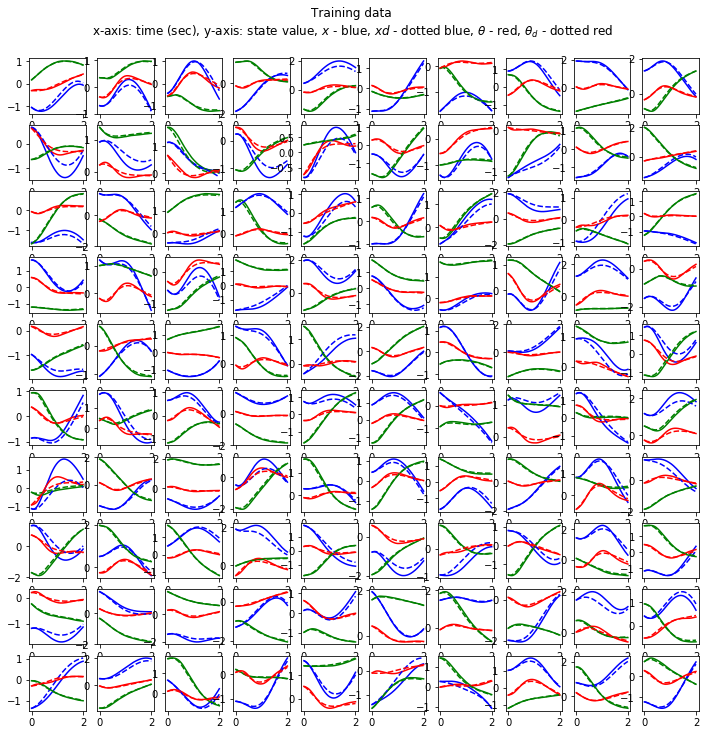

In [4]:
xd = np.empty((n_traj_dc, n_pred_dc + 1, n))
xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
us = np.empty((n_traj_dc, n_pred_dc, m))

plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
for ii in range(n_traj_dc):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd[ii, :, :] = mpc_trajgen.parse_result().T
    while abs(x0[0]) + abs(x0[1]) < 1 or np.any(np.isnan(xd[ii, :, :])):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd[ii, :, :] = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
    xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

    plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
    plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
    plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
    plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
    plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
    plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
    plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

plt.suptitle(
    'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
    y=0.94)
plt.show()

### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}

In [5]:
#DMD parameters:
alpha_dmd = 9.8e-5                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [6]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_dc, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False, continuous_mdl=False, dt=dt)
xdmd, y_dmd = model_dmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [7]:
#EDMD parameters:
alpha_edmd = 2.22e-4                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [8]:
basis = PlanarQuadBasis(n, poly_deg=3)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_edmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_dc, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
model_edmd.reduce_mdl()
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis_reduced, continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [9]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 6.9e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [10]:
n_lift_bedmd = n_lift_edmd
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: planar_quad_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_dc, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)
    

/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1790: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13828911855616555, tolerance: 0.021012215100480656
  check_random_state(self.random_state), random)


### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [11]:
# Prediction performance evaluation parameters:
folder_plots = 'examples/figures/'                                  # Path to save plots
n_traj_ol = 100                                                     # Number of trajectories to execute, open loop

In [12]:
from tabulate import tabulate

xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_dmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_edmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd = mpc_trajgen.parse_result().T

    while xd[0,0] is None:
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)

    xs_ol[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:]-hover_thrust, t_eval[:-1])

    xs_dmd_ol[ii,:,:], _ = sys_dmd.simulate(x0, ol_controller_nom, t_eval[:-1])

    z_0_edmd = sys_edmd.basis(np.atleast_2d(x0)).squeeze()
    zs_edmd_tmp, _ = sys_edmd.simulate(z_0_edmd, ol_controller_nom, t_eval[:-1])
    xs_edmd_ol[ii,:,:] = np.dot(model_edmd.C, zs_edmd_tmp.T).T

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T

error_dmd = xs_ol[:,:-1,:] - xs_dmd_ol
error_dmd_mean = np.mean(error_dmd, axis=0).T
error_dmd_std = np.std(error_dmd, axis=0).T
mse_dmd = np.mean(np.square(error_dmd))
std_dmd = np.std(error_dmd)

error_edmd = xs_ol[:,:-1,:] - xs_edmd_ol
error_edmd_mean = np.mean(error_edmd, axis=0).T
error_edmd_std = np.std(error_edmd, axis=0).T
mse_edmd = np.mean(np.square(error_edmd))
std_edmd = np.std(error_edmd)

error_bedmd = xs_ol[:,:-1,:] - xs_bedmd_ol
error_bedmd_mean = np.mean(error_bedmd, axis=0).T
error_bedmd_std = np.std(error_bedmd, axis=0).T
mse_bedmd = np.mean(np.square(error_bedmd))
std_bedmd = np.std(error_bedmd)

print('\nOpen loop performance statistics:\n')
print(tabulate([['DMD', "{:.5f}".format(mse_dmd), '-', '-', "{:.5f}".format(std_dmd), '-', '-'],
               ['EDMD', "{:.5f}".format(mse_edmd), "{:.2f}".format((1 - mse_edmd / mse_dmd) * 100)+' %', '-', "{:.5f}".format(std_edmd), "{:.2f}".format((1 - std_edmd / std_dmd) * 100)+' %', '-'],
               ['bEDMD', "{:.5f}".format(mse_bedmd), "{:.2f}".format((1 - mse_bedmd / mse_dmd) * 100)+' %', "{:.2f}".format((1 - mse_bedmd / mse_edmd) * 100)+' %', "{:.5f}".format(std_bedmd), "{:.2f}".format((1 - std_bedmd / std_dmd) * 100)+' %', "{:.2f}".format((1 - std_bedmd / std_edmd) * 100)+' %']], 
               headers=['MSE', 'MSE improvement\nover DMD', 'MSE improvement\nover EDMD', 'Standard\ndeviation', 'std improvement\nover DMD', 'std improvement\nover EDMD']))

[ 1.51110979  1.40375887 -0.57465603 -0.72779892  0.62512538  0.03535884]
[ 1.50413823  1.40999295 -0.5743618  -0.6665164   0.62169441  0.02348666]
[ 1.49783066  1.41627207 -0.57405671 -0.59500438  0.63413331  0.03753064]
[ 1.49228927  1.42275503 -0.57344672 -0.51328719  0.66246596  0.08446706]
[ 1.48749708  1.42941705 -0.5724948  -0.44516586  0.6699488   0.10591738]
[ 1.483247    1.43593905 -0.57129778 -0.40486369  0.63446095  0.13348604]
[ 1.4795719   1.4423749  -0.56968362 -0.33018778  0.65272809  0.18934705]
[ 1.47661654  1.44895347 -0.56760062 -0.26092081  0.66301032  0.22725265]
[ 1.47429709  1.45554831 -0.56519885 -0.20300605  0.65598113  0.25310143]
[ 1.47239273  1.46181621 -0.56246048 -0.17788394  0.59760957  0.29457182]
[ 1.47089722  1.46775228 -0.55929386 -0.12126551  0.58963423  0.33875297]
[ 1.46995236  1.47358705 -0.5556367  -0.06775873  0.5773529   0.39267875]
[ 1.46958492  1.47937111 -0.5514583  -0.00579976  0.57950123  0.44300171]
[ 1.46978569  1.48509772 -0.54686822  

[ 1.97664628  1.46845267  0.35184931 -1.52847699 -0.30287594 -0.77538244]
[ 1.96123509  1.46528057  0.3439553  -1.55367029 -0.33151159 -0.80341959]
[ 1.94547136  1.46211417  0.33580788 -1.59890082 -0.30170618 -0.82606467]
[ 1.92935115  1.45898587  0.3275837  -1.62503789 -0.32391763 -0.81877004]
[ 1.91289875  1.45585602  0.31944975 -1.66527848 -0.30199927 -0.80802019]
[ 1.89606488  1.45289795  0.31141644 -1.70134779 -0.28956572 -0.7986425 ]
[ 1.87894596  1.4498424   0.30336193 -1.72234789 -0.3215161  -0.81225844]
[ 1.86161151  1.44649463  0.29527476 -1.74444492 -0.34800804 -0.80517592]
[ 1.84402062  1.44301024  0.2870744  -1.77360086 -0.3488306  -0.83489606]
[ 1.82616303  1.43944753  0.27867077 -1.79780068 -0.36367726 -0.84583098]
[ 1.80809974  1.43562151  0.27023605 -1.81477149 -0.40150182 -0.84111195]
[ 1.78979507  1.43168887  0.26174682 -1.84600072 -0.38498287 -0.85673348]
[ 1.7712141   1.42780529  0.25321367 -1.87006395 -0.39169861 -0.84989739]
[ 1.75235262  1.42402671  0.24470884 -

[ 1.70741862 -0.57972385  0.14981296 -0.92794698  1.28287045 -0.26897083]
[ 1.6980855  -0.5670281   0.14711717 -0.93864316  1.25628495 -0.27018597]
[ 1.68865401 -0.55464975  0.14433485 -0.94762684  1.21938996 -0.28627807]
[ 1.67910675 -0.5424546   0.1415211  -0.96178028  1.21964546 -0.27647218]
[ 1.66942337 -0.53028537  0.13881107 -0.97485322  1.21420744 -0.26553433]
[ 1.65966414 -0.51855673  0.13621961 -0.97698599  1.1315201  -0.25275801]
[ 1.64983059 -0.5072645   0.13384807 -0.98968803  1.12693151 -0.22154916]
[ 1.63988081 -0.49609069  0.13165765 -1.00023761  1.10783444 -0.21653639]
[ 1.62985661 -0.48533705  0.12938692 -1.0045911   1.04289468 -0.237608  ]
[ 1.61975971 -0.47500429  0.12697845 -1.01475663  1.0236615  -0.24408754]
[ 1.60958319 -0.46502991  0.12461635 -1.02052999  0.97121809 -0.22833123]
[ 1.59933663 -0.4554768   0.12235136 -1.02875712  0.93940594 -0.22466734]
[ 1.58901252 -0.44627428  0.12013246 -1.03604228  0.90110133 -0.21911347]
[ 1.57862444 -0.43752324  0.11793356 -

[ 1.9221347  -0.16577723  0.41816471 -0.6872374  -1.39644993 -0.57683251]
[ 1.91515549 -0.17999055  0.4124024  -0.70855917 -1.44619315 -0.57562963]
[ 1.90782579 -0.19438206  0.40656369 -0.75727106 -1.43206232 -0.59211232]
[ 1.89986793 -0.20829369  0.4004918  -0.83411948 -1.35018419 -0.62226685]
[ 1.89120155 -0.22151343  0.39413514 -0.89899313 -1.2936966  -0.64906407]
[ 1.88202994 -0.23450139  0.38758149 -0.93523112 -1.30385544 -0.661667  ]
[ 1.87259037 -0.24781533  0.38095072 -0.9526361  -1.35891331 -0.66448648]
[ 1.86289404 -0.26146786  0.37436955 -0.98653662 -1.37155479 -0.65174702]
[ 1.85289565 -0.27533317  0.36791966 -1.0130683  -1.40147933 -0.6382312 ]
[ 1.84251358 -0.28918216  0.36151654 -1.0632047  -1.36826448 -0.64239404]
[ 1.83160713 -0.30262487  0.35498949 -1.11792581 -1.3202191  -0.66301592]
[ 1.82018382 -0.31565471  0.34838164 -1.16659046 -1.28569462 -0.65855382]
[ 1.80823884 -0.32822849  0.3418081  -1.22223558 -1.22900012 -0.65615375]
[ 1.79579731 -0.34038862  0.33521136 -

[-2.02103945  1.84456137 -0.46396359 -0.15588934 -0.30588056  0.13343459]
[-2.02224374  1.84172157 -0.46242824 -0.08500427 -0.26206207  0.17363684]
[-2.02285122  1.83909777 -0.46064146 -0.0365206  -0.26268243  0.18371809]
[-2.02298595  1.83644563 -0.45868957  0.00954488 -0.26773139  0.20666116]
[-2.02253656  1.83399583 -0.45651744  0.08028053 -0.22220261  0.22776354]
[-2.02140347  1.83195711 -0.45426043  0.14628678 -0.18551749  0.22363812]
[-2.01967381  1.83015884 -0.45190223  0.19960246 -0.17411412  0.24800202]
[-2.01737565  1.82855099 -0.44927322  0.25997422 -0.14743028  0.27780077]
[-2.01444931  1.82726517 -0.44644759  0.32522941 -0.10970329  0.28732437]
[-2.01098258  1.82612671 -0.44359117  0.36807372 -0.11796852  0.28396036]
[-2.00697122  1.82515409 -0.44054141  0.434128   -0.07652218  0.32599223]
[-2.00253383  1.82410282 -0.43723721  0.45332822 -0.13372133  0.33484683]
[-1.99786429  1.82256746 -0.43385563  0.48054581 -0.1733339   0.34146979]
[-1.99286506  1.82076313 -0.43045583  

[ 0.35588439  1.17765754  0.16101567  1.06047232 -0.08125535  0.54860728]
[ 0.36642181  1.17676412  0.16654593  1.04693571 -0.09744118  0.55744483]
[ 0.37687613  1.17538769  0.17212119  1.04391063 -0.17784763  0.55760749]
[ 0.38724343  1.17352727  0.17758628  1.02947639 -0.19424909  0.53540989]
[ 0.39746486  1.1714987   0.18303448  1.01473575 -0.2114783   0.55422894]
[ 0.40750554  1.16946387  0.18853663  0.99329525 -0.19550881  0.54620187]
[ 0.4173067   1.1677023   0.19386894  0.96681606 -0.15682896  0.52025965]
[ 0.42687145  1.16616551  0.19892948  0.94604488 -0.15054519  0.49184804]
[ 0.43617311  1.16495066  0.20379121  0.91416004 -0.09245148  0.48049947]
[ 0.44516642  1.16424743  0.20857076  0.88438981 -0.04821752  0.47540917]
[ 0.45388577  1.16385867  0.21329625  0.85938801 -0.02955407  0.4696896 ]
[ 0.46244779  1.16321863  0.21797509  0.8529932  -0.09845992  0.46607731]
[ 0.47088472  1.16216031  0.22275445  0.83432643 -0.11321932  0.48979504]
[ 0.47912984  1.16096765  0.22766062  

[ 1.03964427  0.25460757  0.16265269  0.90299065  1.9911143  -0.17141652]
[ 1.04863854  0.27424616  0.16090084  0.89587637  1.93660411 -0.17895357]
[ 1.05750501  0.2936924   0.15923336  0.8774502   1.95264936 -0.15454221]
[ 1.06614627  0.31356086  0.15763131  0.85084639  2.02105105 -0.16586715]
[ 1.07463176  0.33342591  0.15599401  0.84626     1.95195914 -0.16159412]
[ 1.08306856  0.35261966  0.15452133  0.84110613  1.88679269 -0.13294062]
[ 1.09138416  0.37161179  0.15308883  0.82204391  1.91163743 -0.15356034]
[ 1.0995356   0.39068632  0.15168727  0.80826463  1.9032721  -0.12675102]
[ 1.10754312  0.40972135  0.15046487  0.79326021  1.90373732 -0.11772827]
[ 1.1154642   0.42834443  0.14928713  0.79095854  1.82087928 -0.11782087]
[ 1.12330227  0.44653942  0.14824566  0.77667159  1.81812072 -0.09047211]
[ 1.13099025  0.46475837  0.14744164  0.76093893  1.82567062 -0.07033214]
[ 1.13851359  0.48310484  0.14679148  0.74374207  1.84362597 -0.05969988]
[ 1.14588574  0.50149266  0.14624638  

[ 0.13995413 -0.4967826   0.19966148  1.50341819 -1.04010309  0.1549542 ]
[ 0.15483351 -0.50691104  0.201032    1.4724226  -0.9855922   0.11914934]
[ 0.16946687 -0.51681254  0.20231669  1.45423151 -0.99471104  0.13778853]
[ 0.18388052 -0.52662428  0.20358638  1.42847151 -0.96764314  0.11614816]
[ 0.19808585 -0.53640744  0.20473397  1.41258016 -0.98899085  0.11337016]
[ 0.21211431 -0.54631994  0.20584836  1.39309466 -0.9935131   0.10950832]
[ 0.22592132 -0.55615305  0.20689037  1.36828551 -0.97311258  0.09889409]
[ 0.23945337 -0.5656574   0.2078946   1.33810158 -0.92776329  0.10195221]
[ 0.252761   -0.57507819  0.20880067  1.3234138  -0.95639631  0.07926157]
[ 0.26590805 -0.5847222   0.20963307  1.30598496 -0.97240751  0.08721838]
[ 0.27879802 -0.59413944  0.21051005  1.27198501 -0.91104538  0.08817824]
[ 0.29141554 -0.60326215  0.21135957  1.25150488 -0.91349994  0.08172442]
[ 0.30376065 -0.61209666  0.21212051  1.21749766 -0.85340621  0.07046467]
[ 0.31583157 -0.62063863  0.21295535  

[0.10979677 0.23057597 0.48653028 0.56660958 0.22741701 0.03609767]
[0.11537308 0.23252934 0.48683119 0.54865085 0.16325616 0.02408351]
[0.12068756 0.23399632 0.48712857 0.51424248 0.13013854 0.03539183]
[0.12566118 0.23512579 0.48748462 0.4804783  0.09575261 0.03581904]
[0.13014276 0.23620226 0.48788381 0.4158296  0.11953736 0.0440182 ]
[0.13381215 0.23782813 0.48826306 0.31803624 0.20563028 0.03183201]
[0.13688397 0.23959823 0.48860244 0.29632555 0.14838805 0.0360451 ]
[0.13953348 0.24118163 0.48892813 0.23357082 0.16829007 0.02909338]
[ 0.1415922   0.24289461  0.48900463  0.17817121  0.17430374 -0.01379451]
[ 0.14304145  0.24477206  0.48866605  0.11168646  0.2011901  -0.05392201]
[ 0.14386481  0.24684578  0.48793205  0.05299902  0.21356124 -0.0928781 ]
[ 0.14414311  0.24896549  0.48695437  0.00267641  0.21038827 -0.10265704]
[ 0.14395004  0.25099443  0.48580516 -0.04127569  0.1954092  -0.12718442]
[ 0.14323235  0.25303614  0.48441683 -0.10223445  0.2129477  -0.15048266]
[ 0.14217773

[ 2.00652492 -0.52142372  0.47935529  0.20098795  1.41103531 -0.44248424]
[ 2.00829843 -0.50734744  0.47467709  0.15378506  1.40425844 -0.49315595]
[ 2.00970057 -0.49353018  0.4696889   0.12668729  1.35921568 -0.50448202]
[ 2.01095048 -0.48039496  0.46461745  0.12329944  1.26783234 -0.50980781]
[ 2.01187266 -0.46758437  0.45949874  0.06124388  1.29433713 -0.51393414]
[ 2.01224019 -0.45463442  0.45431836  0.0123486   1.29569605 -0.52214112]
[ 2.01218517 -0.44180081  0.4489953  -0.02328875  1.2710568  -0.54247147]
[ 2.01173021 -0.42911769  0.44350831 -0.06761802  1.26560799 -0.55492725]
[ 2.0108248  -0.41646727  0.43789013 -0.1133735   1.26451968 -0.56870884]
[ 2.00941782 -0.40372604  0.43203127 -0.1679072   1.28377881 -0.60306192]
[ 2.00763943 -0.39116219  0.42593659 -0.18772796  1.22901192 -0.6158743 ]
[ 2.00572052 -0.37927033  0.41974284 -0.19603317  1.14936835 -0.62287684]
[ 2.00360152 -0.36790963  0.41364805 -0.22769416  1.12280438 -0.59608128]
[ 2.00117468 -0.35682873  0.40766976 -

[ 1.04057857 -0.50625061  0.19556807 -1.50114539 -0.10830664 -0.38463727]
[ 1.02548993 -0.50743187  0.19171208 -1.51653355 -0.12793521 -0.38656022]
[ 1.01021247 -0.50862014  0.18800416 -1.53888605 -0.10970406 -0.35502317]
[ 0.99482487 -0.51021437  0.18441553 -1.53863397 -0.2091421  -0.36270213]
[ 0.97936383 -0.51239307  0.18074558 -1.55352586 -0.22659029 -0.37128925]
[ 0.96377657 -0.5148629   0.17696023 -1.56388944 -0.26736868 -0.38577998]
[ 0.94802819 -0.51741037  0.17320794 -1.58570861 -0.24211098 -0.36467793]
[ 0.93209393 -0.51987768  0.16951119 -1.60108871 -0.25134222 -0.37467344]
[ 0.91598027 -0.5222765   0.16566209 -1.62156662 -0.22840792 -0.39514649]
[ 0.8996864  -0.52457954  0.16170611 -1.63714436 -0.23219027 -0.3960492 ]
[ 0.88320576 -0.52671698  0.15776232 -1.65889442 -0.19528383 -0.3927082 ]
[ 0.86649821 -0.52840848  0.1539395  -1.68252069 -0.14300087 -0.37185504]
[ 0.84959485 -0.52982116  0.1501657  -1.69808662 -0.13952529 -0.38290574]
[ 0.83257937 -0.53147612  0.14633639 -

[ 1.78218087 -0.14667078  0.39684808 -1.54315912  0.59072718 -0.85362796]
[ 1.76668399 -0.14109695  0.38826158 -1.55617241  0.52405613 -0.8636713 ]
[ 1.75094865 -0.13591889  0.37952524 -1.59077157  0.51160744 -0.88359626]
[ 1.73484388 -0.13079498  0.37053999 -1.63003306  0.5132336  -0.91345352]
[ 1.71840089 -0.12578256  0.36118905 -1.65844817  0.48929457 -0.95673505]
[ 1.70155554 -0.12068281  0.35157726 -1.71039866  0.53073856 -0.96562398]
[ 1.68431592 -0.11549245  0.34196601 -1.7374059   0.50737513 -0.95662432]
[ 1.66680758 -0.11052811  0.33239081 -1.76414044  0.48553598 -0.9584156 ]
[ 1.64898661 -0.10563761  0.32267688 -1.7998826   0.49262314 -0.98437229]
[ 1.63087592 -0.10086362  0.31284205 -1.82214541  0.46221121 -0.98259258]
[ 1.61253656 -0.09636334  0.30283876 -1.84560354  0.43788343 -1.01806552]
[ 1.59385251 -0.09173651  0.29279848 -1.89095897  0.48755848 -0.98999051]
[ 1.57467897 -0.08646528  0.28285108 -1.94345415  0.5667747  -0.99948884]
[ 1.55508364 -0.08072782  0.2727894  -

[ 0.244554   -0.26121047  0.15507996 -0.12156347  0.66488386 -0.03873409]
[ 0.24326798 -0.25460153  0.15467911 -0.13563445  0.65690605 -0.04143577]
[ 0.2418118  -0.24788209  0.1542947  -0.15559439  0.68698232 -0.03544675]
[ 0.24019545 -0.24111405  0.15384004 -0.16766932  0.666627   -0.0554834 ]
[ 0.23846055 -0.23456242  0.15322426 -0.17930301  0.64369928 -0.06767279]
[ 0.2365695  -0.2279803   0.15260363 -0.19889429  0.67272665 -0.05645463]
[ 0.23452015 -0.22135025  0.15201666 -0.21096849  0.65328449 -0.06093792]
[ 0.2323636  -0.21500159  0.15130357 -0.22033291  0.61644938 -0.08168052]
[ 0.2301115  -0.20900705  0.15038965 -0.23007887  0.58246    -0.10110295]
[ 0.22773634 -0.20318099  0.14927365 -0.24493477  0.58275586 -0.12209859]
[ 0.2251998  -0.19726258  0.14800504 -0.26234696  0.60092946 -0.1316219 ]
[ 0.22248114 -0.19110337  0.14665035 -0.28135616  0.63091559 -0.13931734]
[ 0.21958948 -0.18475423  0.1451995  -0.2969508   0.63891646 -0.15085312]
[ 0.21652266 -0.17818762  0.14352672 -

[-0.17436896 -0.2049054  -0.04179146 -0.00983484  0.93197901  0.04667091]
[-0.17444063 -0.19543557 -0.04128631 -0.00450953  0.96198615  0.05435926]
[-0.17447052 -0.18593678 -0.04088561 -0.00147388  0.93777285  0.02578087]
[-0.17446652 -0.17659031 -0.0405437   0.00226903  0.93152059  0.04260044]
[-0.17441627 -0.1670836  -0.04004534  0.0077699   0.96982229  0.05707188]
[-0.17433837 -0.15787105 -0.03940254  0.00780829  0.87268801  0.07148934]
[-0.17424173 -0.14916089 -0.03869377  0.01151012  0.86934391  0.07026357]
[-0.17412035 -0.14079479 -0.03794188  0.01276145  0.80387751  0.08011441]
[-0.17397328 -0.13273047 -0.03720221  0.01664     0.80898685  0.06782029]
[-0.17379601 -0.12483715 -0.03644886  0.01880672  0.76967774  0.08284864]
[-0.17359923 -0.11739026 -0.03562177  0.02054152  0.7196989   0.0825689 ]
[-0.17337745 -0.11022071 -0.03472397  0.02380145  0.71421195  0.0969921 ]
[-0.17312908 -0.10326834 -0.03372848  0.02586124  0.6762625   0.10210647]
[-0.17285046 -0.09639724 -0.03274775  

[-1.10834746 -0.16851074 -0.13351966  1.8838129   1.4795332   0.72857275]
[-1.08945381 -0.15378479 -0.12618021  1.89481368  1.46566982  0.7393185 ]
[-1.07044857 -0.13915944 -0.11887334  1.90612236  1.45941393  0.72205543]
[-1.05130542 -0.12435557 -0.11162905  1.92233766  1.50138085  0.72680254]
[-1.03205846 -0.10961722 -0.10446707  1.92700259  1.44629445  0.70559253]
[-1.01272076 -0.09498429 -0.09738998  1.94038255  1.48030798  0.70982598]
[-0.99326846 -0.08016319 -0.09034825  1.94995755  1.48392225  0.69851919]
[-0.97374353 -0.06552716 -0.08341822  1.95496264  1.44329045  0.68748688]
[-0.95414621 -0.05099803 -0.07644978  1.96436522  1.46254605  0.70620231]
[-0.93448944 -0.03668636 -0.06930217  1.96694606  1.39979057  0.72331832]
[-0.91478964 -0.02272609 -0.06211274  1.97290576  1.39227058  0.71456884]
[-0.89502174 -0.00864443 -0.05498869  1.98051975  1.42407093  0.71024128]
[-0.8751956   0.00550341 -0.04794143  1.98461568  1.40550139  0.69920979]
[-0.85532547  0.01959328 -0.04083806  

[-0.44218205  0.15832783  0.18323363  1.81482281 -0.91991769  0.72478624]
[-0.42415272  0.14927128  0.19034338  1.79089386 -0.89141981  0.69716368]
[-0.40637225  0.14052519  0.19719176  1.76504925 -0.85782818  0.67251331]
[-0.38883065  0.13199517  0.20392934  1.74314904 -0.84820009  0.67500224]
[-0.37151636  0.12358315  0.21044331  1.71958701 -0.83423     0.62779264]
[-0.35446753  0.11543173  0.21668256  1.69003867 -0.79608524  0.62005704]
[-0.33767818  0.10747997  0.2226565   1.6677305  -0.79428843  0.57473084]
[-0.32115442  0.09971884  0.22820752  1.63689869 -0.75796563  0.535473  ]
[-0.30494516  0.09233097  0.23345763  1.6048325  -0.7196371   0.51454986]
[-0.28907236  0.08537676  0.23840515  1.56960684 -0.6712343   0.474953  ]
[-0.2734397   0.07843304  0.24311591  1.55688465 -0.71751902  0.46720005]
[-0.2580316   0.07141119  0.24774974  1.52463595 -0.68687623  0.45956484]
[-0.24291574  0.06456458  0.25220622  1.49846069 -0.68246609  0.43173178]
[-0.22808329  0.05783641  0.25644909  

[-0.01347419 -1.11182547  0.20923306 -0.1261273  -0.10736457 -0.2482248 ]
[-0.01480213 -1.11307437  0.20669565 -0.13943353 -0.14240929 -0.25925681]
[-0.01629265 -1.11452826  0.20407791 -0.15863083 -0.14836022 -0.26429023]
[-0.01799858 -1.11592182  0.20144412 -0.18250333 -0.13034011 -0.26246769]
[-0.01992271 -1.1172283   0.19893334 -0.2022833  -0.13094747 -0.23968931]
[-0.02213308 -1.11809407  0.19635657 -0.23970876 -0.04219162 -0.27566386]
[-0.02463673 -1.11846817  0.19357417 -0.26097204 -0.03261759 -0.28081564]
[-0.02732635 -1.11887516  0.19064723 -0.27691251 -0.04877412 -0.30457379]
[-0.03015484 -1.11954416  0.18765399 -0.28875332 -0.08501965 -0.29407326]
[-0.03317132 -1.12020211  0.18470038 -0.31447623 -0.04655769 -0.29664987]
[-0.03640181 -1.12069676  0.18166586 -0.33157577 -0.0523633  -0.3102525 ]
[-0.03978497 -1.12134187  0.17867693 -0.34501881 -0.07665195 -0.28753413]
[-0.04333582 -1.12203842  0.17572765 -0.36509572 -0.06264893 -0.30232144]
[-0.04707567 -1.12265173  0.17255851 -

[ 0.81556116 -0.38902452  0.29130548 -0.18461455  0.08117338 -0.23963193]
[ 0.81356547 -0.38820306  0.28879814 -0.2144806   0.08313071 -0.26183494]
[ 0.81127522 -0.38737111  0.28611301 -0.24352615  0.08327173 -0.27519208]
[ 0.80866653 -0.38643744  0.28353807 -0.27816075  0.10347783 -0.23979493]
[ 0.80576405 -0.38547712  0.28114535 -0.30230139  0.08859549 -0.23874892]
[ 0.80254799 -0.38441123  0.27885879 -0.34086082  0.12459735 -0.21856318]
[ 0.79908811 -0.3834762   0.27658314 -0.35110055  0.06241301 -0.23656752]
[ 0.79541832 -0.38278147  0.27417311 -0.38281352  0.07654555 -0.24543873]
[ 0.79146916 -0.38207486  0.27167935 -0.40698168  0.06478565 -0.25331315]
[ 0.78721401 -0.38125007  0.26927796 -0.44399523  0.10018814 -0.2269644 ]
[ 0.78269569 -0.38045388  0.26699121 -0.45964694  0.05905444 -0.23038485]
[ 0.77794566 -0.37979076  0.26478142 -0.49031725  0.07358145 -0.21157304]
[ 0.77297628 -0.37930057  0.26262582 -0.50354197  0.0244622  -0.21954845]
[ 0.767803   -0.37903214  0.26037624 -

[ 0.44474222 -0.18670932 -0.29191938  1.01786668 -0.06256074  0.38060367]
[ 0.45505926 -0.1873628  -0.28800351  1.04548134 -0.06811542  0.40257003]
[ 0.46563189 -0.18813476 -0.28394112  1.06899065 -0.0862622   0.4099081 ]
[ 0.47656358 -0.18865512 -0.27979417  1.1172315  -0.01777673  0.41948216]
[ 0.48789682 -0.18876036 -0.27561461  1.14933851 -0.00324732  0.41642879]
[ 0.4995744  -0.18862855 -0.27137481  1.18608398  0.02963495  0.4315322 ]
[ 0.51156499 -0.18835375 -0.26706053  1.21196702  0.02534266  0.4313242 ]
[ 0.52379134 -0.18819866 -0.26261774  1.23324517  0.00569238  0.45723306]
[ 0.53616958 -0.18846086 -0.25803873  1.24237683 -0.0581263   0.45856923]
[ 0.54871876 -0.1890545  -0.25345119  1.26738512 -0.06058164  0.45893903]
[ 0.56155599 -0.18951604 -0.24881581  1.29996285 -0.03170158  0.46813605]
[ 0.57470096 -0.18974772 -0.24407167  1.32894105 -0.01461143  0.4806926 ]
[ 0.58813997 -0.18977949 -0.23925519  1.35876338  0.00828043  0.48260276]
[ 0.60187752 -0.18956828 -0.23443266  

[ 0.07999951  1.23633261  0.31086947  0.64179969 -0.17180976  0.20651661]
[ 0.08627923  1.23455336  0.31293803  0.614116   -0.18404947  0.20719556]
[ 0.09227941  1.23265707  0.31495825  0.58588958 -0.19521761  0.19684982]
[ 0.09794383  1.23081001  0.31683742  0.54695742 -0.17420779  0.17898321]
[ 0.10325375  1.22906336  0.3186183   0.51499884 -0.17513121  0.17719279]
[ 0.10815832  1.22756411  0.32038649  0.46586983 -0.12473251  0.17644516]
[ 0.11261353  1.22643832  0.32219838  0.42513534 -0.10043894  0.18593398]
[ 0.11671343  1.22539619  0.32399244  0.39481761 -0.10799511  0.17287781]
[ 0.12040806  1.22457929  0.32571945  0.34406526 -0.05539974  0.17252381]
[ 0.1236557   1.22410516  0.32747637  0.30542963 -0.03943685  0.17885912]
[ 0.12657367  1.22362082  0.32927905  0.27813994 -0.05744044  0.18167844]
[ 0.12912036  1.22324141  0.33107431  0.23115732 -0.01845548  0.17737202]
[0.1311678  1.22333333 0.33286552 0.17828411 0.03682285 0.18087144]
[0.13278034 1.22370265 0.33468077 0.14419579

[-0.06765917  1.00021377 -0.34468832  0.16966989 -0.8295293   0.06017485]
[-0.06579762  0.99188745 -0.34402895  0.20263009 -0.83573096  0.07170042]
[-0.06354105  0.98368282 -0.34331018  0.24866679 -0.80519058  0.07205257]
[-0.06080983  0.97582511 -0.34243381  0.29755719 -0.766343    0.10322087]
[-0.05771604  0.9680032  -0.34136667  0.32119021 -0.79803628  0.110207  ]
[-0.05427016  0.96019174 -0.34012035  0.36795859 -0.76424602  0.13905831]
[-0.05040597  0.95258124 -0.33864642  0.4048539  -0.75784415  0.15572657]
[-0.04611721  0.94519553 -0.33686255  0.45285687 -0.71928275  0.20104717]
[-0.04138436  0.93809679 -0.33479037  0.49367279 -0.70045166  0.213389  ]
[-0.0361577   0.93143717 -0.33246155  0.55159345 -0.63144923  0.25237518]
[-0.03039759  0.92534135 -0.32985293  0.60036797 -0.58769444  0.26935014]
[-0.02431925  0.91919262 -0.32702961  0.61527816 -0.64204496  0.29531342]
[-0.01800658  0.91275456 -0.32411192  0.64721091 -0.64555096  0.28822447]
[-0.0112548   0.90664377 -0.32101013  

[-0.36726196  0.14736282  0.13716888  0.21844968  0.47197423 -0.24218823]
[-0.36514048  0.15205133  0.13469452  0.20588481  0.46573336 -0.25268454]
[-0.36309189  0.15629436  0.13209847  0.20383963  0.3828726  -0.266525  ]
[-0.36112927  0.16020682  0.12943771  0.18873427  0.39962664 -0.26562656]
[-0.35932613  0.16436393  0.12680437  0.17195178  0.43180238 -0.26104217]
[-0.35767538  0.16873469  0.12415343  0.15824518  0.4423569  -0.26914685]
[-0.35616418  0.17324287  0.12143836  0.1440482   0.45928589 -0.27386628]
[-0.35479577  0.17794042  0.11859304  0.1296899   0.48023001 -0.2951987 ]
[-0.35353598  0.18256631  0.11556509  0.12230027  0.44495111 -0.3103897 ]
[-0.35237107  0.18703039  0.11241536  0.11073396  0.44787193 -0.31955734]
[-0.35132636  0.19157873  0.10925896  0.09826658  0.46180133 -0.31172285]
[-0.35039572  0.19618507  0.10611691  0.08791273  0.45947248 -0.31668647]
[-0.34955809  0.20068283  0.10293265  0.07965512  0.44008382 -0.32016524]
[-0.34878939  0.20486567  0.09969962  

[0.16047519 0.81155918 0.34972568 0.71174339 1.48085514 0.36759538]
[0.1674944  0.82614554 0.35333719 0.69206581 1.43640511 0.35470588]
[0.17431474 0.84029014 0.35660741 0.67197316 1.39250322 0.29933873]
[0.18083065 0.85427016 0.35955581 0.63115379 1.40348092 0.29034078]
[0.18695769 0.86830386 0.36238809 0.59420833 1.40324285 0.27611604]
[0.19277752 0.88216737 0.36506883 0.56972849 1.36944825 0.26003036]
[0.19829661 0.8958364  0.3675166  0.53405322 1.36434136 0.22952506]
[0.20338126 0.90965246 0.36968693 0.48282789 1.3988535  0.20454055]
[0.20813742 0.92333624 0.37158886 0.46839263 1.33789796 0.17584574]
[0.21267314 0.93660438 0.3733129  0.4387304  1.31572024 0.16896114]
[0.21689194 0.94970059 0.37493221 0.40500636 1.30351357 0.15490163]
[0.22078349 0.96264744 0.3763644  0.37328314 1.2858481  0.13153662]
[0.22433715 0.9754682  0.37770779 0.33742817 1.27829674 0.13714147]
[0.22766607 0.98787486 0.37889565 0.32835135 1.20303265 0.10043003]
[0.23077279 0.9998583  0.37993398 0.29297757 1.1

[ 1.56252445  1.90011357  0.11765864 -0.95373548 -0.00724308 -0.33277327]
[ 1.5529011   1.90028511  0.11429081 -0.97085028  0.0415597  -0.34079318]
[ 1.54310254  1.90100281  0.1107971  -0.98876994  0.10199023 -0.35794869]
[ 1.53316954  1.9019439   0.10717259 -0.99778037  0.08623285 -0.36695309]
[ 1.52316904  1.90252919  0.10340834 -1.00229312  0.03082799 -0.38589735]
[ 1.51308925  1.90290186  0.0995091  -1.01359324  0.04371464 -0.39395161]
[ 1.5029209   1.90317766  0.09541483 -1.02003173  0.01144943 -0.42490073]
[ 1.49266871  1.90335188  0.0911817  -1.03032904  0.02340184 -0.42172574]
[ 1.4823102   1.90370881  0.08698137 -1.04128715  0.04799236 -0.41834157]
[ 1.47186067  1.90412551  0.08274165 -1.04855762  0.03535164 -0.42960251]
[ 1.46132215  1.90463823  0.07842583 -1.05905246  0.06719944 -0.43356023]
[ 1.45070337  1.90518593  0.07424727 -1.06465283  0.04234639 -0.40215158]
[ 1.44001715  1.90566221  0.07030146 -1.07251905  0.0529141  -0.38701075]
[ 1.42924791  1.90633826  0.06642618 -

[ 0.10248128 -0.53529026  0.10672972  0.11769319 -0.97593982  0.37628319]
[ 0.10360306 -0.54503141  0.11045183  0.10660071 -0.97229866  0.36813906]
[ 0.10462577 -0.55485869  0.11402224  0.09789384 -0.99316185  0.34594353]
[ 0.10556881 -0.56497048  0.11740314  0.09067955 -1.0292008   0.33023699]
[ 0.10640742 -0.57518023  0.12059088  0.07698201 -1.01275499  0.30730996]
[ 0.10709088 -0.58509149  0.1235091   0.05964049 -0.96950601  0.27633355]
[ 0.10755547 -0.59422316  0.12624233  0.03318212 -0.85683941  0.2703143 ]
[ 0.10782346 -0.60278258  0.12879705  0.02037243 -0.85505144  0.24062905]
[ 1.07928322e-01 -6.11065023e-01  1.31148008e-01  5.41472729e-04
 -8.01444385e-01  2.29562301e-01]
[ 0.10787304 -0.61911249  0.13345157 -0.01163385 -0.80805277  0.23114941]
[ 0.10768903 -0.62718244  0.13582842 -0.02520707 -0.8059432   0.24422211]
[ 0.1073867  -0.63536679  0.13815132 -0.03528737 -0.8309306   0.22035741]
[ 0.10694997 -0.64356661  0.14025798 -0.05210139 -0.80903959  0.20097514]
[ 0.10635146 

[ 1.27554359  0.68006527  0.29520308 -1.55061321  0.34696734 -0.64722741]
[ 1.2599138   0.68345428  0.28865135 -1.57525419  0.33085981 -0.66311738]
[ 1.24397492  0.68690502  0.28200702 -1.61238172  0.35933004 -0.66574919]
[ 1.22770425  0.69051891  0.27539681 -1.64163946  0.36347945 -0.65629345]
[ 1.21111963  0.69426358  0.26877788 -1.67515279  0.38549171 -0.66749258]
[ 1.19419146  0.69827491  0.26207186 -1.71033541  0.41681365 -0.67371198]
[ 1.17701982  0.70220944  0.25521237 -1.72393398  0.37010853 -0.69818448]
[ 1.15961171  0.70607311  0.24823672 -1.757536    0.40266487 -0.69694572]
[ 1.1419241   0.71005649  0.2413102  -1.7798838   0.39403682 -0.68835804]
[ 1.12404007  0.71385594  0.23444629 -1.79684087  0.36587283 -0.68442549]
[ 1.10592496  0.71764467  0.22759393 -1.82603955  0.39190576 -0.68604627]
[ 1.08760733  0.72132296  0.22064531 -1.8374288   0.34376636 -0.70367777]
[ 1.06913114  0.72472951  0.2135898  -1.85770196  0.33756727 -0.70742291]
[ 1.05041751  0.7282518   0.2064823  -

[ 0.43113392 -0.01288682  0.04045207  1.59899033  0.80716083  0.27872768]
[ 0.44709894 -0.00470482  0.04323769  1.59395868  0.82923525  0.27839517]
[0.46302132 0.00348663 0.04593918 1.59048104 0.80905368 0.26190311]
[0.47890954 0.01144083 0.04852885 1.58713257 0.78178466 0.25603044]
[0.49476384 0.01911264 0.05105075 1.58369922 0.75257572 0.24835124]
[0.51058096 0.02653046 0.05361414 1.57969256 0.73098694 0.26432648]
[0.5263483  0.03389216 0.05627128 1.57372749 0.7413512  0.26710187]
[0.54207302 0.04103456 0.05892908 1.57119733 0.68712712 0.26445708]
[0.55775382 0.04793586 0.06160116 1.56491645 0.69312967 0.26995967]
[0.57335429 0.05515503 0.0642238  1.55510784 0.75070084 0.25456828]
[0.5889108  0.06208812 0.06693732 1.55620311 0.63591653 0.28813546]
[0.60444656 0.0683434  0.06963872 1.55091248 0.61513721 0.25214486]
[0.61992443 0.07444698 0.07207278 1.54462711 0.60557715 0.23466664]
[0.63534533 0.08036001 0.07438791 1.53952452 0.57702617 0.22835987]
[0.65069774 0.08620847 0.07676509 1.

[ 1.68731693  0.82090607  0.5014183  -0.44654575 -2.05775978 -0.12914868]
[ 1.6826053   0.80028759  0.49982666 -0.49575729 -2.06592247 -0.18918022]
[ 1.67726052  0.7798481   0.49755575 -0.57314441 -2.02194596 -0.2650006 ]
[ 1.67124993  0.75965325  0.49465354 -0.62892474 -2.01699897 -0.31544203]
[ 1.66475136  0.73938183  0.49131373 -0.67074479 -2.03726043 -0.35252094]
[ 1.65762145  0.71931054  0.48767901 -0.75514157 -1.9769476  -0.37442305]
[ 1.64978264  0.69959409  0.4836979  -0.81254894 -1.96630361 -0.42179822]
[ 1.64133838  0.68004949  0.47931287 -0.87621411 -1.94257068 -0.45520679]
[ 1.63242503  0.66042531  0.47459672 -0.90640927 -1.98224136 -0.48802311]
[ 1.62322029  0.64038727  0.46955949 -0.93449211 -2.02534339 -0.51942452]
[ 1.61357185  0.62024413  0.46418201 -0.99508878 -2.00322949 -0.55607173]
[ 1.6034157   0.60013325  0.4584014  -1.03606135 -2.01890702 -0.6000496 ]
[ 1.59280052  0.57997222  0.45217302 -1.08686643 -2.01324691 -0.64562571]
[ 1.5814709   0.56030351  0.44558489 -

[ 0.06855807 -0.32023209 -0.00550056  0.49989674 -0.52051622  0.10450026]
[ 0.07355823 -0.32569553 -0.0044774   0.50012829 -0.57217051  0.10013271]
[ 0.07856185 -0.33134673 -0.00352179  0.50057619 -0.55806937  0.09099008]
[ 0.08357014 -0.33663825 -0.0027587   0.50106205 -0.50023533  0.06162804]
[ 0.08858239 -0.34149126 -0.00215435  0.50137615 -0.47036599  0.05924132]
[ 0.09359722 -0.34614325 -0.00164465  0.50158063 -0.46003202  0.04269901]
[ 0.09861347 -0.35093941 -0.0012636   0.50166587 -0.4991997   0.03351103]
[ 0.10363073 -0.35589438 -0.00084846  0.5017787  -0.49179467  0.04951716]
[ 1.08648617e-01 -3.61155010e-01 -2.30648475e-04  5.01795251e-01
 -5.60331725e-01  7.40442354e-02]
[ 1.13666561e-01 -3.66755168e-01  5.16076752e-04  5.01781264e-01
 -5.59699795e-01  7.53008099e-02]
[ 0.11868384 -0.3721531   0.00127859  0.50165773 -0.51988581  0.07720168]
[ 0.12369993 -0.37752043  0.00203585  0.50155084 -0.55358047  0.07424952]
[ 0.12871424 -0.38302433  0.00279422  0.50129879 -0.54719988  

[ 1.2169149   0.29175433  0.05892588 -0.96850982  1.3637418  -0.5447254 ]
[ 1.2071952   0.30550653  0.05346606 -0.97532044  1.38670389 -0.54723977]
[ 1.19741124  0.31947801  0.04804957 -0.98136445  1.40759882 -0.53605772]
[ 1.18760243  0.33295913  0.0428312  -0.98041568  1.28862288 -0.50761531]
[ 1.1777671   0.34611173  0.03786011 -0.98652385  1.34190247 -0.486604  ]
[ 1.16789135  0.35933008  0.03305743 -0.98857957  1.30177033 -0.4739308 ]
[ 1.15798599  0.37247896  0.02829907 -0.9923956   1.32800738 -0.47774097]
[ 1.14805052  0.38569907  0.02364995 -0.99463091  1.31601686 -0.45208444]
[ 1.1380849   0.3992397   0.01926747 -0.99836547  1.39211188 -0.4244117 ]
[ 1.12809758  0.41287545  0.01503747 -0.99906917  1.33503945 -0.42158706]
[ 1.11810049  0.42620464  0.01080471 -1.00028226  1.33079893 -0.4249648 ]
[ 1.10809507  0.43929946  0.00651198 -1.00076292  1.28816509 -0.4335812 ]
[ 1.09808476  0.45221951  0.00222685 -1.00122423  1.295846   -0.42344471]
[ 1.08807199  0.4653186  -0.00188902 -

[0.34301928 1.18730314 0.11986898 1.9499752  0.51201795 0.35234659]
[0.36246591 1.19236952 0.12343134 1.93929886 0.50125195 0.36012514]
[0.3817869  1.19746634 0.12688397 1.92483339 0.51810277 0.33040057]
[0.40094867 1.20282953 0.13019695 1.90744598 0.55452655 0.3321956 ]
[0.42001018 1.20798233 0.13351902 1.9048458  0.47603174 0.33221888]
[0.43899991 1.21268581 0.13671617 1.89305393 0.46465755 0.30721116]
[0.45788045 1.21720261 0.13976933 1.88301702 0.43869633 0.30341992]
[0.47666325 1.22143333 0.14283494 1.87350827 0.40744411 0.30970308]
[0.49535135 1.22534161 0.14590213 1.86407828 0.37420629 0.30373428]
[0.5139384  1.22895623 0.14899491 1.85329514 0.34871174 0.31482121]
[0.53239235 1.23247547 0.15209512 1.83743994 0.35512787 0.30522077]
[0.55067912 1.23610405 0.15513068 1.81985788 0.37058107 0.30189229]
[0.56879165 1.23986602 0.15810917 1.80259362 0.38180376 0.29380592]
[0.58673806 1.24368921 0.16108843 1.78663889 0.38282563 0.30204554]
[0.6044966  1.24768635 0.16427445 1.7649993  0.4

[-2.15246443  0.00501582 -0.24073456  0.63995326  0.21168764  0.74849427]
[-2.14595742  0.0070848  -0.23313814  0.66133684  0.20213553  0.77079013]
[-2.13924564  0.00903486 -0.2254812   0.68091157  0.187901    0.76059706]
[-2.13239711  0.01059724 -0.21773426  0.68874941  0.12458436  0.78879067]
[-2.12534679  0.01209782 -0.20987633  0.7211196   0.17557426  0.78279516]
[-2.11808533  0.01360208 -0.20202618  0.7311095   0.12529175  0.78723487]
[-2.1106761   0.0148501  -0.19426781  0.75061267  0.12433753  0.76443933]
[-2.1030105   0.01642453 -0.18663903  0.78229762  0.19058936  0.76131659]
[-2.09505704  0.01854068 -0.17896902  0.80821427  0.23267204  0.77268613]
[-2.08687018  0.02096446 -0.1711942   0.82900705  0.25211108  0.78227758]
[-2.07846988  0.02364269 -0.16340468  0.85088483  0.28356331  0.77562696]
[-2.06992091  0.02623513 -0.15567639  0.85884515  0.23493601  0.77002944]
[-2.06129348  0.02834659 -0.14788299  0.86657484  0.18736613  0.78865178]
[-2.05258005  0.03005573 -0.13995416  

[ 0.70394958 -1.43621419 -0.07599463  1.63004134 -0.12132372  0.21026235]
[ 0.72029362 -1.43733951 -0.07386672  1.63872664 -0.10373615  0.21531951]
[ 0.73671797 -1.43836125 -0.07162636  1.64610499 -0.10060998  0.2327519 ]
[ 0.75321879 -1.43929761 -0.06939523  1.6540171  -0.08665895  0.21347524]
[ 0.76978973 -1.44020743 -0.06728911  1.66013991 -0.09530173  0.20774799]
[ 0.78642022 -1.44121478 -0.06519525  1.66592719 -0.10616774  0.21102515]
[ 0.80311407 -1.44223144 -0.06303579  1.67280463 -0.09716205  0.22086604]
[ 0.81988776 -1.44296187 -0.06078551  1.68187739 -0.0489198   0.22919   ]
[ 0.83675018 -1.44321509 -0.05847422  1.69055235 -0.00172007  0.23306845]
[ 0.85368833 -1.44315826 -0.05624983  1.69703405  0.01308732  0.21180848]
[ 0.87070235 -1.44273245 -0.05419935  1.70571637  0.07207785  0.19828781]
[ 0.88778203 -1.44208199 -0.05232589  1.71019515  0.05801593  0.17640447]
[ 0.90491021 -1.44148603 -0.05060337  1.71541043  0.06117723  0.16809943]
[ 0.92208471 -1.44095766 -0.04900479  

[-1.77445187  0.24889054 -0.36222366  1.78369389  1.32952012  0.93916866]
[-1.75646604  0.26209193 -0.35273594  1.81334761  1.31080438  0.95837335]
[-1.73810488  0.27533414 -0.34309233  1.85868426  1.3377097   0.97034871]
[-1.71933451  0.28873978 -0.33338509  1.89522048  1.34347743  0.9710999 ]
[-1.70026604  0.30202332 -0.32367663  1.91836339  1.31326836  0.97059222]
[-1.68091991  0.31515515 -0.31391352  1.95070388  1.31315106  0.98203042]
[-1.6612606   0.3282705  -0.30401421  1.98100165  1.30996892  0.99783125]
[-1.64129703  0.3413749  -0.29395998  2.01154612  1.31096185  1.01301511]
[-1.62108324  0.35432287 -0.28366812  2.03109957  1.27866491  1.04535571]
[-1.60057381  0.36730863 -0.27318253  2.07054556  1.31855743  1.05176244]
[-1.57977951  0.38032514 -0.26252421  2.08819901  1.28477492  1.07990196]
[-1.55872135  0.3933475  -0.25171139  2.12319244  1.31976005  1.08266153]
[-1.53731615  0.40673864 -0.24086203  2.15760072  1.35852983  1.08721115]
[-1.51559949  0.42041514 -0.23002301  

[ 0.36974549  1.42567445 -0.12456952 -0.62447001 -0.334439   -0.36556458]
[ 0.36354421  1.4221829  -0.12824214 -0.61574438 -0.36387681 -0.36895906]
[ 0.3574529   1.41856151 -0.13209041 -0.6024513  -0.36040952 -0.40069502]
[ 0.35147549  1.41481779 -0.1361721  -0.59298349 -0.38834058 -0.41564202]
[ 0.34562757  1.41103565 -0.14025396 -0.57652067 -0.36809884 -0.40073128]
[ 0.33991541  1.40723632 -0.14423634 -0.56586183 -0.39177426 -0.3957446 ]
[ 0.33433727  1.40337711 -0.14813868 -0.54969462 -0.38007789 -0.38472225]
[ 0.32890621  1.39952352 -0.15198267 -0.53646061 -0.39065011 -0.38407623]
[ 0.32363528  1.39573284 -0.15589571 -0.51764763 -0.36749692 -0.39853225]
[ 0.31855722  1.39218823 -0.15982356 -0.49788241 -0.34143877 -0.38703794]
[ 0.31367321  1.38886675 -0.16371414 -0.47884282 -0.32286849 -0.39107704]
[ 0.30893994  1.38547879 -0.16761103 -0.4677682  -0.35473165 -0.38830215]
[ 0.30435327  1.38197477 -0.17130938 -0.44949997 -0.34608285 -0.35136613]
[ 0.29994685  1.37853198 -0.17464714 -

[ 1.19668484 -1.72659551  0.10484544  0.00257271  0.22788866  0.17170124]
[ 1.1966746  -1.72446722  0.10649441 -0.00463817  0.19776681  0.15809319]
[ 1.19655709 -1.72231783  0.10796305 -0.01889691  0.23210843  0.13563528]
[ 1.19629124 -1.71978067  0.10914601 -0.03430174  0.27532141  0.10095614]
[ 1.19586805 -1.71678862  0.11010394 -0.05035771  0.3230854   0.09062988]
[ 1.19529646 -1.71343468  0.11101179 -0.06398044  0.34770132  0.09094086]
[ 1.1946199  -1.71011939  0.11197036 -0.07134135  0.31535477  0.10077181]
[ 1.19385503 -1.70700006  0.11296093 -0.081648    0.30850842  0.0973437 ]
[ 1.19300604 -1.70411974  0.11386753 -0.08815788  0.2675556   0.08397639]
[ 1.19209628 -1.70168883  0.11470481 -0.09380185  0.21862474  0.0834788 ]
[ 1.19108738 -1.69937936  0.11550447 -0.10799375  0.2432691   0.07645301]
[ 1.18990491 -1.69655546  0.11634656 -0.12852557  0.32150698  0.0919648 ]
[ 1.18856211 -1.69333977  0.11720749 -0.14004909  0.32162939  0.08022097]
[ 1.1871043  -1.69012838  0.11802736 -

[ 1.21114861 -1.21787656  0.2410284  -1.73610342 -0.79511635 -0.80899918]
[ 1.19369056 -1.22591895  0.23307672 -1.75540022 -0.81333577 -0.78133497]
[ 1.17596505 -1.23381189  0.225294   -1.78951203 -0.76520816 -0.77521009]
[ 1.15789294 -1.24117292  0.21750008 -1.8247067  -0.7069528  -0.78357289]
[ 1.13954222 -1.24825805  0.20969516 -1.84531353 -0.71004714 -0.77741202]
[ 1.12109996 -1.25590078  0.20174566 -1.84315255 -0.81850146 -0.8124878 ]
[ 1.10255384 -1.26400816  0.1935831  -1.86591659 -0.80294387 -0.82002485]
[ 1.08381249 -1.27210272  0.18537457 -1.88223675 -0.81594588 -0.82168062]
[ 1.06485919 -1.28004377  0.17718528 -1.90823034 -0.77222717 -0.81617816]
[ 1.0456775  -1.28769258  0.16884689 -1.92795046 -0.7575078  -0.85149871]
[ 1.0263378  -1.29539889  0.16036991 -1.93988844 -0.78373763 -0.84389799]
[ 1.00690823 -1.30353365  0.15189917 -1.94597009 -0.8432047  -0.85024928]
[ 0.98737024 -1.31193495  0.14359547 -1.96148533 -0.83703421 -0.81049156]
[ 0.96765566 -1.32009258  0.13532833 -

[ 1.62132061 -0.4054282   0.35324491 -0.10156857  1.95864842 -0.49756242]
[ 1.62022641 -0.38611818  0.34836747 -0.11723709  1.90336748 -0.4779256 ]
[ 1.61891039 -0.3671775   0.34360979 -0.14590455  1.88479213 -0.47361072]
[ 1.61734649 -0.34852558  0.33896955 -0.16682994  1.84560858 -0.45443709]
[ 1.61552595 -0.33012614  0.33452414 -0.19721274  1.83430114 -0.4346461 ]
[ 1.61336654 -0.31173229  0.33020887 -0.23459224  1.84449562 -0.4284071 ]
[ 1.61084095 -0.29325121  0.32592211 -0.27044978  1.85174575 -0.42894424]
[ 1.60797265 -0.27473729  0.32166078 -0.30314223  1.85106147 -0.42332281]
[ 1.60478137 -0.25623524  0.31750629 -0.33504574  1.84937211 -0.40757423]
[ 1.60130288 -0.23784065  0.31354783 -0.36060016  1.82956122 -0.38411876]
[ 1.59767433 -0.21996567  0.30967641 -0.36510217  1.74543779 -0.39016445]
[ 1.59384335 -0.20243685  0.30578924 -0.40102021  1.76034913 -0.3872694 ]
[ 1.58969334 -0.18487899  0.30190327 -0.42892454  1.75124169 -0.3899262 ]
[ 1.58523058 -0.1672974   0.29811241 -

[0.42858383 0.71588302 0.00957041 0.77175473 1.81903271 0.20685605]
[0.43629574 0.73413362 0.01155844 0.7705895  1.83108583 0.19074945]
[0.44399752 0.75229135 0.0134313  0.76974599 1.80046021 0.18382158]
[0.45168997 0.77016177 0.0153546  0.76872123 1.7736239  0.20083992]
[0.4593726  0.78769302 0.01746254 0.76778513 1.7326263  0.22074772]
[0.46704343 0.80491502 0.01960409 0.76635247 1.71177309 0.20756211]
[0.47469397 0.82218165 0.02171262 0.76371105 1.74155094 0.21414357]
[0.48231844 0.83967017 0.02385476 0.76114285 1.75615317 0.21428454]
[0.48991678 0.85727383 0.02602793 0.75848597 1.764578   0.22034909]
[0.49750214 0.87441034 0.02834808 0.75858801 1.66272285 0.24368218]
[0.50508391 0.89068801 0.03075494 0.75775461 1.59281144 0.23768942]
[0.51264984 0.90649353 0.03314327 0.75540317 1.56829063 0.23997658]
[0.52018816 0.92214865 0.03560893 0.75222171 1.56273231 0.25315435]
[0.52768987 0.93784794 0.0381011  0.74807319 1.57712442 0.24527986]
[0.53515113 0.95362853 0.04065365 0.74413639 1.5

[1.0524818  0.5837722  0.00724487 0.9910859  0.65549397 0.29920393]
[1.06239    0.59015919 0.01013883 0.99052412 0.62190395 0.27958945]
[1.07229139 0.59623618 0.01297996 0.98971904 0.59349295 0.28863648]
[1.08218199 0.60215247 0.01595329 0.98835507 0.58976517 0.30602896]
[1.09205538 0.60815828 0.01901447 0.98626154 0.61139455 0.30620692]
[1.10190975 0.61419283 0.02221076 0.98456835 0.59551551 0.33305184]
[1.11173975 0.62033052 0.02538645 0.98136087 0.63201987 0.302085  ]
[1.12153564 0.62683145 0.02834168 0.97775217 0.66816473 0.2889611 ]
[1.13130054 0.63345342 0.03122459 0.97518509 0.65622869 0.28762247]
[1.14104298 0.63981756 0.03406465 0.97327533 0.61659861 0.28038864]
[1.15076363 0.64583866 0.0369058  0.97082191 0.58762073 0.28784069]
[1.16045499 0.6516693  0.03977398 0.96740843 0.57850521 0.28579686]
[1.17010962 0.65744092 0.04278643 0.96347003 0.57581713 0.31669218]
[1.1797247  0.66315619 0.04583557 0.95949908 0.56723428 0.2931366 ]
[1.18929742 0.66881332 0.04874999 0.95500004 0.5

[ 0.71795776 -0.22721849  0.44418317 -0.50664861 -1.98298618 -0.54753779]
[ 0.71280034 -0.24734687  0.43854573 -0.52479884 -2.04267149 -0.57994985]
[ 0.70736317 -0.26785868  0.43276254 -0.56255721 -2.05965426 -0.57668804]
[ 0.70128599 -0.28796311  0.42681202 -0.65268417 -1.96114248 -0.61341783]
[ 0.69448136 -0.30745086  0.42060008 -0.70811364 -1.93635008 -0.62896883]
[ 0.68722675 -0.32691484  0.41431182 -0.74272613 -1.95641042 -0.62868334]
[ 0.679647   -0.34662071  0.40798726 -0.77315076 -1.98473011 -0.63622958]
[ 0.6716742  -0.366397    0.40160511 -0.82128969 -1.97047731 -0.64019902]
[ 0.66320767 -0.38599144  0.39507591 -0.8718867  -1.94835538 -0.66564179]
[ 0.65436908 -0.4056766   0.38845228 -0.89576646 -1.98865085 -0.65908329]
[ 0.64516539 -0.42544867  0.38190784 -0.94483934 -1.96570955 -0.64980594]
[ 0.63547493 -0.44498975  0.37540828 -0.99312139 -1.94245451 -0.65010607]
[ 0.6254321  -0.46461977  0.36894572 -1.01538354 -1.98352508 -0.64240638]
[ 0.6149261  -0.48402888  0.36253851 -

[ 0.76105151 -0.72968047  0.1902024  -0.97663908 -0.2856648  -0.13333969]
[ 0.7511924  -0.73254491  0.18889881 -0.99516137 -0.28721847 -0.12737862]
[ 0.74114848 -0.73542367  0.18765325 -1.013602   -0.28853139 -0.1217337 ]
[ 0.73090633 -0.73823935  0.1864583  -1.0348058  -0.27459879 -0.11725547]
[ 0.72052172 -0.74128165  0.18528508 -1.0421091  -0.3338602  -0.11738858]
[ 0.70997624 -0.74444583  0.18430349 -1.06696383 -0.29897165 -0.07892955]
[ 0.69916384 -0.74715904  0.18346506 -1.09549615 -0.24366692 -0.08875643]
[ 0.68811838 -0.74959773  0.18262775 -1.11358098 -0.24406912 -0.07870702]
[ 0.67688738 -0.75201267  0.18172501 -1.1326042  -0.23891606 -0.1018408 ]
[ 0.66552091 -0.75467194  0.18082983 -1.14068274 -0.2929357  -0.07719512]
[ 0.65398258 -0.75737141  0.17997074 -1.16696268 -0.24695558 -0.09462259]
[ 0.64216984 -0.75954345  0.17905387 -1.19556234 -0.18744751 -0.08875087]
[ 0.63015502 -0.7615808   0.17809038 -1.20739048 -0.22002052 -0.10394688]
[ 0.61798227 -0.76372132  0.17710671 -

[ 1.64211228 -1.90666002  0.29967622  1.10214701 -0.09919638  0.29506837]
[ 1.65290742 -1.9074125   0.30253889  1.05681171 -0.05132011  0.27746458]
[ 1.66335953 -1.90804573  0.30531675  1.03357641 -0.07533849  0.27810831]
[ 1.67359423 -1.90897     0.30819257  1.01333222 -0.10952338  0.29705523]
[ 1.68356819 -1.91005683  0.31108844  0.98141327 -0.10785948  0.28211957]
[ 1.69323275 -1.91116224  0.31397286  0.95145357 -0.11323613  0.29476289]
[ 1.70259158 -1.9123072   0.31699089  0.92026422 -0.11577161  0.30884295]
[ 1.71163385 -1.91346826  0.32013143  0.88813852 -0.11645715  0.31926635]
[ 1.72023766 -1.91428907  0.32333493  0.83253468 -0.04773497  0.32143232]
[ 1.72844584 -1.91490854  0.32669488  0.80906234 -0.07617113  0.35055756]
[ 1.73640759 -1.91578183  0.3300906   0.78324377 -0.09850142  0.32858821]
[ 1.74416093 -1.9170273   0.33338715  0.76739879 -0.15060284  0.33072084]
[ 1.75160897 -1.91837374  0.33671384  0.72213869 -0.11871014  0.33461663]
[ 1.75862414 -1.91946432  0.3400136   

[-0.3836097   1.0068787   0.13511946  1.43663699  0.98899746  0.3789963 ]
[-0.36928243  1.01656311  0.13886227  1.42878138  0.94787904  0.36956514]
[-0.35504815  1.025931    0.14253146  1.41802933  0.92569163  0.36427232]
[-0.34094041  1.03519868  0.14613566  1.40345886  0.92783511  0.35656879]
[-0.3269606   1.04435565  0.14979436  1.39245712  0.90355319  0.37517096]
[-0.31309957  1.05331818  0.15350681  1.37969693  0.88894557  0.36731858]
[-0.29934598  1.06199527  0.15714882  1.37098699  0.84646655  0.36108415]
[-0.28568569  1.07027989  0.16076789  1.36103423  0.81045122  0.36272909]
[-0.2721358   1.07826384  0.16435715  1.34890041  0.78633056  0.35512308]
[-0.25870204  1.08596731  0.16792287  1.33781196  0.75435795  0.35802103]
[-0.24541897  1.09357704  0.17156416  1.31873381  0.76757718  0.37023666]
[-0.2323352   1.1013557   0.17522129  1.29794882  0.78814054  0.36118947]
[-0.21947484  1.1094148   0.17886567  1.27404175  0.82366592  0.3676864 ]
[-0.20685742  1.11783654  0.18253511  

[-0.58246768 -0.42700945  0.29949778  0.27652013  0.01140355  0.12611763]
[-0.57987846 -0.42681688  0.30077209  0.24130114  0.02710344  0.1287427 ]
[-0.57755328 -0.42675362  0.302058    0.22372293 -0.01445456  0.1284407 ]
[-0.57546503 -0.42691124  0.3033374   0.19390527 -0.01707557  0.1274392 ]
[-0.57376074 -0.42682353  0.30449988  0.14692473  0.03460829  0.10505652]
[-0.57244539 -0.4264788   0.30542523  0.11612901  0.03433303  0.08001346]
[-0.571447   -0.42610978  0.30623135  0.08353504  0.03946582  0.08120986]
[-0.57072812 -0.4258376   0.30692405  0.06023396  0.0149683   0.05733021]
[-0.57037397 -0.42539588  0.30755015  0.01058005  0.07336994  0.06788962]
[-0.57044085 -0.42460942  0.30816218 -0.02396788  0.08391889  0.05451684]
[-0.57080632 -0.42386576  0.30856915 -0.04913071  0.06481022  0.02687836]
[-0.57141645 -0.42333547  0.30871836 -0.07289741  0.04124791  0.0029626 ]
[-0.57234511 -0.42278733  0.3086278  -0.11283246  0.06838048 -0.02107394]
[-0.57360908 -0.42216845  0.30842188 -

[-0.47444789 -0.14327259 -0.32759305 -0.70310133 -0.54370708  0.10535047]
[-0.48135082 -0.14882285 -0.3264885  -0.67750049 -0.56633988  0.1155585 ]
[-0.48791655 -0.15435786 -0.32522666 -0.63567016 -0.54065318  0.13681025]
[-0.49409858 -0.15973611 -0.32386265 -0.60075947 -0.53498821  0.135993  ]
[-0.49991368 -0.16500219 -0.32254922 -0.56228529 -0.51822023  0.12669201]
[-0.50532958 -0.17005478 -0.32120084 -0.52092236 -0.49228853  0.14298312]
[-0.51041339 -0.17509063 -0.31971516 -0.49585889 -0.51487526  0.15415354]
[-0.5151316  -0.18000253 -0.31802546 -0.44782537 -0.46749121  0.18378668]
[-0.51952412 -0.18490693 -0.31602804 -0.43069478 -0.51338327  0.21569827]
[-0.52361304 -0.18986284 -0.31382774 -0.38713801 -0.47778238  0.22436065]
[-0.52727238 -0.19447613 -0.31147385 -0.34478201 -0.44486     0.24641651]
[-0.53050815 -0.19875472 -0.30894325 -0.30242836 -0.41084007  0.25970536]
[-0.53336577 -0.20282985 -0.30636108 -0.26913937 -0.40417138  0.25672707]
[-0.53587205 -0.20677511 -0.30378556 -

[-1.83431368 -0.56321906 -0.37082927  2.41685094 -1.2785754   1.76885459]
[-1.80997994 -0.57606277 -0.35288893  2.44963824 -1.2900682   1.81921483]
[-1.78527333 -0.58887229 -0.33458595  2.49132739 -1.27170777  1.84137972]
[-1.7601983  -0.6016052  -0.31617459  2.52338835 -1.27477598  1.84089307]
[-1.73472592 -0.61409897 -0.29765774  2.57062755 -1.22383308  1.86247742]
[-1.7087876  -0.62605428 -0.27896414  2.61655347 -1.16708487  1.87624157]
[-1.68244068 -0.63756702 -0.26008534  2.65242244 -1.13535064  1.89951847]
[-1.65580922 -0.64899754 -0.24101281  2.67360509 -1.15068669  1.91498786]
[-1.62892713 -0.66038392 -0.22180398  2.70242179 -1.12649542  1.92677794]
[-1.60175211 -0.67145009 -0.20261364  2.73214188 -1.08664422  1.91129047]
[-1.57425232 -0.68190984 -0.18356865  2.76724649 -1.00519524  1.89770674]
[-1.54655661 -0.69232257 -0.16466841  2.77181259 -1.07733477  1.88234172]
[-1.51874759 -0.70301747 -0.14599177  2.78963676 -1.06159062  1.852986  ]
[-1.49080133 -0.7137693  -0.12744453  

[-0.61050922 -1.10143671  0.01240753  2.15232662 -0.1118274   0.7973773 ]
[-0.58899285 -1.10258789  0.02046346  2.15082364 -0.11841204  0.81380848]
[-0.56749007 -1.10402726  0.02856466  2.14966974 -0.16946233  0.80643299]
[-0.54601018 -1.10567444  0.03659503  2.14616283 -0.15997856  0.79963956]
[-0.52457694 -1.10704176  0.0444672   2.14029641 -0.11349319  0.7747961 ]
[-0.50320049 -1.10810398  0.05217698  2.13484869 -0.09895818  0.7671583 ]
[-0.48186972 -1.10926071  0.05981234  2.13122357 -0.13239229  0.75991412]
[-0.46058794 -1.11058715  0.06739709  2.1250078  -0.13290287  0.75703621]
[-0.43937437 -1.11188547  0.07495884  2.11757607 -0.12677084  0.7553131 ]
[-0.4182427  -1.11307583  0.08260111  2.10861314 -0.11131308  0.77314168]
[-0.39720183 -1.11414942  0.09039105  2.09942306 -0.10341767  0.78484699]
[-0.37629314 -1.1147568   0.09812762  2.08207757 -0.0180807   0.76246523]
[-0.35551894 -1.11496697  0.10561635  2.0726486  -0.02396471  0.73528155]
[-0.3348349  -1.11530582  0.11292214  

[ 1.10136728 -0.09013074  0.0963044   1.22736458  2.0425001   0.54997887]
[ 1.11357233 -0.06949958  0.10183437  1.21351781  2.08371809  0.55601622]
[ 1.12567035 -0.04879579  0.10730715  1.20602138  2.05703422  0.53853881]
[ 1.13769403 -0.02838234  0.11259369  1.1986553   2.02564849  0.51877036]
[ 1.14963416 -0.00821198  0.117691    1.18930132  2.00841689  0.50069096]
[1.16141796 0.01229235 0.12266349 1.16730838 2.09243045 0.49380803]
[1.17304154 0.03312236 0.12754871 1.15734319 2.07356274 0.48323592]
[1.18454135 0.05393444 0.13226816 1.14252867 2.08884203 0.46065357]
[1.19591613 0.07470764 0.13673784 1.13237142 2.06579014 0.43328166]
[1.20717559 0.09533708 0.14099653 1.11945597 2.06008891 0.41845795]
[1.21828143 0.11606624 0.14528013 1.10162399 2.08573009 0.43826052]
[1.22919589 0.13712167 0.149675   1.08116636 2.12534177 0.44071402]
[1.23993891 0.15833525 0.15407545 1.06737282 2.11736324 0.43937644]
[1.25054539 0.17944727 0.15841145 1.05386119 2.10503111 0.42782358]
[1.26098812 0.2006

[-1.31104548 -0.61315355 -0.02106407 -0.77526122 -0.84239133 -0.25622489]
[-1.31879187 -0.62178374 -0.02349519 -0.7739933  -0.88364704 -0.22999843]
[-1.32651826 -0.63055223 -0.02563517 -0.77124595 -0.87005156 -0.19799827]
[-1.33421457 -0.63912911 -0.02763272 -0.76797419 -0.84532523 -0.20151145]
[-1.3418704  -0.64722803 -0.02955128 -0.76313909 -0.77445998 -0.18220051]
[-1.34948849 -0.65502179 -0.03125953 -0.7604528  -0.78429294 -0.15945095]
[-1.3570706  -0.66264965 -0.03268764 -0.75593545 -0.74127996 -0.12617084]
[-1.36459657 -0.66954443 -0.03382266 -0.74922107 -0.63767763 -0.10083186]
[-1.37207327 -0.67595781 -0.03484543 -0.74610327 -0.64499917 -0.10372209]
[-1.37952714 -0.68269469 -0.03585865 -0.74466291 -0.70237717 -0.09892171]
[-1.38696079 -0.68985053 -0.03677525 -0.74205743 -0.72878983 -0.08439834]
[-1.3943577  -0.69699044 -0.03760663 -0.73730585 -0.69919417 -0.08187877]
[-1.40169517 -0.70353383 -0.03842256 -0.73016279 -0.60948399 -0.08130688]
[-1.4089795  -0.70967238 -0.03917538 -

[ 0.06575244 -0.36486012 -0.27352176  1.21578537 -1.3256961   0.48658694]
[ 0.07813009 -0.37781913 -0.26851653  1.25961418 -1.2660708   0.51445931]
[ 0.09084374 -0.39054043 -0.26340121  1.28304188 -1.27816826  0.50860465]
[ 0.10382168 -0.4032618  -0.25821699  1.31245178 -1.26607988  0.52823864]
[ 0.11713254 -0.4157025  -0.25292577  1.34959428 -1.22202758  0.53000531]
[ 0.13076076 -0.42789768 -0.24751898  1.37595732 -1.21698489  0.55135368]
[ 0.14464986 -0.44004149 -0.24201387  1.4017666  -1.21175395  0.54966834]
[ 0.15884761 -0.45191419 -0.2364932   1.43764889 -1.16275311  0.55446488]
[ 0.1733823  -0.46337046 -0.23104085  1.46916934 -1.1284722   0.53600574]
[ 0.18816098 -0.47477291 -0.22564809  1.4864995  -1.15200294  0.54254534]
[ 0.20310126 -0.48645274 -0.22016648  1.50149588 -1.18394747  0.55377781]
[ 0.21817834 -0.4985027  -0.21452914  1.51386662 -1.22603416  0.57368898]
[ 0.23345258 -0.5106255  -0.20874352  1.54086061 -1.1985002   0.5834359 ]
[ 0.24894701 -0.52269191 -0.20285055  

[ 1.55877071 -0.84395907  0.2683666   1.22429841  0.44122829 -0.07228425]
[ 1.57091118 -0.83966415  0.26754994  1.20380681  0.41775768 -0.09104662]
[ 1.58280995 -0.83546831  0.26674486  1.17595921  0.42141362 -0.06997108]
[ 1.59449197 -0.83146054  0.26606695  1.16045114  0.3801429  -0.06560939]
[ 1.60596441 -0.82766461  0.2654645   1.13404738  0.37904591 -0.05488025]
[ 1.61718769 -0.8239333   0.2648944   1.11061776  0.36721775 -0.05913976]
[ 1.62818425 -0.82034721  0.26429995  1.08870208  0.35000213 -0.05975185]
[ 1.63894756 -0.81688021  0.26372145  1.06396809  0.34340198 -0.05594701]
[ 1.64938116 -0.81317283  0.26306872  1.02276807  0.39807747 -0.07459854]
[ 1.65950646 -0.80930202  0.26232414  1.00230143  0.37608695 -0.07431845]
[ 1.6693791  -0.8054711   0.26167402  0.97223827  0.39010157 -0.05570462]
[ 1.67894542 -0.80147744  0.26112037  0.94103771  0.40863153 -0.05502677]
[ 1.68820288 -0.7973089   0.26047534  0.91046561  0.4250797  -0.07397898]
[ 1.69720567 -0.79316602  0.25965145  

[-0.36278253  0.64528349  0.31331356  0.25818393 -1.27055159  0.21023496]
[-0.36039253  0.63267824  0.31527121  0.21977756 -1.25051212  0.18129641]
[-0.35838487  0.62026433  0.31707671  0.18171987 -1.23228108  0.17980185]
[-0.35678762  0.60811996  0.31879809  0.13769194 -1.19660476  0.16447518]
[-0.35560913  0.59626353  0.32040864  0.09797283 -1.17469136  0.15763484]
[-0.35476206  0.5844252   0.32191622  0.07142106 -1.19298266  0.14388166]
[-0.35425088  0.57261265  0.32332446  0.0307876  -1.16953685  0.13776655]
[-0.35418302  0.56114203  0.32460961 -0.01724722 -1.12459737  0.11926247]
[-0.35458791  0.55009536  0.32567139 -0.06375476 -1.08474538  0.09309329]
[-0.35535525  0.53914138  0.32655578 -0.08972525 -1.10605436  0.08378558]
[-0.35649422  0.52830342  0.32724031 -0.13808383 -1.06154201  0.05312072]
[-0.35806199  0.51774789  0.32783077 -0.17548255 -1.04956892  0.0649697 ]
[-0.3600377   0.50741073  0.32836085 -0.21967006 -1.01786632  0.04104601]
[-0.36254092  0.49764088  0.32870399 -

[-0.01771094  0.57235019 -0.24341608 -1.22500093 -0.08379571 -0.33519737]
[-0.02982831  0.57155331 -0.24675207 -1.19841372 -0.0755957  -0.33200132]
[-0.04170248  0.57074142 -0.24995001 -1.17637454 -0.0867931  -0.30758705]
[-0.0533987   0.56964636 -0.25302482 -1.16284291 -0.13222591 -0.30737451]
[-0.06482219  0.5686229  -0.25605554 -1.1217748  -0.07248784 -0.29876835]
[-0.07590219  0.56793155 -0.25900919 -1.09417361 -0.0657946  -0.29196331]
[-0.08672795  0.5672191  -0.26189167 -1.07093699 -0.07670621 -0.28453112]
[-0.09730494  0.56645361 -0.26454149 -1.0444175  -0.07640499 -0.24543432]
[-0.10762023  0.56567334 -0.26686978 -1.01860399 -0.07965916 -0.22022355]
[-0.11769689  0.56478518 -0.26906372 -0.99669905 -0.09798063 -0.21856413]
[-0.12749028  0.56394271 -0.27115205 -0.96193385 -0.07052544 -0.19910246]
[-0.13691668  0.56343925 -0.27303627 -0.92330233 -0.03017769 -0.17774154]
[-0.14598124  0.56324719 -0.27476514 -0.8895762  -0.00824345 -0.16803082]
[-0.15463206  0.56354146 -0.27618755 -

[-0.5167098   1.29878093  0.11025261  0.82714174  1.33717369  0.02386853]
[-0.50844527  1.31172433  0.11060531  0.82576358  1.25150516  0.04667142]
[-0.50025773  1.32437916  0.11108393  0.81173379  1.27946024  0.04905287]
[-0.4922164   1.33736371  0.1115365   0.79652206  1.31744828  0.04146016]
[-0.48432252  1.35068381  0.11198381  0.78224487  1.34657071  0.04800244]
[-0.47653524  1.36397135  0.11246571  0.77520497  1.3109377   0.04837747]
[-0.46884036  1.37709563  0.1129691   0.76376332  1.31391774  0.05230029]
[-0.46124583  1.39012358  0.1135736   0.75513539  1.29167135  0.06859987]
[-0.45373745  1.40292588  0.11417621  0.74653192  1.26878715  0.05192247]
[-0.44635351  1.41583172  0.11473638  0.73024427  1.31237827  0.06011163]
[-0.43908137  1.42872749  0.11537494  0.72417769  1.26677562  0.06760067]
[-0.43187476  1.44120763  0.11596863  0.71713844  1.22925213  0.05113738]
[-0.42474904  1.45340098  0.1166059   0.70799772  1.2094164   0.07631678]
[-0.41771727  1.46541525  0.11741334  

[-0.8705331   0.79350377 -0.26871655 -1.08133653  1.15611286  0.11176941]
[-0.88118836  0.80514936 -0.26756299 -1.049739    1.17301216  0.11894307]
[-0.89151758  0.81700342 -0.26632418 -1.01613006  1.19780606  0.1288178 ]
[-0.90160788  0.82875172 -0.26478296 -1.00194358  1.15185799  0.17942716]
[-0.91153654  0.84011539 -0.26303478 -0.9838069   1.12088036  0.17020864]
[-0.92122927  0.85137469 -0.26122079 -0.95477246  1.13098816  0.19258946]
[-0.93075896  0.8622617  -0.25931816 -0.95117005  1.04641548  0.18793591]
[-0.94006731  0.87300381 -0.25746274 -0.91054686  1.1020197   0.1831486 ]
[-0.94903626  0.88405327 -0.2556378  -0.88327489  1.10788031  0.18183981]
[-0.95769022  0.89532732 -0.25386255 -0.84755847  1.14693998  0.17320905]
[-0.96607449  0.90665903 -0.25209034 -0.82931499  1.11940835  0.18123274]
[-0.97433588  0.91748622 -0.25022004 -0.82297156  1.04603105  0.19282719]
[-0.98251214  0.92766577 -0.24817858 -0.81229446  0.98988277  0.21546595]
[-0.99052987  0.93749056 -0.24610552 -

[-0.92389332 -0.21009572 -0.12413938 -0.64326787  0.95711158  0.0468989 ]
[-0.93029403 -0.20075865 -0.12375766 -0.63687856  0.91030148  0.02944669]
[-0.93657257 -0.19142004 -0.12343028 -0.61883731  0.95742289  0.03602825]
[-0.94272978 -0.18208479 -0.12295728 -0.61260773  0.90962641  0.05857132]
[-0.94876183 -0.17271702 -0.12242634 -0.59381621  0.96392887  0.04761779]
[-0.9546718  -0.16333881 -0.12202462 -0.58818032  0.91171433  0.03272537]
[-0.96049033 -0.15419574 -0.12164919 -0.57553268  0.91690128  0.04236095]
[-0.96619452 -0.14509844 -0.12125684 -0.56531025  0.90255843  0.03610852]
[-0.97183511 -0.13646058 -0.12087576 -0.56280947  0.82501312  0.04010876]
[-0.97739957 -0.12817653 -0.12049177 -0.55009007  0.83179794  0.03668758]
[-0.98284561 -0.11989549 -0.12009153 -0.53912444  0.82441221  0.04336169]
[-0.98820473 -0.11187536 -0.11973164 -0.53270275  0.77961438  0.0286158 ]
[-0.9934734  -0.10408418 -0.11943292 -0.52103463  0.77862113  0.03112871]
[-0.99862585 -0.09630558 -0.11901675 -

[-0.94670504 -0.76158145 -0.08932759  1.33342039 -0.34187289  0.42918637]
[-0.93332993 -0.76502648 -0.08504927  1.34153581 -0.34712728  0.42647904]
[-0.91986279 -0.76837059 -0.08080889  1.35180403 -0.32168586  0.4215973 ]
[-0.90630106 -0.77152885 -0.07660936  1.36046577 -0.30996189  0.41830731]
[-0.89264796 -0.77447597 -0.07234363  1.37006361 -0.27945345  0.43483858]
[-0.87891738 -0.7773395  -0.06810302  1.37599197 -0.29324915  0.41328318]
[-0.86511258 -0.78009094 -0.06397056  1.38487465 -0.25703356  0.41320924]
[-0.85123338 -0.78266587 -0.05992701  1.39090151 -0.25794694  0.39550117]
[-0.83730849 -0.78546534 -0.05594715  1.39403974 -0.30194529  0.40047075]
[-0.82334871 -0.78862084 -0.05211007  1.39787173 -0.3291525   0.36694525]
[-0.80934312 -0.79187548 -0.04853818  1.40318266 -0.32177282  0.34743295]
[-0.79528664 -0.7950637  -0.04506049  1.40805367 -0.31586725  0.34810481]
[-0.7811842  -0.79821444 -0.04158132  1.41237494 -0.31427882  0.34772855]
[-0.76703869 -0.80130943 -0.03801775  

[-1.23029669  0.59348717 -0.438371    0.16077606 -1.51146631  0.03537749]
[-1.22847393  0.57834077 -0.43796638  0.20376829 -1.51781151  0.04554694]
[-1.22608132  0.56343036 -0.43751501  0.27474224 -1.4642651   0.04472725]
[-1.22289372  0.54923873 -0.43685294  0.36275812 -1.37405093  0.08768716]
[-1.21896286  0.53565779 -0.43573484  0.42339024 -1.34212554  0.1359327 ]
[-1.21456453  0.52209965 -0.4341161   0.45625559 -1.3694939   0.18781498]
[-1.20965445  0.50866513 -0.43198067  0.52570729 -1.31738513  0.23927221]
[-1.20430865  0.49519366 -0.42942585  0.54343674 -1.37690136  0.27169059]
[-1.19859327  0.4815493  -0.42659499  0.59957999 -1.35194445  0.29448161]
[-1.19221776  0.46837705 -0.42343093  0.67543344 -1.28246539  0.3383314 ]
[-1.18518029  0.45569206 -0.41989028  0.73198622 -1.25449959  0.36979792]
[-1.17769705  0.44302377 -0.4160066   0.76461513 -1.27913605  0.40693756]
[-1.1697815   0.43035395 -0.41186244  0.81840923 -1.25479082  0.42189454]
[-1.16142337  0.41771551 -0.4074674   

[-0.09612443  0.51236737 -0.22105792 -1.40685867  0.01943348 -0.30611205]
[-0.11003944  0.5127513  -0.22413709 -1.37607499  0.05733671 -0.30972209]
[-0.12368567  0.51333414 -0.2272199  -1.35311939  0.05922101 -0.30684095]
[-0.13702814  0.51424834 -0.23024144 -1.3152924   0.12359893 -0.29746608]
[-0.15007941  0.51542564 -0.23310404 -1.29491963  0.11185051 -0.27505562]
[-0.16297676  0.51627114 -0.23568891 -1.28453208  0.05724675 -0.24191702]
[-0.17566232  0.51701607 -0.23792299 -1.25253154  0.09172738 -0.20489929]
[-0.18812694  0.51769243 -0.23985005 -1.24037494  0.04353983 -0.18051217]
[-0.20040373  0.51815509 -0.24163437 -1.21495381  0.04898521 -0.17635197]
[-0.21239502  0.51879495 -0.24342152 -1.18326466  0.07897729 -0.18107904]
[-0.22406656  0.51974127 -0.24522338 -1.1510049   0.11027633 -0.17929324]
[-0.2354797   0.5207398  -0.24698172 -1.1316003   0.08942374 -0.17237496]
[-0.24666005  0.52168028 -0.24862776 -1.10444114  0.09866432 -0.1568314 ]
[-0.25750099  0.52297617 -0.25009879 -

[-1.57134018  0.87011728 -0.44180721  0.26252845  1.67520524  0.32131278]
[-1.56846733  0.88690371 -0.43849419  0.31198346  1.68210861  0.34129023]
[-1.5651131   0.90373567 -0.43484718  0.35880135  1.68431105  0.38811303]
[-1.56126219  0.92065618 -0.43099852  0.41130876  1.69982487  0.38161894]
[-1.55686083  0.93779295 -0.42719072  0.46888369  1.72756513  0.37994029]
[-1.55204875  0.95484975 -0.42323114  0.49349548  1.68381144  0.41197613]
[-1.54700058  0.97144962 -0.41907937  0.51610323  1.63617908  0.41837853]
[-1.54171716  0.9875967  -0.41481539  0.54054192  1.59325388  0.43441637]
[-1.5360971   1.00352807 -0.41047746  0.58339923  1.5930508   0.43317047]
[-1.5301777   1.01916511 -0.40613349  0.60045314  1.53437084  0.43562307]
[-1.52397953  1.0344704  -0.40181395  0.63911595  1.52671482  0.4282838 ]
[-1.51756713  1.04929724 -0.39748288  0.64335687  1.43865515  0.43793053]
[-1.51098588  1.06354649 -0.39310962  0.6728414   1.41121768  0.43672226]
[-1.50408152  1.07759419 -0.38872544  

[-1.00038075  0.06233685 -0.10547926  0.03869922  2.12508274  0.38859498]
[-0.99993321  0.08367628 -0.10159931  0.05073494  2.14281124  0.38739658]
[-0.99937041  0.10516481 -0.0976809   0.06175165  2.15490188  0.39628396]
[-0.99873625  0.12639553 -0.09370471  0.06505788  2.09124595  0.39895412]
[-0.99806941  0.14699311 -0.08969885  0.06828814  2.02827185  0.40221842]
[-0.99733859  0.16732647 -0.08559381  0.07780043  2.03840699  0.41878926]
[-0.99652194  0.18767804 -0.0813862   0.08546668  2.03191226  0.42273315]
[-0.99562884  0.2079862  -0.07711409  0.09308437  2.02972406  0.43168794]
[-0.9946762   0.22808036 -0.07277073  0.097401    1.98911202  0.43698603]
[-0.99368258  0.24775542 -0.06849914  0.10128374  1.94590243  0.41733113]
[-0.99264283  0.26712447 -0.06423755  0.1066094   1.92791078  0.43498757]
[-0.99152981  0.28665953 -0.05990762  0.11588813  1.97910866  0.43099858]
[-0.99034151  0.30646262 -0.05557637  0.12169826  1.98151298  0.43525046]
[-0.98908818  0.32645816 -0.05126509  

[ 1.75633393 -0.660786    0.40739837 -1.06724406 -0.2518838  -0.73519079]
[ 1.74545859 -0.66332196  0.39996298 -1.10770655 -0.25525827 -0.75188631]
[ 1.73399526 -0.6654449   0.39238279 -1.18472631 -0.16923316 -0.76415232]
[ 1.72192679 -0.66708931  0.38461328 -1.22882777 -0.15959128 -0.78974912]
[ 1.70943415 -0.66866699  0.37667216 -1.26956498 -0.15589066 -0.79847514]
[ 1.69654366 -0.67021992  0.36857045 -1.30840048 -0.15464284 -0.82186629]
[ 1.68337457 -0.67203476  0.36042812 -1.32535614 -0.20830204 -0.80659968]
[ 1.66998877 -0.6742545   0.35223996 -1.35170806 -0.23561044 -0.83103293]
[ 1.65633842 -0.67673543  0.34399639 -1.37826096 -0.26053875 -0.81768045]
[ 1.64234391 -0.6792347   0.33587847 -1.42048052 -0.23925826 -0.80590489]
[ 1.6279272  -0.68150549  0.32775907 -1.4626957  -0.21484254 -0.81797514]
[ 1.61314284 -0.68367732  0.31952271 -1.49404711 -0.21948055 -0.82929582]
[ 1.59797681 -0.68567448  0.31115444 -1.53896756 -0.17988823 -0.84435782]
[ 1.58246823 -0.68759051  0.30262941 -

[-0.00158007  0.01191653 -0.01591597 -1.33039962  0.70175934 -0.9061869 ]
[-0.01487682  0.01882716 -0.02485156 -1.32883427  0.68036364 -0.88093081]
[-0.02814264  0.02594997 -0.03379278 -1.32408841  0.74419098 -0.9073133 ]
[-0.04136518  0.03339924 -0.04285711 -1.32027053  0.74565697 -0.90555403]
[-0.05455414  0.04066478 -0.0518832  -1.3174311   0.7074473  -0.89966384]
[-0.06771928  0.04741574 -0.06076216 -1.31554757  0.64274197 -0.87612704]
[-0.08083754  0.05393639 -0.06947849 -1.30793417  0.66137601 -0.86714054]
[-0.09391392  0.0601005  -0.0780927  -1.30733011  0.5714468  -0.85570137]
[-0.10696373  0.06561411 -0.08655141 -1.30255017  0.53126793 -0.83604001]
[-0.11994568  0.07092244 -0.0948809  -1.29370627  0.53038454 -0.82985887]
[-0.13285549  0.07601411 -0.1031064  -1.28817776  0.48794221 -0.81524037]
[-0.14566676  0.08106677 -0.11127191 -1.27389625  0.5225708  -0.81786058]
[-0.15834976  0.08629076 -0.11943466 -1.26257091  0.52221232 -0.81468941]
[-0.17088601  0.09175108 -0.12759117 -

[ 2.11346804  0.59009874  0.24706692 -0.45162124  1.6008716   0.07517699]
[ 2.10881145  0.60617294  0.24776295 -0.47970888  1.61396578  0.0640292 ]
[ 2.10398798  0.62192627  0.24848731 -0.48498685  1.53670006  0.08084248]
[ 2.09899514  0.63736569  0.24911082 -0.51359329  1.55118134  0.04385845]
[ 2.09380168  0.65261302  0.2495804  -0.52510338  1.49828284  0.05005797]
[ 2.08849198  0.66733532  0.25004483 -0.53683865  1.44617667  0.04282801]
[ 2.08301768  0.6817211   0.25041674 -0.55802801  1.43097789  0.0315536 ]
[ 2.07728361  0.69614136  0.25066464 -0.58878974  1.45307378  0.0180272 ]
[ 2.07126189  0.71070411  0.25088829 -0.61555894  1.45947503  0.02670155]
[ 2.06501097  0.72518015  0.25130106 -0.63463005  1.43573145  0.05585414]
[ 2.05858651  0.73935115  0.25196143 -0.65026846  1.39846658  0.07621979]
[ 2.05198685  0.75322162  0.25276975 -0.66967409  1.37562447  0.0854434 ]
[ 2.04516674  0.76696445  0.25361977 -0.694362    1.37293722  0.08455974]
[ 2.03799509  0.78108206  0.25438901 -

[-2.25962447  0.25943853 -0.26227086  0.23711436  2.00743835  0.0929564 ]
[-2.25704355  0.2798049  -0.26118493  0.27904199  2.0658428   0.12423033]
[-2.25415503  0.30034047 -0.25982884  0.29864472  2.04127568  0.14698812]
[-2.25101156  0.32085455 -0.2583661   0.33001974  2.06154779  0.14555879]
[-2.24756461  0.34153603 -0.25665576  0.35933882  2.07475641  0.19651039]
[-2.24383853  0.36230008 -0.25455481  0.38584107  2.07806339  0.22367987]
[-2.23980164  0.38327836 -0.2521563   0.42148351  2.11760658  0.25602086]
[-2.2355052   0.40428176 -0.24956879  0.43777553  2.08308127  0.26148103]
[-2.23101682  0.42505773 -0.2468825   0.45986241  2.0721209   0.27577755]
[-2.22637058  0.44547812 -0.24402524  0.46936742  2.01196162  0.29567478]
[-2.22146276  0.46597101 -0.24095053  0.51210822  2.08663826  0.31926758]
[-2.21619964  0.48692762 -0.23768509  0.54045263  2.10470071  0.33382039]
[-2.21061652  0.50822501 -0.23417421  0.57608459  2.1547972   0.36835578]
[-2.20476925  0.52964676 -0.23042806  

[ 0.75582967 -0.0782209   0.18665658  1.4115907  -0.76167866  0.51654889]
[ 0.76984521 -0.08580163  0.19167182  1.39142905 -0.75448451  0.48650061]
[ 0.78367402 -0.0934003   0.19654033  1.37426345 -0.76526354  0.48720133]
[ 0.79728946 -0.10090997  0.2013863   1.34872199 -0.73669211  0.4819911 ]
[ 0.81068501 -0.10832198  0.20604749  1.33031959 -0.74572388  0.45024741]
[ 0.82390759 -0.1158869   0.2106344   1.3141371  -0.76727255  0.46713527]
[ 0.83691448 -0.12342588  0.21530556  1.28714321 -0.74054493  0.46709641]
[ 0.84968376 -0.1308582   0.21998658  1.26664041 -0.7459339   0.4691076 ]
[ 0.8622383  -0.13831139  0.22461552  1.24419119 -0.74472198  0.45667978]
[ 0.87449193 -0.14543065  0.22900816  1.20641498 -0.67915647  0.42184957]
[ 0.88643672 -0.15220385  0.23315022  1.18247247 -0.6755014   0.40656215]
[ 0.89815453 -0.15900184  0.23720642  1.16102939 -0.68411127  0.40467798]
[ 0.90968218 -0.16599358  0.24113053  1.14445572 -0.71424664  0.38014336]
[ 0.92092554 -0.17281281  0.24484728  

[ 0.43395873 -0.35509091 -0.30849666  0.45411448  0.64794366  0.30290712]
[ 0.43868295 -0.34852543 -0.30536714  0.4906698   0.66517239  0.32299666]
[ 0.44365563 -0.34215409 -0.30203585  0.50384271  0.60910259  0.3432607 ]
[ 0.4488849  -0.33593854 -0.29854915  0.54193962  0.63402815  0.35407853]
[ 0.45442265 -0.32970256 -0.29496226  0.56556379  0.61318348  0.36329986]
[ 0.46009225 -0.32401504 -0.29132986  0.56835242  0.52432217  0.3631809 ]
[ 0.46591186 -0.31880649 -0.28768374  0.59551371  0.51740466  0.36604278]
[ 0.47198132 -0.3137348  -0.28387543  0.61832876  0.49694671  0.39561923]
[ 0.47826603 -0.3089065  -0.27998127  0.63856829  0.46872687  0.38321199]
[ 0.48482528 -0.30410318 -0.27612912  0.67320311  0.49195949  0.38721955]
[ 0.49162421 -0.29943682 -0.27220411  0.68655214  0.44132124  0.39778255]
[ 0.49862957 -0.29501055 -0.26816508  0.71445105  0.44395102  0.41002214]
[ 0.50593178 -0.29048454 -0.26405287  0.74591199  0.46127196  0.4124197 ]
[ 0.51350931 -0.28592195 -0.25990558  

[-0.51119921 -1.31336564  0.02612611 -0.49950617  0.7455073  -0.03464882]
[-0.51620373 -1.30603729  0.02579575 -0.5013952   0.72016298 -0.03142267]
[-0.52122847 -1.29890624  0.02536801 -0.50354575  0.70604776 -0.05412643]
[-0.52627841 -1.29176131  0.02479158 -0.50643099  0.72293932 -0.06115817]
[-0.53136268 -1.28421099  0.02420872 -0.51040703  0.78712468 -0.05541441]
[-0.53646882 -1.27674414  0.02359493 -0.51081885  0.70624415 -0.06734366]
[-0.54158654 -1.2697643   0.02289135 -0.51271578  0.6897243  -0.07337288]
[-0.54673148 -1.26257186  0.02210989 -0.51625339  0.74876485 -0.08291929]
[-0.55190897 -1.25488998  0.02127594 -0.51922472  0.78761089 -0.08386949]
[-0.5571131  -1.24693878  0.02046727 -0.52158549  0.80263067 -0.0778649 ]
[-0.56233605 -1.23905197  0.01973824 -0.52299632  0.77473095 -0.06794083]
[-0.56757253 -1.23146115  0.01896578 -0.52429026  0.74343261 -0.08655179]
[-0.57281772 -1.22439455  0.01812669 -0.52474563  0.66988891 -0.08126576]
[-0.57807315 -1.21774027  0.01746725 -

[-0.66754718  0.1764169   0.21262505  0.49532291  1.91613246  0.0854659 ]
[-0.66263521  0.1952786   0.21344259  0.48706519  1.85620562  0.07804123]
[-0.65787912  0.21387808  0.21409167  0.46414227  1.86368922  0.05177462]
[-0.65331272  0.23236927  0.2145538   0.44913207  1.83454602  0.0406529 ]
[-0.64896825  0.25089776  0.2148755   0.41975427  1.87115026  0.02368615]
[-0.644918    0.26979343  0.21500486  0.39029403  1.9079839   0.0021858 ]
[-0.64106745  0.28862269  0.2148824   0.37981718  1.85786775 -0.02667663]
[-0.63737167  0.30718023  0.21458197  0.3593432   1.85364179 -0.03341008]
[-0.63388084  0.32569721  0.21421027  0.33882814  1.84975598 -0.04092933]
[-0.63066554  0.34449995  0.21374023  0.30424522  1.91079511 -0.05307903]
[-0.6276545   0.36326224  0.21321756  0.29796564  1.84166257 -0.05145618]
[-0.62473128  0.3814493   0.21253685  0.28668359  1.79575047 -0.08468555]
[-0.621886    0.39901636  0.21166732  0.28237405  1.71766273 -0.089219  ]
[-0.61913457  0.41603946  0.21074316  

[ 0.45099002 -1.34175221  0.06847284 -0.70307006 -0.86226229 -0.19450707]
[ 0.443917   -1.35024241  0.06650133 -0.71149138 -0.83577572 -0.19979462]
[ 0.43676661 -1.35855257  0.06452104 -0.71855166 -0.82625296 -0.19626246]
[ 0.42954852 -1.36679618  0.06253827 -0.72503343 -0.82246826 -0.20029186]
[ 0.42226642 -1.37499861  0.06050051 -0.73135097 -0.81801559 -0.20726048]
[ 0.41493336 -1.38334277  0.05844418 -0.73523899 -0.8508145  -0.20400577]
[ 0.40754435 -1.3917082   0.05642216 -0.74252024 -0.82226938 -0.20039702]
[ 0.4000769  -1.39966457  0.0544882  -0.75092122 -0.76900146 -0.18639638]
[ 0.39252662 -1.4070834   0.05260497 -0.75908681 -0.7147613  -0.19024864]
[ 0.38488804 -1.41380421  0.05064739 -0.76856838 -0.62939908 -0.20126756]
[ 0.3771779  -1.4200997   0.04862381 -0.77342704 -0.62969651 -0.20344874]
[ 0.36941307 -1.42625003  0.04651655 -0.77949495 -0.60036818 -0.21800294]
[ 0.36160349 -1.43242494  0.04439145 -0.78239892 -0.63461129 -0.20701773]
[ 0.35375685 -1.43874355  0.04228857 -

[-0.83558043  0.60623141 -0.49394592  0.91051735  0.35808397  0.66107547]
[-0.82620606  0.60982433 -0.48732082  0.96424604  0.36056087  0.6639452 ]
[-0.81631924  0.61340305 -0.48053963  1.01301345  0.35523688  0.6922915 ]
[-0.80592015  0.61698378 -0.47353297  1.06668297  0.36097304  0.70904064]
[-0.79491541  0.6207664  -0.46613892  1.1341014   0.3956327   0.76976977]
[-0.78339122  0.62459866 -0.45834713  1.17064161  0.37086758  0.78858737]
[-0.77136865  0.62846191 -0.45036148  1.23370049  0.40186561  0.80854259]
[-0.75890088  0.63226239 -0.44225795  1.25977956  0.35826556  0.81216518]
[-0.74591517  0.63617952 -0.43404124  1.33713666  0.42526755  0.83117643]
[-0.73225385  0.64057186 -0.42554297  1.39494868  0.45328258  0.8684766 ]
[-0.71826535  0.64470094 -0.41674817  1.40272625  0.37254441  0.89048428]
[-0.7040858   0.64828271 -0.40767168  1.43307917  0.34385501  0.9248125 ]
[-0.68954996  0.65170963 -0.39831376  1.47393917  0.34159243  0.94677217]
[-0.67463477  0.65505654 -0.38885844  

[0.44129875 0.61752148 0.17668006 1.66836859 0.14355938 0.65625266]
[0.45793295 0.61874032 0.18315195 1.65841165 0.10019844 0.63812424]
[0.47436203 0.62007898 0.18951451 1.62722949 0.16750055 0.63438887]
[0.49059077 0.621488   0.19575297 1.61847197 0.11429464 0.61330214]
[0.50668285 0.6226027  0.20180323 1.59985155 0.10862544 0.59674995]
[0.52265567 0.62332281 0.20761243 1.59468836 0.03539107 0.56509049]
[ 0.53855591  0.62340563  0.21319596  1.58531804 -0.01883561  0.55161508]
[ 0.5543396   0.62304497  0.21865235  1.57136109 -0.05330815  0.5396626 ]
[ 0.56992783  0.62258095  0.22390596  1.54618736 -0.03951889  0.51105999]
[ 0.58529119  0.6221245   0.2289524   1.52641231 -0.05178641  0.49822804]
[ 0.6003932   0.62180654  0.2340123   1.49387419 -0.01183395  0.5137509 ]
[0.61514433 0.62197878 0.23916869 1.4562177  0.04625049 0.51752767]
[0.62953106 0.622665   0.24424652 1.42100799 0.09096326 0.49803841]
[0.6436246  0.62354852 0.24914704 1.39762232 0.08572235 0.48206625]
[0.65741739 0.6246

[ 2.24193578  0.56183996  0.50412388 -0.70540549 -1.93266576 -0.43694687]
[ 2.23455322  0.54262038  0.49953086 -0.77101484 -1.91119909 -0.48165807]
[ 2.22643721  0.52376457  0.49448151 -0.85206288 -1.859894   -0.52821145]
[ 2.21759663  0.50527114  0.48886327 -0.91594073 -1.8387322  -0.5954372 ]
[ 2.20796546  0.48728452  0.4827556  -1.01011081 -1.75849667 -0.62609568]
[ 2.19763179  0.46965505  0.47638961 -1.05652846 -1.76734739 -0.64710272]
[ 2.18664193  0.45231826  0.46983127 -1.14126294 -1.69991915 -0.66456513]
[ 2.17493349  0.43541441  0.46304045 -1.20029319 -1.68078412 -0.69359956]
[ 2.16273804  0.41850395  0.45599492 -1.23870621 -1.70126181 -0.71550601]
[ 2.15014299  0.40142748  0.44871328 -1.28020009 -1.71398132 -0.74082134]
[ 2.1368974   0.38472442  0.44112003 -1.36868269 -1.62652047 -0.77782926]
[ 2.12275824  0.36893328  0.43317597 -1.45889338 -1.53158821 -0.8109828 ]
[ 2.10795065  0.35360311  0.42490674 -1.50249429 -1.53438429 -0.84286274]
[ 2.09286079  0.33791331  0.41634983 -

[ 0.07866587 -1.10998281  0.07237264  1.50491789  0.28858976  0.26772329]
[ 0.0936732  -1.1070173   0.07511524  1.4964957   0.30450809  0.28079671]
[ 0.10859118 -1.10384626  0.07790867  1.48704398  0.3296956   0.27788917]
[ 0.12345932 -1.10101061  0.08058295  1.48658025  0.23743391  0.25696724]
[ 0.13830751 -1.09891098  0.08310057  1.48303996  0.18249043  0.2465564 ]
[ 0.15308322 -1.09692644  0.08551297  1.47205088  0.21441403  0.23592472]
[ 0.16774023 -1.09453859  0.08776427  1.45929469  0.26314931  0.21433443]
[ 0.18229208 -1.0919345   0.09005853  1.4510405   0.25766696  0.24451726]
[ 0.19677325 -1.0895275   0.09251001  1.44516721  0.22372964  0.24577981]
[ 0.211169   -1.08718312  0.0948178   1.43393729  0.24514258  0.21577714]
[ 0.22546387 -1.08475785  0.0971059   1.42500026  0.23990878  0.24184438]
[ 0.23968336 -1.08253858  0.09937466  1.41887502  0.20394181  0.2119066 ]
[ 0.25384903 -1.08075984  0.10151095  1.41424281  0.1518058   0.21535121]
[ 0.26793443 -1.07917628  0.10359303  

[-0.50808534 -0.33576662  0.27981126  0.08016779 -0.15072246  0.04160661]
[-0.5074305  -0.33725359  0.28009465  0.05079705 -0.14667309  0.01507039]
[-0.50700288 -0.33893156  0.28026815  0.03472548 -0.18891988  0.01963115]
[-5.06831523e-01 -3.40700261e-01  2.80354497e-01 -4.56820416e-04
 -1.64821460e-01 -2.36253406e-03]
[-0.50695471 -0.34242699  0.28029089 -0.02417972 -0.18052481 -0.01035841]
[-0.50729498 -0.34438061  0.28018726 -0.04387391 -0.2101978  -0.01036806]
[-0.50786311 -0.34652337  0.28003775 -0.06974943 -0.2183537  -0.01953341]
[-0.50874919 -0.34854159  0.27999223 -0.10746472 -0.18528995  0.01042875]
[-0.50991318 -0.35057436  0.2803016  -0.12533647 -0.22126545  0.05144612]
[-0.51139185 -0.35249538  0.28079687 -0.17041026 -0.16294208  0.04760796]
[-0.51325092 -0.35407835  0.28134022 -0.20141317 -0.1536539   0.06106139]
[-0.51538879 -0.35567756  0.28197841 -0.22617014 -0.1661923   0.06657715]
[-0.51780855 -0.35728482  0.28259432 -0.25779306 -0.1552629   0.05660432]
[-0.52053809 

[ 0.45015948 -0.44772282 -0.03612415 -2.04988866  0.3509958  -0.48704108]
[ 0.42968654 -0.44401611 -0.04088318 -2.04459134  0.39034093 -0.46476414]
[ 0.40925691 -0.4402194  -0.04542242 -2.04127561  0.36899822 -0.4430843 ]
[ 0.38886409 -0.43659526 -0.0499127  -2.03722502  0.35582719 -0.45497094]
[ 0.36851118 -0.43315174 -0.05439031 -2.03330152  0.33287434 -0.44055041]
[ 0.34822324 -0.42950757 -0.05889965 -2.02416455  0.39595359 -0.46131748]
[ 0.32801197 -0.42553646 -0.06345267 -2.01801318  0.39826334 -0.44928673]
[ 0.30786648 -0.42151194 -0.06802631 -2.01100514  0.40663488 -0.46544253]
[ 0.28777592 -0.4176563  -0.07263638 -2.00706289  0.36448905 -0.45657084]
[ 0.26773934 -0.41404359 -0.07713638 -2.00018492  0.35804919 -0.44342845]
[ 0.24777226 -0.41051227 -0.08156351 -1.99316669  0.34820879 -0.44199742]
[ 0.22786527 -0.4072241  -0.08594173 -1.98818701  0.30942169 -0.43364681]
[ 0.20803898 -0.40398604 -0.09031998 -1.97697847  0.33818305 -0.44200447]
[ 0.18832732 -0.40046314 -0.09465355 -

[-0.85307293 -0.2665417  -0.38312697 -1.31454071  1.59103296 -0.38712527]
[-0.8660705  -0.25075641 -0.38686065 -1.28492828  1.5660065  -0.35961047]
[-0.87860964 -0.23482812 -0.39041642 -1.22280797  1.61961476 -0.35154356]
[-0.89067298 -0.21872349 -0.39386255 -1.18981427  1.60129223 -0.33768217]
[-0.90253054 -0.20310373 -0.39710581 -1.18168802  1.52265602 -0.31096973]
[-0.91420548 -0.1880302  -0.40012554 -1.15326704  1.49203542 -0.29297589]
[-0.92557992 -0.17322721 -0.40298397 -1.12158434  1.46854594 -0.2787093 ]
[-0.93667859 -0.1587581  -0.40561011 -1.09812619  1.42526759 -0.24652009]
[-0.94756922 -0.14478531 -0.4078594  -1.07998306  1.36928282 -0.20333753]
[-0.9582605  -0.13133222 -0.40985894 -1.05825644  1.3213271  -0.19657018]
[-0.9686177  -0.11809166 -0.41179555 -1.01315087  1.32677029 -0.19075206]
[-0.97861706 -0.1050124  -0.41358135 -0.98670249  1.28907466 -0.16640763]
[-0.98831413 -0.0922255  -0.41522247 -0.95269023  1.26829646 -0.1618161 ]
[-0.99759705 -0.07948043 -0.41692151 -

[-0.18839493 -0.70791122  0.37527732 -0.0064748  -0.30401578 -0.46689138]
[-0.18867872 -0.7108833   0.37055502 -0.05019486 -0.2903661  -0.47756862]
[-0.18938714 -0.71374346  0.3657031  -0.09140387 -0.28163143 -0.49281459]
[-0.19038911 -0.7168195   0.36080342 -0.10895323 -0.333563   -0.48712279]
[-0.19172013 -0.72000242  0.35578872 -0.15714305 -0.30298044 -0.51581571]
[-0.1934226  -0.72316823  0.35063266 -0.18328983 -0.3301587  -0.51539791]
[-0.19542682 -0.7264894   0.34551413 -0.21747376 -0.33404659 -0.50830783]
[-0.19769353 -0.73006349  0.34029958 -0.23582247 -0.38075476 -0.5346024 ]
[-0.20022784 -0.73386136  0.33491526 -0.2709509  -0.37878924 -0.54226093]
[-0.20312154 -0.73760739  0.32941882 -0.30769132 -0.37038345 -0.5570268 ]
[-0.20636177 -0.7413211   0.32381405 -0.340265   -0.37232644 -0.56392835]
[-0.20994919 -0.74498087  0.31806305 -0.3771118  -0.359593   -0.58627157]
[-0.21370169 -0.74912423  0.31230254 -0.37339872 -0.46908166 -0.565829  ]
[-0.21763423 -0.75368656  0.30664845 -

[ 1.18852925 -0.01404435  0.28377062 -1.55723782  1.44778124 -0.75135588]
[ 1.17293281e+00  2.62436266e-05  2.76365616e-01 -1.56203009e+00
  1.36634373e+00 -7.29644290e-01]
[ 1.15719567  0.01361499  0.26896156 -1.58529419  1.3514346  -0.75116699]
[ 1.14122984  0.02705242  0.26144598 -1.60776759  1.33607846 -0.7519494 ]
[ 1.1251474   0.03994071  0.2540717  -1.60871709  1.24158055 -0.72290602]
[ 1.10891822  0.05241833  0.24688222 -1.6369872   1.25397845 -0.71499006]
[ 1.09239046  0.0651004   0.2397971  -1.66841398  1.28247282 -0.70203404]
[ 1.07563348  0.07773564  0.23268355 -1.68291177  1.24459162 -0.72067543]
[ 1.05869174  0.09017138  0.22557441 -1.70532112  1.24258346 -0.70115385]
[ 1.0414983   0.10272442  0.21853671 -1.73322185  1.26805647 -0.70638517]
[ 1.02410147  0.11520872  0.21146448 -1.74607615  1.22881929 -0.70806151]
[ 1.00652744  0.1275402   0.20428033 -1.76860106  1.23750418 -0.72876695]
[ 0.98876575  0.13979452  0.19709081 -1.78364775  1.21337753 -0.70913716]
[ 0.97082992 

[-0.89644209  0.77371284 -0.40518515  0.61783283  1.44222497  0.298323  ]
[-0.89001386  0.78822886 -0.4021027   0.66775331  1.46100337  0.31816705]
[-0.88308967  0.80293012 -0.39887917  0.71702323  1.47927612  0.3265388 ]
[-0.87575644  0.81762032 -0.39546228  0.74957813  1.45878167  0.35683853]
[-0.86803013  0.83227175 -0.39170785  0.79561353  1.47153335  0.3940474 ]
[-0.85980612  0.84714756 -0.38766506  0.84910097  1.50366551  0.41451151]
[-0.85123963  0.86187932 -0.38352378  0.86417274  1.442696    0.41374386]
[-0.8425252   0.87599667 -0.3794395   0.87868835  1.38078358  0.40311184]
[-0.83359358  0.88967838 -0.37545541  0.90758721  1.35557822  0.39370614]
[-0.82440013  0.90304314 -0.37138995  0.93106204  1.31738886  0.4193869 ]
[-0.81494276  0.91610492 -0.36709802  0.96035848  1.29498784  0.43899852]
[-0.80517006  0.92900602 -0.36261911  0.99411386  1.28525803  0.45678379]
[-0.7950591   0.94181779 -0.35809111  1.02801189  1.27712077  0.44881532]
[-0.78456031  0.95468549 -0.35361326  

[ 0.49305256  0.97850454 -0.02434854 -1.07683837  0.87526841 -0.23670869]
[ 0.48228943  0.98697564 -0.02679382 -1.07577024  0.81895168 -0.25234783]
[ 0.47154185  0.99504069 -0.02931208 -1.07371601  0.79405683 -0.25130366]
[ 0.46082461  1.0031516  -0.03176107 -1.06967741  0.82812418 -0.23849546]
[ 0.45014587  1.01149586 -0.03418594 -1.06602662  0.84072537 -0.24647739]
[ 0.43950069  1.01984323 -0.03669277 -1.06297381  0.82874807 -0.25488974]
[ 0.42888783  1.02808988 -0.03910114 -1.05956192  0.82058004 -0.22678413]
[ 0.41830867  1.03621784 -0.04150245 -1.05623579  0.80501145 -0.25347768]
[ 0.40776285  1.04416761 -0.04404582 -1.05289626  0.78493998 -0.255196  ]
[ 0.39726489  1.05221666 -0.04660086 -1.04663613  0.82486847 -0.25581275]
[ 0.38682546  1.06054216 -0.0490764  -1.04120266  0.84022829 -0.23929561]
[ 0.37643342  1.06885442 -0.0513544  -1.03717574  0.82222327 -0.21630434]
[ 0.36607321  1.07680773 -0.05360473 -1.03484868  0.76843709 -0.23376004]
[ 0.35574604  1.08439323 -0.05592149 -

[ 2.10415651  0.39530038  0.20691375  0.25012287  0.39483276 -0.07403659]
[ 2.10655261  0.39925965  0.20615154  0.22910966  0.39702295 -0.07840611]
[ 2.10866711  0.40358495  0.20532719  0.19381459  0.46804225 -0.08646336]
[ 2.11051999  0.4081849   0.20440627  0.17677392  0.45195072 -0.09772073]
[ 2.11216536  0.41280518  0.20337352  0.15232124  0.4721095  -0.10882813]
[ 2.11354652  0.41772591  0.20221945  0.123937    0.51204198 -0.12198655]
[ 2.11473317  0.42261352  0.20106592  0.11340193  0.46548107 -0.10871916]
[ 2.11569927  0.42760321  0.19995138  0.07984986  0.53246346 -0.11418859]
[ 2.11642893  0.43277768  0.19886236  0.06609421  0.50243263 -0.10361636]
[ 2.11705955  0.43746225  0.19772982  0.06003537  0.43448306 -0.12289206]
[ 2.11749458  0.4421435   0.19655582  0.02700223  0.50177401 -0.11190739]
[ 2.11770459  0.44697271  0.19539731  0.0150119   0.46406912 -0.11979496]
[ 2.11771241  0.45184337  0.19418599 -0.01341865  0.51007036 -0.12246906]
[ 2.11746162  0.45704773  0.19299847 -

[ 0.81975122  0.95243239 -0.03413653 -0.78110552  0.35867316 -0.29248145]
[ 0.81196654  0.95627962 -0.0370504  -0.77575689  0.41077194 -0.29029249]
[ 0.80422553  0.96033221 -0.03996598 -0.77240247  0.39974288 -0.29282336]
[ 0.79653625  0.96468736 -0.04289152 -0.76537035  0.47128391 -0.29228391]
[ 0.78891394  0.96962486 -0.04576732 -0.75902464  0.51621391 -0.28287737]
[ 0.78135207  0.97490381 -0.04855463 -0.75329141  0.53957307 -0.27458389]
[ 0.7738514   0.98046033 -0.05129164 -0.74678308  0.57172787 -0.27281836]
[ 0.76640446  0.98608686 -0.05399955 -0.74256995  0.55357702 -0.26876292]
[ 0.7589999   0.99151675 -0.05670445 -0.73830806  0.53239844 -0.27221797]
[ 0.75163719  0.99670356 -0.05943459 -0.73420017  0.50496147 -0.27381047]
[ 0.7443267   1.00178423 -0.06214041 -0.7278512   0.51116879 -0.2673517 ]
[ 0.73706693  1.00670239 -0.0648075  -0.72407618  0.47246151 -0.26606768]
[ 0.72986359  1.01150538 -0.06739769 -0.71654326  0.48813325 -0.25196972]
[ 0.72272876  1.01634403 -0.06990243 -

[-0.76965153  1.48546832  0.02419901 -1.12529158  0.61895908 -0.58838119]
[-0.78092092  1.49190861  0.01823814 -1.12843944  0.66910137 -0.60379232]
[-0.79221654  1.4988008   0.01215314 -1.13054283  0.7093394  -0.6132081 ]
[-0.80352541  1.50574407  0.00607714 -1.13116273  0.67931516 -0.60199229]
[-8.14838815e-01  1.51248461e+00 -9.83874837e-06 -1.13142939e+00
  6.68793245e-01 -6.15403090e-01]
[-0.82615237  1.51904142 -0.0061874  -1.13120695  0.64256822 -0.62010998]
[-0.83746139  1.52534482 -0.01244324 -1.13052159  0.61811182 -0.63105635]
[-0.84876146  1.53138948 -0.01875551 -1.12941699  0.59081807 -0.63139792]
[-0.86004642  1.53724805 -0.02516154 -1.12748182  0.58089392 -0.64980914]
[-0.87130561  1.54313808 -0.03170181 -1.12423161  0.59710781 -0.65824376]
[-0.88253589  1.5489738  -0.0382991  -1.12174485  0.57003334 -0.66121431]
[-0.89373552  1.55462325 -0.04490768 -1.1180849   0.55985374 -0.66050176]
[-0.90490085  1.56006037 -0.05157174 -1.11490828  0.5275667  -0.67231017]
[-0.91602044 

[ 1.09537692 -0.95094024 -0.00772823 -0.95304785  0.01159931 -0.32177195]
[ 1.08585177 -0.95070789 -0.01082251 -0.95191955  0.03487154 -0.29708468]
[ 1.0763384  -0.95035676 -0.0137923  -0.95070619  0.03535281 -0.29687272]
[ 1.06683755 -0.95007429 -0.01685045 -0.94942206  0.0211409  -0.31475703]
[ 1.05735241 -0.94984598 -0.02000066 -0.9475521   0.0245194  -0.31528574]
[ 1.04788607 -0.9496553  -0.02313032 -0.94567104  0.01361582 -0.31064554]
[ 1.03845059 -0.9491318  -0.02637685 -0.94132836  0.09108177 -0.33866168]
[ 1.02905054 -0.94823067 -0.0298307  -0.93862623  0.08914337 -0.35210891]
[ 1.01967907 -0.94735284 -0.03336542 -0.93561173  0.08641982 -0.35483513]
[ 1.01034528 -0.94633336 -0.03691456 -0.93107142  0.11747343 -0.35499262]
[ 1.00105102 -0.94521754 -0.04056538 -0.92772729  0.1056901  -0.37517053]
[ 0.99179202 -0.94421466 -0.04447432 -0.92401571  0.09488206 -0.40661832]
[ 0.98257072 -0.94334542 -0.04866774 -0.92018736  0.07896449 -0.43206416]
[ 0.97339712 -0.94248277 -0.05310835 -

[ 0.74659514  0.24601263  0.21332433 -0.32999494  0.99748175 -0.1294988 ]
[ 0.74317924  0.25603339  0.2119443  -0.35316098  1.0066752  -0.14650619]
[ 0.73957603  0.2659432   0.21040185 -0.36746346  0.97528997 -0.16198424]
[ 0.7358099   0.27563513  0.20883289 -0.3857399   0.96310231 -0.15180708]
[ 0.73189661  0.2850401   0.20725761 -0.39690559  0.91789275 -0.16324957]
[ 0.72790205  0.2938501   0.20568981 -0.40199849  0.84410862 -0.15030979]
[ 0.72378169  0.302283    0.20414697 -0.42204897  0.8424782  -0.15825883]
[ 0.71951143  0.31045836  0.20243696 -0.4319897   0.79259631 -0.1837438 ]
[ 0.71507499  0.31846342  0.20057226 -0.4552628   0.80842281 -0.18919567]
[ 0.71047395  0.32629603  0.19871245 -0.46492997  0.75810151 -0.18276614]
[ 0.70575827  0.3337173   0.19678811 -0.47818648  0.72615652 -0.20210159]
[ 0.70088922  0.34092719  0.19473207 -0.49559199  0.71582759 -0.20910799]
[ 0.69591021  0.3477125   0.19270672 -0.5002036   0.64123603 -0.1959615 ]
[ 0.69080139  0.35418349  0.19071163 -

[ 0.10011413 -0.76991675 -0.09930154  1.27689185 -1.77376675  0.41135331]
[ 0.11291221 -0.78784811 -0.09523114  1.28268397 -1.81250121  0.40272623]
[ 0.12579904 -0.80582647 -0.09115374  1.2945957  -1.78316433  0.41275518]
[ 0.13877202 -0.82384853 -0.08717019  1.29996014 -1.82124249  0.3839537 ]
[ 0.15182981 -0.84187576 -0.08339051  1.31151205 -1.78419711  0.37198252]
[ 0.16501697 -0.85933333 -0.07972833  1.32581415 -1.70730728  0.36045301]
[ 0.17831785 -0.8763537  -0.07610548  1.33429694 -1.69676232  0.36411857]
[ 0.19171119 -0.89314063 -0.07255789  1.34429183 -1.6606184   0.34539939]
[ 0.2051973  -0.90963339 -0.06902065  1.35285853 -1.63792745  0.3620475 ]
[ 0.21875292 -0.92610515 -0.06543772  1.35821794 -1.65642158  0.35453881]
[ 0.23238489 -0.94238614 -0.06188376  1.36808304 -1.59977081  0.35625405]
[ 0.24610043 -0.95830299 -0.0582713   1.37495762 -1.58359596  0.36623694]
[ 0.25986454 -0.9743751  -0.05468517  1.37783324 -1.63082309  0.35098881]
[ 0.27369494 -0.99020196 -0.05123349  

[-0.66221007 -0.36566875 -0.05937376  1.51330216  1.10106033  0.61376257]
[-0.64705874 -0.3548297  -0.0531849   1.51689668  1.06675244  0.62401014]
[-0.63187087 -0.34428296 -0.04689762  1.52060083  1.04260099  0.63344554]
[-0.61664307 -0.33386117 -0.04048202  1.52485408  1.04175992  0.6496747 ]
[-0.60137033 -0.32330293 -0.03401895  1.52955786  1.06989483  0.64294007]
[-0.5860564  -0.31251888 -0.02764206  1.53310729  1.08691818  0.63243741]
[-0.57071456 -0.30171824 -0.02115621  1.53516911  1.07321212  0.6647331 ]
[-0.55535739 -0.29118736 -0.01441949  1.53619917  1.03296563  0.68261069]
[-0.53998531 -0.28051819 -0.00769103  1.53803176  1.10086996  0.66308048]
[-5.24603992e-01 -2.69817515e-01 -9.94467004e-04  1.53819065e+00
  1.03926489e+00  6.76232651e-01]
[-0.50922254 -0.25955679  0.00577791  1.53801925  1.01288079  0.67824208]
[-0.49384477 -0.24961648  0.01250648  1.53746651  0.97517959  0.66747347]
[-0.4784799  -0.2396909   0.01921731  1.53535979  1.00993499  0.67469222]
[-0.46312765 

[ 0.01041762 -0.64502707  0.1583208  -1.77393788 -1.14694925 -0.63480612]
[-0.00742668 -0.6563209   0.15205138 -1.7947831  -1.11179381 -0.61907902]
[-0.02545772 -0.66737875  0.14588733 -1.81131179 -1.09975881 -0.61372997]
[-0.04364877 -0.6783288   0.13969065 -1.8267856  -1.0902355  -0.62560635]
[-0.06195341 -0.689456    0.13336168 -1.83408649 -1.13519686 -0.6401883 ]
[-0.08036066 -0.70079547  0.12700411 -1.84725833 -1.13268383 -0.63132548]
[-0.09888652 -0.71218853  0.12070976 -1.85782352 -1.14591673 -0.62754396]
[-0.11754002 -0.72350677  0.11460282 -1.87274899 -1.11771569 -0.59384422]
[-0.13636653 -0.73429889  0.10863557 -1.89237885 -1.04068965 -0.5996048 ]
[-0.15533711 -0.74475925  0.10270404 -1.90164982 -1.05137223 -0.58670184]
[-0.17441107 -0.75519512  0.09693861 -1.91303358 -1.03579048 -0.56638481]
[-0.19360296 -0.76539796  0.0912736  -1.925221   -1.00476605 -0.5666171 ]
[-0.21287917 -0.77566825  0.08564692 -1.92997251 -1.04928866 -0.55871909]
[-0.23225493 -0.7857463   0.08007451 -

[ 0.3730838  -1.48487521  0.08968371  2.18608457 -0.83050197  0.28784423]
[ 0.39486304 -1.49277259  0.09241429  2.16968051 -0.74898167  0.25827093]
[ 0.41652252 -1.50035383  0.09483904  2.16218389 -0.76726902  0.22667936]
[ 0.43808475 -1.50789525  0.0969836   2.15021818 -0.74102035  0.20223249]
[ 0.45951535 -1.51506533  0.09902295  2.13585222 -0.6929991   0.20563672]
[ 0.48081155 -1.5218628   0.10103141  2.12334624 -0.66650057  0.19605693]
[ 0.50198906 -1.52846999  0.10304896  2.11211862 -0.65494113  0.20745205]
[ 0.52305476 -1.53497687  0.10503865  2.10098553 -0.64643821  0.19048525]
[ 0.54401206 -1.54143615  0.10683089  2.09044426 -0.64542127  0.16796428]
[ 0.56486056 -1.54786195  0.10851856  2.0792265  -0.63974096  0.16956936]
[ 0.58563961 -1.55462927  0.11032998  2.07657731 -0.71372316  0.19271496]
[ 0.60633431 -1.56161903  0.11209096  2.06232578 -0.68423469  0.15948077]
[ 0.62685795 -1.56807093  0.11359344  2.04235714 -0.60614993  0.14101421]
[ 0.64719104 -1.57383311  0.11498212  

[ 0.18423551 -1.28339501 -0.06392609 -0.21150143  0.77553213  0.79254328]
[ 0.18213443 -1.27590322 -0.05603427 -0.20877553  0.72282864  0.7858224 ]
[ 0.18007663 -1.2686051  -0.04818197 -0.20293034  0.73680337  0.78463672]
[ 0.17806696 -1.26129696 -0.04027099 -0.19911785  0.72483009  0.79755945]
[ 0.17608832 -1.25420588 -0.0323437  -0.19669717  0.69338733  0.78789776]
[ 0.17413652 -1.24725204 -0.02444937 -0.19379688  0.69738626  0.79096941]
[ 0.17221069 -1.24021284 -0.01659818 -0.19151602  0.7104559   0.77926868]
[ 0.17030457 -1.23295262 -0.00876642 -0.18987612  0.74158921  0.78708322]
[ 1.68408212e-01 -1.22563528e+00 -8.34186700e-04 -1.89499007e-01
  7.21880792e-01  7.99363021e-01]
[ 0.16651233 -1.21841697  0.00704316 -0.18980515  0.72178033  0.77610637]
[ 0.16461074 -1.21132135  0.01482279 -0.19061029  0.69734209  0.77981924]
[ 0.16270158 -1.20466286  0.0224312  -0.19126552  0.63435493  0.74186401]
[ 0.16078672 -1.19872119  0.0298511  -0.19172895  0.55397897  0.7421158 ]
[ 0.15885007 

[-1.13620753  1.35816948  0.01884893  0.72149859  0.52461292  0.24150363]
[-1.12900034  1.36332178  0.0212832   0.71990671  0.50584684  0.24534941]
[-1.1218106   1.36831166  0.02378834  0.71800555  0.49212697  0.25567889]
[-1.11464061  1.3731512   0.0262674   0.71595792  0.47578141  0.24013398]
[-1.10748703  1.37763986  0.02863979  0.7147421   0.42194892  0.23434287]
[-1.10036029  1.38207131  0.03111135  0.71054663  0.4643392   0.25997016]
[-1.09327568  1.38687559  0.03385068  0.70631668  0.49651514  0.28789493]
[-1.08622405  1.39168171  0.0365713   0.70397974  0.46470742  0.25623008]
[-1.07920647  1.39643148  0.03916406  0.69948561  0.48524654  0.26232098]
[-1.07222503  1.40112822  0.04190941  0.69677147  0.45409846  0.286749  ]
[-1.0652721   1.40552357  0.04477378  0.6937802   0.4249706   0.28612597]
[-1.05835124  1.40965276  0.04769715  0.69035728  0.40086678  0.29854781]
[-1.05146014  1.41342705  0.05066358  0.68783592  0.35398973  0.29473685]
[-1.04459552  1.41674214  0.0535979   

[ 0.92620536 -1.35997756  0.18302778  1.30235078  0.09204814  0.18349726]
[ 0.93914872 -1.35911605  0.18480315  1.28629635  0.08024933  0.17157699]
[ 0.95191925 -1.35831112  0.18639336  1.26778435  0.08073238  0.14646518]
[ 0.96450799 -1.35752299  0.18773701  1.24994177  0.07688843  0.1222652 ]
[ 0.9769209  -1.3567903   0.18900364  1.23262198  0.06964736  0.13106088]
[ 0.98916928 -1.35617828  0.1902263   1.21703593  0.05275188  0.11347033]
[ 1.00128425 -1.35585422  0.19146126  1.20594625  0.0120585   0.1335223 ]
[ 1.01323492 -1.35566424  0.19278184  1.18416476  0.02593223  0.13059347]
[ 1.02492161 -1.35510334  0.19398952  1.15314003  0.08624284  0.11094324]
[ 1.03636996 -1.35430941  0.19487024  1.13651722  0.07254096  0.06519962]
[ 1.04759478 -1.3533642   0.19550546  1.10843169  0.11649667  0.06184461]
[ 1.05858811 -1.35223076  0.19607317  1.09022567  0.11018918  0.05169791]
[ 1.06940457 -1.35118784  0.19663578  1.07305877  0.09839419  0.06082364]
[ 1.08003521 -1.35019321  0.19722377  

[ 0.21956076 -1.52038207  0.05165244 -2.04801035 -0.25445614 -0.96396547]
[ 0.19905451 -1.52287796  0.04212559 -2.05306863 -0.24471408 -0.94140531]
[ 0.17849255 -1.5250142   0.03277501 -2.05907261 -0.18252533 -0.92870939]
[ 0.15788163 -1.5266501   0.0236349  -2.06290554 -0.14464731 -0.89931372]
[ 0.13724363 -1.52815414  0.01470672 -2.06456478 -0.15615903 -0.88632135]
[ 0.11659327 -1.52980492  0.00577116 -2.06538758 -0.17399624 -0.90079035]
[ 0.09593811 -1.53157101 -0.00324557 -2.065505   -0.17922127 -0.90255641]
[ 0.07528574 -1.53342469 -0.01226292 -2.06483952 -0.19151645 -0.90091459]
[ 0.05464264 -1.53548361 -0.0212673  -2.06367673 -0.22026884 -0.89996133]
[ 0.03401665 -1.53773273 -0.03027434 -2.06138763 -0.22955893 -0.90144606]
[ 0.01342806 -1.53975929 -0.03928107 -2.05610258 -0.17575928 -0.89990032]
[-0.00709973 -1.54122208 -0.04832749 -2.04921999 -0.11681004 -0.90938342]
[-0.02756679 -1.54239171 -0.05749446 -2.04404244 -0.11712477 -0.92400995]
[-0.04798325 -1.54365836 -0.06685399 -

[-1.88195782 -0.58930066 -0.31750349  0.78196514 -1.56487216  0.34435035]
[-1.87401529 -0.60506449 -0.31399549  0.80649743 -1.58787882  0.35725046]
[-1.86577789 -0.62090059 -0.31025829  0.84091662 -1.57932029  0.39018925]
[-1.85716981 -0.6365611  -0.30633303  0.88061632 -1.5527563   0.39486311]
[-1.84821162 -0.65209625 -0.30230949  0.91095817 -1.55425422  0.40984516]
[-1.83886565 -0.66736766 -0.29819052  0.95813097 -1.49999415  0.41394791]
[-1.82917889 -0.68251331 -0.29394484  0.97917162 -1.52912023  0.43518716]
[-1.81928728 -0.69796328 -0.28957926  0.9991019  -1.56086014  0.43792994]
[-1.80912508 -0.71348477 -0.28515337  1.03325274 -1.54341204  0.44724717]
[-1.79864518 -0.72890379 -0.28056298  1.06265166 -1.54037107  0.47083195]
[-1.78786241 -0.74425253 -0.27574624  1.09381381 -1.52935111  0.49251472]
[-1.77664819 -0.75905466 -0.27077366  1.14886676 -1.4310295   0.50200304]
[-1.76503615 -0.77340806 -0.26565915  1.1734663  -1.43962967  0.52089793]
[-1.75311353 -0.78759934 -0.26047125  

[-0.30427827  0.97666684 -0.20494397 -1.35811425 -0.11012092 -0.01526778]
[-0.31771809  0.97575498 -0.20488496 -1.32985053 -0.07225163  0.02706835]
[-0.33089517  0.97512655 -0.20457998 -1.30557266 -0.05343306  0.03392801]
[-3.43794925e-01  9.74853905e-01 -2.04234574e-01 -1.27438601e+00
 -1.09355889e-03  3.51533798e-02]
[-0.35646095  0.97472851 -0.20379177 -1.25882451 -0.02398362  0.05340813]
[-0.36888284  0.97480386 -0.20328121 -1.22556676  0.03905641  0.04870254]
[-0.38102277  0.97526584 -0.20283652 -1.20242805  0.05334068  0.04023589]
[-0.39294661  0.97579747 -0.20239359 -1.18234705  0.05298645  0.04835106]
[-0.4046621   0.97636351 -0.20185509 -1.16075995  0.06022422  0.05934722]
[-0.41615871  0.97701818 -0.20116802 -1.13857527  0.07071276  0.07806725]
[-0.42745723  0.97766317 -0.2002932  -1.12114149  0.05828788  0.09689704]
[-0.43860275  0.97808067 -0.19930892 -1.1079734   0.02521368  0.09995829]
[-0.44960453  0.97822889 -0.19843885 -1.09239263  0.00443165  0.07405609]
[-0.46046249 

[-1.35332889 -0.83348216 -0.15535476 -0.07265233  0.5676328  -0.05237772]
[-1.35395765 -0.82767279 -0.15584653 -0.05308886  0.59424079 -0.04597574]
[-1.35444613 -0.82195126 -0.15638088 -0.04460242  0.5500635  -0.06089481]
[-1.35480817 -0.81640913 -0.15686739 -0.02779799  0.5583621  -0.03640642]
[-1.35498884 -0.81070127 -0.15728209 -0.00832681  0.58320885 -0.04653443]
[-1.35506166 -0.80529388 -0.15779095 -0.00623643  0.49826872 -0.05523734]
[-1.35509197e+00 -8.00600456e-01 -1.58213134e-01  1.76918267e-04
  4.40415047e-01 -2.91995788e-02]
[-1.35499314 -0.79607889 -0.15858786  0.01959668  0.46389784 -0.04574556]
[-1.35468129 -0.79120649 -0.15902859  0.04278485  0.51057937 -0.04239946]
[-1.35421275 -0.78633776 -0.15959603  0.05092762  0.46316595 -0.07108978]
[-1.35361858 -0.78166993 -0.16024409  0.06791844  0.47039734 -0.05852186]
[-1.35288422 -0.77711558 -0.16095107  0.07896079  0.44047188 -0.08287447]
[-1.3519805  -0.77249964 -0.16168757  0.10180138  0.48271413 -0.06442482]
[-1.35084231 

[ 1.88639642 -0.13363882  0.26318679 -1.21535381 -1.9335066  -0.50758256]
[ 1.8740793  -0.15285314  0.25809427 -1.24796623 -1.90933009 -0.51092221]
[ 1.86145294 -0.1718774   0.25302484 -1.27721033 -1.89549754 -0.50296208]
[ 1.84850643 -0.19064364  0.24792958 -1.31197621 -1.85772006 -0.51609079]
[ 1.83522254 -0.2090582   0.24269009 -1.34468784 -1.82516471 -0.53180757]
[ 1.82169625 -0.22747711  0.23736041 -1.36051363 -1.85860251 -0.53412814]
[ 1.80801135 -0.24622134  0.23202857 -1.37640722 -1.89022966 -0.53223888]
[ 1.79416146 -0.26524803  0.22667584 -1.39350555 -1.91509258 -0.53830892]
[ 1.78008034 -0.28425092  0.2212393  -1.42260171 -1.88545908 -0.54899824]
[ 1.76580897 -0.30339263  0.21574869 -1.43163529 -1.94287435 -0.5491239 ]
[ 1.7514191  -0.32297347  0.21033339 -1.44627813 -1.97328073 -0.53393583]
[ 1.73680819 -0.34249695  0.20513831 -1.4757815  -1.93138944 -0.50507979]
[ 1.722026   -0.36218317  0.200081   -1.48063738 -2.00585176 -0.50638291]
[ 1.70708508 -0.382063    0.19512402 -

[-0.79648492  0.12466401  0.19006374  0.22129767 -0.17590427 -0.22126345]
[-0.79438886  0.12302462  0.18778034  0.19796193 -0.15196461 -0.23541754]
[-0.79248888  0.12143544  0.1853153   0.18206834 -0.16586532 -0.25759079]
[-0.79080067  0.11999621  0.18284936  0.15563272 -0.12196901 -0.23559607]
[-0.78935594  0.11889216  0.1805625   0.13335909 -0.09883256 -0.22177675]
[-0.78804231  0.11752317  0.17839292  0.12937359 -0.17496443 -0.21213933]
[-0.78686227  0.11591616  0.17624965  0.10667989 -0.14643059 -0.21651312]
[-0.78588475  0.11446478  0.17397348  0.08886312 -0.14383829 -0.23872284]
[-0.78508739  0.11305766  0.171548    0.07065147 -0.13757762 -0.24637243]
[-0.78448393  0.11178924  0.16892722  0.05009222 -0.11609733 -0.27778336]
[-0.78414265  0.11107923  0.16594683  0.01825791 -0.02588903 -0.31829386]
[-7.84048678e-01  1.10862340e-01  1.62812607e-01  5.91475615e-04
 -1.74800999e-02 -3.08551371e-01]
[-0.78414973  0.11085247  0.15969352 -0.0207344   0.01551798 -0.31526638]
[-0.78444053 

[ 1.79570783  1.21473479  0.36799836 -1.94438918  0.39935766 -1.25370931]
[ 1.77603573  1.21883723  0.35533058 -1.98977721  0.42122731 -1.27984625]
[ 1.75583507  1.22338607  0.34243413 -2.04999824  0.48866933 -1.29944506]
[ 1.73505437  1.22858072  0.32933043 -2.10579374  0.55038181 -1.3212949 ]
[ 1.7138156   1.23413083  0.31612417 -2.14172287  0.55971968 -1.31995571]
[ 1.69225364  1.23968669  0.30291257 -2.17047179  0.5515166  -1.32236471]
[ 1.67045645  1.2450119   0.28967408 -2.18883384  0.51356441 -1.32533393]
[ 1.64854417  1.24973866  0.27646857 -2.19358502  0.43179856 -1.31576825]
[ 1.6263395   1.25452964  0.26332279 -2.24692617  0.52651389 -1.313388  ]
[ 1.60368676  1.25999695  0.25019807 -2.2833198   0.56702774 -1.31155452]
[ 1.58073144  1.26566343  0.23711019 -2.30753091  0.56632218 -1.3060214 ]
[ 1.55749895  1.27149927  0.22400441 -2.33867858  0.60091267 -1.31513582]
[ 1.53395545  1.27771991  0.21086795 -2.36971262  0.643285   -1.31215647]
[ 1.51021587  1.28386493  0.19783257 -

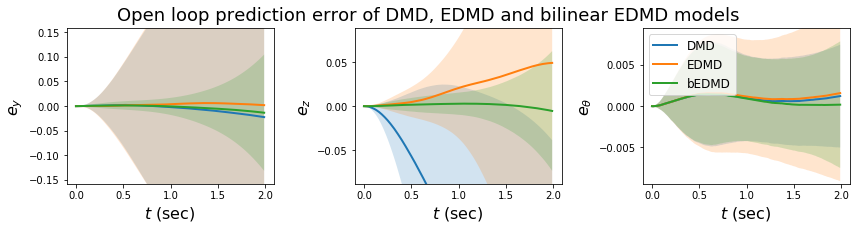

In [13]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 16
y_lim_gain = 1.2

#Plot open loop results:
ylabels = ['$e_{y}$', '$e_z$', '$e_{\\theta}$']
plt.figure(figsize=(figwidth,3))
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.plot(t_eval[:-1], error_dmd_mean[ii,:], linewidth=lw, label='DMD')
    plt.fill_between(t_eval[:-1], error_dmd_mean[ii,:] - error_dmd_std[ii,:], error_dmd_mean[ii,:] + error_dmd_std[ii,:], alpha=0.2)
    plt.plot(t_eval[:-1], error_edmd_mean[ii, :], linewidth=lw, label='EDMD')
    plt.fill_between(t_eval[:-1], error_edmd_mean[ii, :] - error_edmd_std[ii, :],error_edmd_mean[ii, :] + error_edmd_std[ii, :], alpha=0.2)
    plt.plot(t_eval[:-1], error_bedmd_mean[ii, :], linewidth=lw, label='bEDMD')
    plt.fill_between(t_eval[:-1], error_bedmd_mean[ii, :] - error_bedmd_std[ii, :],error_bedmd_mean[ii, :] + error_bedmd_std[ii, :], alpha=0.2)
    ylim = max(max(np.abs(error_bedmd_mean[ii, :] - error_bedmd_std[ii, :])), max(np.abs(error_bedmd_mean[ii, :] + error_bedmd_std[ii, :])))
    plt.ylim([-ylim * y_lim_gain, ylim * y_lim_gain])
    plt.xlabel('$t$ (sec)', fontsize=fs)
    plt.ylabel(ylabels[ii], fontsize=fs)

plt.legend(loc='upper left', fontsize=fs-4)
suptitle = plt.suptitle('Open loop prediction error of DMD, EDMD and bilinear EDMD models', y=1.05, fontsize=18)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig(folder_plots + 'planar_quad_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()


# Design trajectories based on learned models

We now study the closed loop performance of the control design. 

In [14]:
#Closed loop performance evaluation parameters:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
#QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
QN_mpc = Q_mpc
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation

ctrl_offset = np.array([hover_thrust, hover_thrust])

# Design trajectory:
x0_cl = np.array([0., 0., 0., 0., 0., 0.])                   # Initial value, closed loop trajectory
set_pt_cl = np.array([1.5, 0.5, 0., 0., 0., 0.])              # Desired final value, closed loop trajectory
xmax = np.array([2, 2, np.pi/3, 1.,1.,1.])                          # State constraints, trajectory generation
xmin = -xmax
term_constraint=True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0_cl, set_pt_cl, int(traj_length)+1)
u_init = np.zeros((m,traj_length)).T

#### Design controllers for learned DMD, EDMD, and bEDMD models

In [15]:
from koopman_core.controllers import MPCController, NonlinearMPCController, BilinearMPCController

# Define DMD-based controller:
controller_dmd = MPCController(sys_dmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCController(sys_bedmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)
z0_cl = sys_bedmd.basis(x0_cl.reshape((1,-1))).squeeze()
z_init = sys_bedmd.basis(x_init)
controller_bedmd.construct_controller(z_init, u_init)

#### Design controller using full knowledge of nonlinear controller

In [16]:
quadrotor_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCController(quadrotor_d, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init+hover_thrust)

#### Design trajectories with the contructed MPCs

In [17]:
max_iter = 50

controller_dmd.eval(x0_cl, 0)
xr_dmd = controller_dmd.parse_result()
ur_dmd = controller_dmd.get_control_prediction() + hover_thrust

controller_edmd.eval(x0_cl, 0)
xr_edmd = sys_edmd.C@controller_edmd.parse_result()
ur_edmd = controller_edmd.get_control_prediction() + hover_thrust

controller_bedmd.solve_to_convergence(z0_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = sys_bedmd.C@controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T + hover_thrust

/Users/carlaxelfolkestad/OneDrive - California Institute of Technology/Research/Learning to fly/Code/koopman-learning-control/koopman_core/controllers/nonlinear_mpc_controller.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  while (iter == 0 or np.linalg.norm(u_prev-self.cur_u)/np.linalg.norm(u_prev) > eps) and iter < max_iter:


In [18]:

controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init + ctrl_offset.reshape(1,-1), max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open loop

In [19]:
ol_controller_dmd = OpenLoopController(quadrotor, ur_dmd.T, t_eval[:-1])
xs_dmd, us_dmd = quadrotor.simulate(x0_cl, ol_controller_dmd, t_eval)
xs_dmd, us_dmd = xs_dmd.T, us_dmd.T

ol_controller_edmd = OpenLoopController(quadrotor, ur_edmd.T, t_eval[:-1])
xs_edmd, us_edmd = quadrotor.simulate(x0_cl, ol_controller_edmd, t_eval)
xs_edmd, us_edmd = xs_edmd.T, us_edmd.T

ol_controller_bedmd = OpenLoopController(quadrotor, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = quadrotor.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_nmpc = OpenLoopController(quadrotor, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = quadrotor.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

[ 1.60396621e-08  5.47749015e-10 -1.96203598e-04  6.41586482e-06
  1.09298387e-07 -3.92407197e-02]
[ 2.56634560e-07  2.13523461e-09 -7.84814128e-04  5.13269061e-05
  2.03667697e-07 -7.84813863e-02]
[ 1.29921215e-06  4.47722245e-09 -1.76583103e-03  1.73228245e-04
  2.44589557e-07 -1.17721995e-01]
[ 4.14837904e-06  1.95844957e-05 -3.13142248e-03  4.19823705e-04
  3.91570268e-03 -1.55396295e-01]
[ 1.02955766e-05  9.79201578e-05 -4.86591531e-03  8.40239897e-04
  1.17513078e-02 -1.91502271e-01]
[ 2.17334890e-05  2.73539297e-04 -6.95389476e-03  1.48552512e-03
  2.33722950e-02 -2.26093619e-01]
[ 4.08345152e-05  5.65729803e-04 -9.37331888e-03  2.37895280e-03
  3.50654455e-02 -2.57791205e-01]
[ 7.02395950e-05  9.73371732e-04 -1.20950370e-02  3.55173314e-03
  4.64624078e-02 -2.86552427e-01]
[ 1.12894851e-04  1.49351912e-03 -1.50902085e-02  5.03383219e-03
  5.75663304e-02 -3.12481865e-01]
[ 1.72029432e-04  2.12325633e-03 -1.83310307e-02  6.85191235e-03
  6.83801286e-02 -3.35682580e-01]
[ 2.511232

[0.74736823 0.3544466  0.03038634 0.81605783 0.26666957 0.16189886]
[0.75551397 0.35710229 0.03205418 0.81306368 0.26446755 0.17167028]
[0.76362898 0.3597354  0.03382027 0.80990838 0.26215431 0.18154613]
[0.77171158 0.36234484 0.03568528 0.80658273 0.25973308 0.19145717]
[0.77976004 0.36492955 0.03764926 0.8030775  0.25720734 0.20133916]
[0.78777251 0.3674885  0.03971164 0.7993835  0.25458037 0.21113559]
[0.79574705 0.37002068 0.0418713  0.79549163 0.25185521 0.22079682]
[0.80368166 0.37252514 0.04412668 0.79139294 0.24903453 0.23027886]
[0.8115742  0.37500092 0.04647578 0.78707867 0.24612078 0.23954166]
[0.81942249 0.37744712 0.04891622 0.78254027 0.24311628 0.24854675]
[0.82722424 0.37986283 0.05144524 0.77776943 0.24002332 0.25725722]
[0.83497708 0.38224717 0.05405972 0.77275814 0.2368441  0.26563769]
[0.84267858 0.38459931 0.05675618 0.76749869 0.23358074 0.27365432]
[0.85032621 0.3869184  0.05953082 0.76198371 0.23023532 0.28127478]
[0.85791738 0.38920364 0.06237954 0.75620622 0.2

[ 0.00219714  0.02492871 -0.0425539   0.03722191  0.20936752 -0.30001771]
[ 0.00259229  0.02705812 -0.0455673   0.04186179  0.21651146 -0.30266233]
[ 0.0030354   0.029258   -0.04860354  0.0468117   0.22346349 -0.30458564]
[ 0.00352955  0.03152646 -0.05165554  0.05207267  0.2302252  -0.30581462]
[ 0.00407787  0.03386159 -0.05471649  0.05764501  0.23679816 -0.30637588]
[ 0.00468347  0.03626152 -0.05777985  0.06352836  0.24318396 -0.30629564]
[ 0.00534946  0.03872437 -0.06083932  0.06972169  0.24938418 -0.30559976]
[ 0.00607892  0.04124831 -0.06388889  0.07622335  0.25540045 -0.30431372]
[ 0.00687493  0.0438315  -0.06692277  0.08303111  0.26123438 -0.30246258]
[ 0.00774053  0.04647213 -0.06993544  0.09014216  0.26688764 -0.30007107]
[ 0.00867875  0.0491684  -0.07292161  0.09755318  0.27236191 -0.2971635 ]
[ 0.00969256  0.05191852 -0.07587625  0.10526032  0.27765893 -0.2937638 ]
[ 0.01078491  0.05472074 -0.07879455  0.11325929  0.28278044 -0.28989554]
[ 0.01195869  0.0575733  -0.08167193  

[ 1.0728922   0.45977599 -0.02901755  1.30189238  0.18635072  0.11958909]
[ 1.08592473  0.46162433 -0.02780628  1.30459436  0.18331692  0.12266513]
[ 1.0989837   0.46344232 -0.02656408  1.30717963  0.18028303  0.12577381]
[ 1.11206793  0.46522999 -0.0252907   1.30964531  0.17725156  0.12890295]
[ 1.1251762   0.46698737 -0.02398598  1.31198849  0.17422499  0.13204073]
[ 1.13830728  0.46871453 -0.0226499   1.31420623  0.17120576  0.1351757 ]
[ 1.15145989  0.47041153 -0.02128254  1.31629559  0.16819626  0.1382968 ]
[ 1.16463275  0.47207851 -0.01988409  1.31825364  0.1651988   0.14139329]
[ 1.17782452  0.47371558 -0.01845485  1.32007744  0.16221567  0.14445485]
[ 1.19103384  0.4753229  -0.01699521  1.3217641   0.15924907  0.1474715 ]
[ 1.20425934  0.47690065 -0.01550569  1.32331074  0.15630111  0.15043364]
[ 1.21749958  0.47844902 -0.01398686  1.32471451  0.15337385  0.15333203]
[ 1.23075314  0.47996823 -0.01243941  1.32597264  0.15046924  0.15615781]
[ 1.24401854  0.48145852 -0.01086411  

[ 0.11535104  0.21404951 -0.16217755  0.64633833  0.99372167  0.13803042]
[ 0.1218984   0.22401103 -0.160694    0.66310821  0.99858604  0.15867902]
[ 0.12861106  0.2340114  -0.15900823  0.67939483  1.00149236  0.1784751 ]
[ 0.1354841   0.244031   -0.15712889  0.69518341  1.00243341  0.19739173]
[ 0.14251311  0.25405407 -0.15506491  0.71058464  1.00218575  0.21540574]
[ 0.14969506  0.26407459 -0.15282539  0.72576787  1.00192369  0.23249692]
[ 0.15702769  0.27409251 -0.15041967  0.74071922  1.00166706  0.24864866]
[ 0.1645086   0.28410786 -0.14785718  0.75542152  1.00140824  0.2638478 ]
[ 0.17213523  0.29412062 -0.14514752  0.76986034  1.00115097  0.27808437]
[ 0.17990487  0.30413082 -0.14230034  0.78402169  1.00089563  0.29135129]
[ 0.18781468  0.31413845 -0.13932537  0.7978917   1.00063611  0.30364415]
[ 0.19586169  0.32414346 -0.13623234  0.81145858  1.00037396  0.31496097]
[ 0.2040428   0.33414587 -0.13303103  0.82471208  1.00011482  0.325302  ]
[ 0.21235484  0.34414568 -0.12973117  

[ 1.56493855  0.54222154  0.15019653  0.57843503 -0.62478737 -0.10172068]
[ 1.57063018  0.53609733  0.14906432  0.55991403 -0.6000502  -0.12472069]
[ 1.57613643  0.53022668  0.14770196  0.54136489 -0.57407684 -0.14775191]
[ 1.58145727  0.52462143  0.14610946  0.52283494 -0.54696713 -0.17074775]
[ 1.58659311  0.51929242  0.14428752  0.50437293 -0.5188286  -0.19363879]
[ 1.59154491  0.51424937  0.14223757  0.48602866 -0.48977635 -0.21635279]
[ 1.59631407  0.50950079  0.13996173  0.46785266 -0.45993277 -0.23881472]
[ 1.60090254  0.50505395  0.13746292  0.44989578 -0.42942735 -0.26094682]
[ 1.60531277  0.50091479  0.13474484  0.43220883 -0.39839631 -0.28266868]
[ 1.60954771  0.49708786  0.13181201  0.41484213 -0.36698225 -0.30389725]
[ 1.61361081  0.49357623  0.12866979  0.39784509 -0.33533372 -0.32454698]
[ 1.617506    0.49038149  0.12532441  0.38126577 -0.30360471 -0.34452986]
[ 1.6212377   0.48750365  0.12178298  0.36515041 -0.27195405 -0.36375557]
[ 1.62481076  0.48494111  0.11805355  

[ 0.33700483  0.47750698 -0.06761253  0.93722421  0.93292178  0.35940484]
[ 0.34640594  0.48677972 -0.0640396   0.94294639  0.92162962  0.35518017]
[ 0.35586256  0.49593701 -0.06051266  0.94832756  0.90983197  0.35020919]
[ 0.36537135  0.5049742  -0.05703904  0.95338052  0.8976098   0.34451516]
[ 0.37492908  0.51388745 -0.05362585  0.95811756  0.88504131  0.33812292]
[ 0.38453266  0.52267365 -0.05027994  0.96255056  0.87220157  0.3310589 ]
[ 0.3941791   0.53133046 -0.04700789  0.96669097  0.85916221  0.32335118]
[ 0.40386553  0.53985621 -0.04381598  0.97054982  0.84599113  0.31502947]
[ 0.41358919  0.54824992 -0.04071021  0.97413781  0.83275223  0.30612514]
[ 0.42334742  0.5565112  -0.03769623  0.97746536  0.81950517  0.29667125]
[ 0.43313767  0.56464024 -0.03477936  0.98054259  0.80630511  0.28670255]
[ 0.44295747  0.57263777 -0.03196457  0.98337943  0.79320252  0.27625552]
[ 0.45280449  0.580505   -0.02925645  0.98598566  0.78024301  0.2653684 ]
[ 0.46267646  0.58824354 -0.0266592   

[ 1.38321769  0.65681893  0.15784772  0.67246904 -0.83826142  0.14866986]
[ 1.38986172  0.64845098  0.15923788  0.65631417 -0.8353311   0.12936232]
[ 1.3963419   0.64012241  0.16043177  0.63970067 -0.83038698  0.10941527]
[ 1.40265371  0.63185335  0.16142316  0.6226444  -0.82342757  0.08886228]
[ 1.40879283  0.62366393  0.16220617  0.60516446 -0.81445945  0.06773974]
[ 1.41475512  0.61557415  0.1627753   0.58728326 -0.80349756  0.0460869 ]
[ 1.4205367   0.60760384  0.16312546  0.56902656 -0.79056537  0.023946  ]
[ 1.42613396e+00  5.99772539e-01  1.63252005e-01  5.50423496e-01
 -7.75695130e-01  1.36229532e-03]
[ 1.4315436   0.59209942  0.16315074  0.53150654 -0.75892805 -0.02161584]
[ 1.43676266  0.5846032   0.16281797  0.51231148 -0.74031447 -0.04493691]
[ 1.44178855  0.57730205  0.16225056  0.49287728 -0.71991397 -0.06854617]
[ 1.44661908  0.57021349  0.1614459   0.47324599 -0.69779552 -0.09238565]
[ 1.45125252  0.56335431  0.160402    0.45346257 -0.67403753 -0.1163941 ]
[ 1.45568757 

##### Compare performance

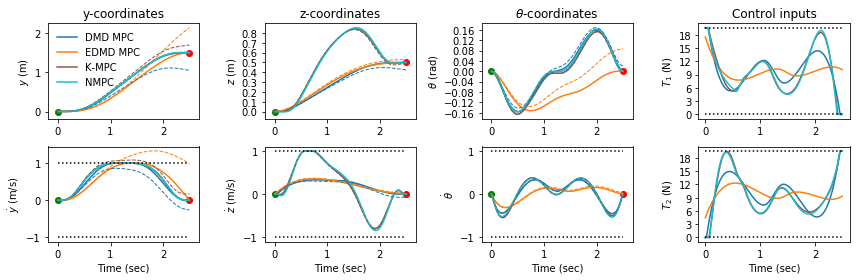

Solution statistics:

                       Normalized cost,    Realized terminal,  # of SQP      Mean comp. time           Total comp.
                    designed trajectory                 error  iterations    per iteration (secs)      time (secs)
----------------  ---------------------  --------------------  ------------  ----------------------  -------------
DMD MPC                          0.92                  0.532   -             -                             0.21783
EDMD MPC                         0.8292                1.1765  -             -                             2.102
bEDMD MPC                        0.9987                0.2579  16            1.4716                       23.5456
NMPC (benchmark)                 1                     0.0174  8             0.1449                        1.15894


In [63]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plot_inds = [0, 1, 2, 3, 4, 5, 0, 1]
subplot_inds = [1, 2, 3, 5, 6, 7, 4, 8]
labels = ['$y$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{y}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
titles = ['y-coordinates', 'z-coordinates', '$\\theta$-coordinates', 'Control inputs']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:cyan']

plt.figure(figsize=(12,4))
#plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval, xr_dmd[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval, xr_edmd[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval, xr_bedmd[ind, :], colors[2], label='K-MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[3], label='NMPC')

        plt.plot(t_eval, xs_dmd[ind,:], '--', color=colors[0], linewidth=1)
        plt.plot(t_eval, xs_edmd[ind, :], '--', color=colors[1], linewidth=1)
        plt.plot(t_eval, xs_bedmd[ind, :], '--', color=colors[2], linewidth=1)
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[3], linewidth=1)

        plt.scatter(t_eval[0], x0_cl[ind], color='g')
        plt.scatter(t_eval[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if ii >= 3:
            plt.plot([0, t_eval[-1]], [xmax[ind], xmax[ind]], ':k')
            plt.plot([0, t_eval[-1]], [xmin[ind], xmin[ind]], ':k')
            #plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    elif ii < 8:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_dmd[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval[:-1], ur_edmd[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval[:-1], ur_bedmd[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] > 4:
        plt.xlabel('Time (sec)')
    else:
        plt.title(titles[subplot_inds[ii]-1])

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_trajectory.pdf', format='pdf', dpi=2400)
plt.show()

cost_ref_dmd = (xr_dmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_dmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_dmd.T@R_mpc@ur_dmd))
cost_ref_edmd = (xr_edmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_edmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_edmd.T@R_mpc@ur_edmd))
cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

dist_ol_dmd = np.linalg.norm(xs_dmd[:,-1] - set_pt_cl)
dist_ol_edmd = np.linalg.norm(xs_edmd[:,-1] - set_pt_cl)
dist_ol_bedmd = np.linalg.norm(xs_bedmd[:,-1] - set_pt_cl)
dist_ol_nmpc = np.linalg.norm(xs_nmpc[:,-1] - set_pt_cl)

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_ref_dmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_dmd), '-','-',sum(controller_dmd.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_ref_edmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_edmd),'-','-',sum(controller_edmd.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_bedmd), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(dist_ol_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Realized terminal,\nerror', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

In [21]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(quadrotor, u_init, t_eval[:-1])
xs_init, _ = quadrotor.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T+hover_thrust
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_nmpc = [init_cost]
iter_norm_dist_bedmd = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_nmpc = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T+hover_thrust
    ol_controller_bedmd_iter = OpenLoopController(quadrotor, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = quadrotor.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    iter_norm_dist_bedmd.append(np.linalg.norm(xs_bedmd_iter[:,-1]-set_pt_cl))
    
for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(quadrotor, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = quadrotor.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))
    iter_norm_dist_nmpc.append(np.linalg.norm(xs_nmpc_iter[:,-1]-set_pt_cl))

[ 0.        -0.0004905  0.         0.        -0.0981     0.       ]
[ 0.       -0.001962  0.        0.       -0.1962    0.      ]
[ 0.        -0.0044145  0.         0.        -0.2943     0.       ]
[ 0.       -0.007848  0.        0.       -0.3924    0.      ]
[ 0.        -0.0122625  0.         0.        -0.4905     0.       ]
[ 0.       -0.017658  0.        0.       -0.5886    0.      ]
[ 0.        -0.0240345  0.         0.        -0.6867     0.       ]
[ 0.       -0.031392  0.        0.       -0.7848    0.      ]
[ 0.        -0.0397305  0.         0.        -0.8829     0.       ]
[ 0.      -0.04905  0.       0.      -0.981    0.     ]
[ 0.        -0.0593505  0.         0.        -1.0791     0.       ]
[ 0.       -0.070632  0.        0.       -1.1772    0.      ]
[ 0.        -0.0828945  0.         0.        -1.2753     0.       ]
[ 0.       -0.096138  0.        0.       -1.3734    0.      ]
[ 0.        -0.1103625  0.         0.        -1.4715     0.       ]
[ 0.       -0.125568  0.    

[  0.        -18.2706345   0.          0.        -18.9333      0.       ]
[  0.       -18.460458   0.         0.       -19.0314     0.      ]
[  0.        -18.6512625   0.          0.        -19.1295      0.       ]
[  0.       -18.843048   0.         0.       -19.2276     0.      ]
[  0.        -19.0358145   0.          0.        -19.3257      0.       ]
[  0.       -19.229562   0.         0.       -19.4238     0.      ]
[  0.        -19.4242905   0.          0.        -19.5219      0.       ]
[  0.   -19.62   0.     0.   -19.62   0.  ]
[  0.        -19.8166905   0.          0.        -19.7181      0.       ]
[  0.       -20.014362   0.         0.       -19.8162     0.      ]
[  0.        -20.2130145   0.          0.        -19.9143      0.       ]
[  0.       -20.412648   0.         0.       -20.0124     0.      ]
[  0.        -20.6132625   0.          0.        -20.1105      0.       ]
[  0.       -20.814858   0.         0.       -20.2086     0.      ]
[  0.        -21.0174345   0. 

[ 0.08243259  0.06632235 -0.12880393  0.41782842  0.18661261 -0.07762202]
[ 0.08667575  0.06819787 -0.1295393   0.43081559  0.18848945 -0.06945294]
[ 0.09104912  0.07009203 -0.13019311  0.44387013  0.19034142 -0.06130834]
[ 0.09555334  0.07200459 -0.13076564  0.45698388  0.19216953 -0.05319776]
[ 0.10018896  0.07393532 -0.13125728  0.4701487   0.19397483 -0.04513047]
[ 0.10495646  0.07588399 -0.13166851  0.48335653  0.19575835 -0.03711545]
[ 0.10985621  0.07785039 -0.1319999   0.49659934  0.19752112 -0.0291614 ]
[ 0.11488853  0.07983432 -0.13225209  0.50986918  0.19926421 -0.02127673]
[ 0.12005365  0.08183558 -0.13242582  0.52315817  0.20098865 -0.0134696 ]
[ 0.12535173  0.08385401 -0.13252191  0.53645851  0.20269548 -0.00574784]
[ 0.13078283  0.08588941 -0.13254124  0.54976249  0.20438573  0.00188097]
[ 0.13634696  0.08794164 -0.13248479  0.56306251  0.20606043  0.00940953]
[ 0.14204404  0.09001055 -0.13235359  0.57635106  0.20772059  0.01683084]
[ 0.14787391  0.09209598 -0.13214874  

[1.3444112  0.42452778 0.04569286 1.17774047 0.36316276 0.19762269]
[1.35616571 0.42816249 0.04766966 1.17312895 0.36377857 0.19773721]
[1.36787313 0.43180324 0.04964702 1.16832304 0.36436907 0.19773322]
[1.37953153 0.43544976 0.05162372 1.16332282 0.3649339  0.19760819]
[1.39113894 0.4391018  0.05359856 1.15812851 0.36547267 0.1973599 ]
[1.40269345 0.4427591  0.05557029 1.15274043 0.36598504 0.19698639]
[1.41419311 0.44642139 0.05753766 1.14715903 0.36647065 0.19648599]
[1.42563599 0.4500884  0.05949937 1.14138489 0.36692916 0.19585732]
[1.43702017 0.45375985 0.06145416 1.13541871 0.36736024 0.19509928]
[1.44834373 0.45743548 0.06340071 1.12926132 0.36776359 0.19421105]
[1.45960476 0.461115   0.06533772 1.12291369 0.36813891 0.19319211]
[1.47080137 0.46479814 0.0672639  1.1163769  0.36848591 0.19204221]
[1.48193168 0.4684846  0.06917791 1.10965216 0.36880433 0.19076138]
[1.4929938  0.4721741  0.07107847 1.10274083 0.36909393 0.18934996]
[1.50398588 0.47586636 0.07296426 1.09564437 0.3

[ 0.16963004  0.33886545 -0.140129    0.71646394  0.99644512  0.12534512]
[ 0.17686553  0.34884324 -0.13882991  0.73061206  0.99911605  0.1344741 ]
[ 0.18424119  0.3588432  -0.13744146  0.74449591  1.00087939  0.14321582]
[ 0.19175433  0.36885623 -0.13596754  0.75810841  1.00172937  0.15156789]
[ 0.19940233  0.37887398 -0.13441206  0.77146555  1.00182467  0.15952852]
[ 0.20718285  0.38889082 -0.13277893  0.78461287  1.00154525  0.16709649]
[ 0.21509408  0.39890529 -0.13107209  0.79760549  1.00135321  0.17427107]
[ 0.22313447  0.40891854 -0.12929548  0.81044287  1.00130091  0.18105194]
[ 0.23130238  0.41893163 -0.12745302  0.82310903  1.00132006  0.18743917]
[ 0.23959604  0.42894502 -0.12554866  0.83559141  1.00136355  0.19343325]
[ 0.24801358  0.43895899 -0.12358632  0.84788426  1.00143312  0.19903502]
[ 0.2565531   0.44897404 -0.12156992  0.85998842  1.00158103  0.20424572]
[ 0.26521275  0.45899131 -0.11950335  0.87190698  1.00187751  0.20906688]
[ 0.27399057  0.4690118  -0.11739052  

[ 1.55184862  0.83746846  0.09841081  0.94106592 -0.49741476  0.06570851]
[ 1.56121485  0.83245281  0.09901752  0.93217196 -0.50571713  0.05563194]
[ 1.57049152  0.8273578   0.09952262  0.92315434 -0.51328437  0.04538956]
[ 1.57967742  0.82219093  0.09992458  0.91401907 -0.52009027  0.03500204]
[ 1.5887714   0.81695994  0.10022205  0.90477249 -0.52610903  0.02449095]
[ 1.59777238  0.81167282  0.10041389  0.89542136 -0.53131524  0.01387882]
[ 1.60667936  0.80633782  0.10049923  0.88597279 -0.53568397  0.0031891 ]
[ 1.6154914   0.80096345  0.10047741  0.8764343  -0.53919074 -0.00755385]
[ 1.62420763  0.79555844  0.10034802  0.86681376 -0.54181163 -0.01832476]
[ 1.63282727  0.79013176  0.10011091  0.85711945 -0.54352327 -0.02909744]
[ 1.64134964  0.78469263  0.0997662   0.84736    -0.54430286 -0.03984478]
[ 1.64977413  0.77925047  0.09931428  0.8375444  -0.54412825 -0.05053878]
[ 1.65810021  0.77381493  0.09875583  0.827682   -0.54297795 -0.06115055]
[ 1.66632748  0.76839588  0.09809183  

[ 0.10174837  0.21886689 -0.1585094   0.57876239  0.96273899  0.0182774 ]
[ 0.10762218  0.22854321 -0.15823246  0.59599468  0.97252659  0.03711178]
[ 0.1136671   0.238311   -0.15776833  0.61298177  0.98103272  0.05571407]
[ 0.11988058  0.24815737 -0.15711955  0.62970216  0.98824241  0.07404167]
[ 0.12625984  0.25806929 -0.15628908  0.64613594  0.9941437   0.09205219]
[ 0.13280193  0.26803363 -0.1552803   0.66226474  0.99872759  0.10970367]
[ 0.13950372  0.27803719 -0.15409701  0.6780718   1.00198799  0.12695479]
[ 0.1463619   0.28806672 -0.15274341  0.69354198  1.00392162  0.14376503]
[ 0.15337304  0.29810895 -0.15122411  0.70866171  1.00452801  0.16009491]
[ 0.1605339   0.30815274 -0.1495441   0.72348327  1.00423325  0.17590614]
[ 0.16784212  0.3181936  -0.14770876  0.7381298   1.00394404  0.19116186]
[ 0.17529593  0.32823206 -0.14572382  0.75259965  1.00375175  0.20582677]
[ 0.18289345  0.33826884 -0.14359535  0.76687109  1.00360996  0.21986736]
[ 0.19063262  0.34830425 -0.14132975  

[ 1.39267639  0.77029717  0.10504281  0.93533587 -0.48039794  0.23841234]
[ 1.40198288  0.76544387  0.10738522  0.92592834 -0.49026553  0.23006975]
[ 1.41119381  0.76049613  0.1096414   0.91622317 -0.49928543  0.22116531]
[ 1.4203062   0.75546257  0.11180578  0.90622154 -0.50743163  0.21171017]
[ 1.42931709  0.75035203  0.11387291  0.89592541 -0.51468008  0.20171669]
[ 1.43822355  0.7451736   0.11583749  0.88533759 -0.52100879  0.19119845]
[ 1.44702269  0.73993658  0.11769433  0.87446179 -0.52639792  0.1801702 ]
[ 1.45571165  0.73465046  0.11943842  0.86330266 -0.53082986  0.16864788]
[ 1.46428762  0.72932488  0.1210649   0.85186584 -0.53428932  0.15664867]
[ 1.47274786  0.72396963  0.1225691   0.84015801 -0.53676343  0.14419092]
[ 1.4810897   0.71859462  0.12394653  0.8281869  -0.53824178  0.13129421]
[ 1.48931054  0.71320984  0.12519289  0.81596136 -0.53871653  0.11797936]
[ 1.49740789  0.70782536  0.12630413  0.80349133 -0.53818242  0.10426843]
[ 1.50537937  0.70245127  0.1272764   

[ 0.17446772  0.31983844 -0.14344615  0.75592426  1.00357718  0.22941729]
[ 0.18209734  0.32987365 -0.14108959  0.76996158  1.0034716   0.24189396]
[ 0.18986612  0.33990767 -0.13861174  0.78375325  1.00333793  0.253675  ]
[ 0.19777154  0.34994022 -0.1360196   0.79728791  1.00317706  0.26475387]
[ 0.205811    0.35997122 -0.13332021  0.81056022  1.00302852  0.2751242 ]
[ 0.21398187  0.37000107 -0.13052069  0.82356725  1.00294741  0.28477968]
[ 0.22228144  0.38003046 -0.12762822  0.83629971  1.00293757  0.29371396]
[ 0.23070683  0.39005939 -0.12465005  0.84873012  1.00285423  0.30192053]
[ 0.2392546   0.40008399 -0.12159348  0.86077357  1.00207184  0.30939272]
[ 0.24792056  0.41009483 -0.1184659   0.8723685   1.00010343  0.31612373]
[ 0.25670026  0.42008032 -0.11527475  0.88352201  0.9969994   0.32210701]
[ 0.26558934  0.43002935 -0.11202753  0.89424196  0.99281261  0.32733657]
[ 0.27458348  0.43993137 -0.10873181  0.90453683  0.98759815  0.33180651]
[ 0.2836785   0.4497764  -0.10539523  

[ 1.509786    0.68050658  0.13641802  0.74926391 -0.64683714  0.06572891]
[ 1.51720664  0.6740714   0.13699096  0.73485465 -0.64020104  0.04885842]
[ 1.524482    0.66770922  0.13739351  0.72020987 -0.63223643  0.03165111]
[ 1.53160982  0.66143324  0.13762247  0.70534938 -0.62295999  0.01414177]
[ 1.53858804  0.65525647  0.13767502  0.69029466 -0.61239289 -0.00363292]
[ 1.54541485  0.6491917   0.13754868  0.67506881 -0.60056089 -0.02163445]
[ 1.55208865  0.64325142  0.13724139  0.65969652 -0.58749432 -0.03982235]
[ 1.55860811  0.63744781  0.13675151  0.64420397 -0.57322809 -0.0581543 ]
[ 1.56497216  0.63179265  0.13607781  0.62861874 -0.55780171 -0.07658602]
[ 1.57118002  0.62629733  0.13521952  0.61296976 -0.54125925 -0.0950713 ]
[ 1.5772312   0.62097278  0.13417636  0.5972871  -0.5236493  -0.11356197]
[ 1.58312552  0.61582939  0.13294851  0.58160191 -0.50502493 -0.13200789]
[ 1.58886313  0.61087703  0.13153668  0.56594624 -0.48544359 -0.15035698]
[ 1.59444447  0.60612495  0.12994212  

[ 0.30023334  0.45280521 -0.0968035   0.93627892  0.96654641  0.35111778]
[ 0.30963905  0.46242756 -0.09329268  0.94480968  0.95792808  0.3510459 ]
[ 0.31912813  0.47196    -0.08978637  0.95295529  0.94856467  0.35021567]
[ 0.3286968   0.4813954  -0.08629206  0.96072759  0.93851994  0.34864629]
[ 0.33834138  0.49072726 -0.08281704  0.96813833  0.92785744  0.34635764]
[ 0.34805832  0.49994973 -0.0793684   0.97519915  0.91664014  0.34337029]
[ 0.35784417  0.50905756 -0.07595302  0.98192151  0.90493014  0.33970555]
[ 0.3676956   0.51804614 -0.07257757  0.98831668  0.89278839  0.33538547]
[ 0.3776094   0.52691144 -0.06924848  0.99439568  0.88027439  0.33043291]
[ 0.38758246  0.53565002 -0.06597195  1.00016931  0.86744589  0.32487158]
[ 0.39761178  0.54425903 -0.06275397  1.00564811  0.85435865  0.3187261 ]
[ 0.40769445  0.55273614 -0.05960022  1.01084239  0.84106618  0.31202206]
[ 0.41782769  0.56107956 -0.05651618  1.01576223  0.82761955  0.30478609]
[ 0.4280088   0.56928798 -0.05350702  

[ 1.58111487  0.58220703  0.13656952  0.57859698 -0.5238711  -0.1254918 ]
[ 1.58681917  0.57707402  0.13521719  0.56229004 -0.50272705 -0.14497505]
[ 1.59236064  0.57215708  0.13367054  0.54603402 -0.48065801 -0.16435428]
[ 1.59773996  0.56746506  0.13193092  0.52986583 -0.45774154 -0.18357081]
[ 1.60295821  0.56300602  0.13000024  0.51382287 -0.43406009 -0.2025637 ]
[ 1.60801682  0.55878719  0.12788108  0.49794286 -0.40970085 -0.22126984]
[ 1.61291762  0.55481488  0.12557661  0.48226353 -0.38475545 -0.23962393]
[ 1.61766279  0.55109447  0.1230907   0.46682238 -0.3593198  -0.2575585 ]
[ 1.62225491  0.54763037  0.12042788  0.45165639 -0.33349371 -0.27500395]
[ 1.62669691  0.54442596  0.11759342  0.43680174 -0.30738061 -0.29188857]
[ 1.63099207  0.54148359  0.11459329  0.42229355 -0.28108715 -0.30813856]
[ 1.63514404  0.5388045   0.1114342   0.40816554 -0.25472275 -0.3236781 ]
[ 1.63915678  0.53638885  0.10812367  0.39444976 -0.22839916 -0.33842938]
[ 1.64303455  0.53423567  0.10466995  

[ 0.30241184  0.45186983 -0.09536114  0.93877066  0.96201323  0.35504198]
[ 0.31184163  0.46144499 -0.0918122   0.94713467  0.95302416  0.35474662]
[ 0.32135315  0.47092676 -0.08827008  0.95511673  0.94333439  0.3536758 ]
[ 0.33094263  0.48030846 -0.08474246  0.9627287   0.93300956  0.35184872]
[ 0.34060644  0.48958406 -0.08123679  0.96998226  0.92211434  0.34928554]
[ 0.35034105  0.49874817 -0.07776033  0.97688894  0.91071225  0.34600736]
[ 0.36014304  0.50779604 -0.07432011  0.98346003  0.89886533  0.34203613]
[ 0.37000912  0.51672352 -0.07092295  0.98970658  0.88663388  0.33739471]
[ 0.37993608  0.52552705 -0.06757545  0.99563944  0.87407629  0.3321068 ]
[ 0.38992086  0.53420366 -0.06428393  1.00126916  0.86124876  0.32619702]
[ 0.39996047  0.54275092 -0.06105449  1.0066061   0.84820513  0.3196909 ]
[ 0.41005202  0.55116691 -0.05789296  1.01166038  0.83499669  0.31261497]
[ 0.42019275  0.55945024 -0.0548049   1.0164419   0.82167205  0.3049968 ]
[ 0.43037998  0.56759998 -0.05179559  

[ 1.60661646  0.54503903  0.12932291  0.48351444 -0.40258783 -0.23340348]
[ 1.61137114  0.54114525  0.12689411  0.46747171 -0.37616148 -0.25235587]
[ 1.61596669  0.53751794  0.12427804  0.4516926  -0.34929446 -0.27085824]
[ 1.62040594  0.53416094  0.12147956  0.43621642 -0.32209773 -0.28883732]
[ 1.62469212  0.53107699  0.11850429  0.4210815  -0.29468615 -0.30621765]
[ 1.62882882  0.52826763  0.11535859  0.40632489 -0.2671781  -0.32292174]
[ 1.63282001  0.52573322  0.11204963  0.39198202 -0.23969497 -0.33887002]
[ 1.63666999  0.5234729   0.10858538  0.37808641 -0.2123606  -0.35398099]
[ 1.64038339  0.52148456  0.10497462  0.36466931 -0.18530073 -0.36817125]
[ 1.64396514  0.5197648   0.10122698  0.35175946 -0.15864229 -0.38135556]
[ 1.64742045  0.51830899  0.09735297  0.33938275 -0.13251275 -0.39344697]
[ 1.65075477  0.51711119  0.09336395  0.327562   -0.10703927 -0.40435687]
[ 1.65397374  0.51616421  0.08927219  0.31631666 -0.08234793 -0.41399509]
[ 1.65708321  0.51545962  0.08509086  

[ 0.3810373   0.52436694 -0.0670995   0.99660432  0.86978783  0.33227807]
[ 0.39103148  0.53299999 -0.06380641  1.0021844   0.85682577  0.32634039]
[ 0.40108     0.54150243 -0.06057569  1.00747327  0.84366587  0.31980231]
[ 0.41117999  0.54987254 -0.05741323  1.01248092  0.8303593   0.31268976]
[ 0.4213287   0.5581091  -0.05432463  1.01721713  0.81695437  0.30503   ]
[ 0.43152346  0.56621134 -0.05131523  1.0216915   0.80349642  0.29685168]
[ 0.44176169  0.57417895 -0.04839004  1.02591348  0.79002763  0.28818488]
[ 0.45204092  0.58201202 -0.04555381  1.02989237  0.77658695  0.27906118]
[ 0.46235876  0.58971099 -0.04281094  1.0336374   0.76321     0.26951369]
[ 0.47271292  0.59727668 -0.04016548  1.03715771  0.74992899  0.25957711]
[ 0.4831012   0.60471018 -0.03762116  1.04046238  0.73677265  0.24928778]
[ 0.49352149  0.61201287 -0.0351813   1.04356051  0.72376623  0.2386837 ]
[ 0.50397176  0.61918635 -0.03284886  1.04646116  0.71093141  0.22780461]
[ 0.5144501   0.62623244 -0.03062638  

[ 1.62721651  0.5244678   0.11520518  0.39790061 -0.24820608 -0.32974339]
[ 1.63112325  0.52212591  0.11182749  0.38351781 -0.22016326 -0.34579564]
[ 1.63488846  0.52006338  0.10829356  0.36960021 -0.1923348  -0.36098943]
[ 1.63851698  0.5182774   0.10461241  0.35617937 -0.16485264 -0.37523992]
[ 1.6420139   0.51676385  0.10079391  0.34328416 -0.13784989 -0.38846052]
[ 1.64538461  0.51551726  0.0968488   0.33094044 -0.11146001 -0.40056292]
[ 1.64863475  0.51453084  0.09278869  0.31917076 -0.08581603 -0.41145728]
[ 1.65177015  0.51379647  0.08862615  0.30799421 -0.06104961 -0.42105226]
[ 1.65479682  0.51330474  0.08437461  0.29742611 -0.03729009 -0.42925516]
[ 1.6577209   0.51304493  0.08004847  0.28747788 -0.01466347 -0.43597205]
[ 1.66054864  0.51300512  0.07566307  0.27815693  0.00670867 -0.44110785]
[ 1.66328632  0.51317219  0.0712347   0.26946652  0.02671038 -0.44456647]
[ 1.66594025  0.51353187  0.06678062  0.26140574  0.04523247 -0.44625097]
[ 1.6685167   0.51406888  0.06231904  

[ 0.31747138  0.46512921 -0.08794068  0.95573567  0.9565577   0.36880827]
[ 0.32706728  0.47464759 -0.08426235  0.96338868  0.94712315  0.36685614]
[ 0.33673778  0.4840683  -0.0806075   0.97065935  0.93702473  0.36411488]
[ 0.34647915  0.49338507 -0.0769839   0.97756074  0.92633251  0.3606048 ]
[ 0.35628774  0.50259229 -0.07339914  0.98410561  0.91511514  0.35634727]
[ 0.36616005  0.51168504 -0.06986058  0.99030642  0.90343946  0.35136474]
[ 0.37609271  0.52065908 -0.06637535  0.99617534  0.89137031  0.34568078]
[ 0.38608246  0.52951076 -0.06295035  1.00172422  0.87897024  0.33932015]
[ 0.39612614  0.5382371  -0.0595922   1.00696463  0.86629929  0.33230883]
[ 0.40622073  0.54683565 -0.05630729  1.01190783  0.85341475  0.3246741 ]
[ 0.41636333  0.55530457 -0.05310169  1.01656485  0.84037097  0.31644459]
[ 0.4265511   0.56364251 -0.04998122  1.02094646  0.8272192   0.30765035]
[ 0.43678137  0.57184863 -0.04695135  1.02506324  0.81400744  0.29832289]
[ 0.44705152  0.57992256 -0.04401726  

[ 1.53142646  0.60231995  0.14988794  0.67825235 -0.71820922  0.01466293]
[ 1.53812396  0.59521022  0.14992952  0.66124725 -0.70373722 -0.00634834]
[ 1.54465029  0.58825277  0.14975945  0.64402093 -0.68775135 -0.02766584]
[ 1.55100338  0.58146251  0.14937491  0.62660599 -0.67029941 -0.04924081]
[ 1.55718154  0.57485383  0.1487736   0.60903726 -0.65143593 -0.07102192]
[ 1.5631834   0.56844053  0.14795371  0.59135166 -0.63122226 -0.09295526]
[ 1.569008    0.56223577  0.14691401  0.57358807 -0.60972649 -0.11498429]
[ 1.57465475  0.556252    0.14565384  0.55578713 -0.58702349 -0.13704986]
[ 1.58012349  0.55050089  0.14417314  0.53799099 -0.56319479 -0.15909023]
[ 1.58541449  0.54499324  0.14247249  0.52024315 -0.53832851 -0.18104104]
[ 1.59052844  0.53973898  0.14055311  0.50258812 -0.51251926 -0.20283533]
[ 1.59546652  0.53474701  0.13841691  0.48507115 -0.48586794 -0.2244036 ]
[ 1.60023032  0.53002523  0.13606652  0.46773797 -0.45848154 -0.24567378]
[ 1.60482191  0.52558042  0.1335053   

[ 0.30907516  0.45262533 -0.09156529  0.94983153  0.95831397  0.37015744]
[ 0.31861362  0.46216114 -0.08786942  0.95780528  0.94885275  0.36901774]
[ 0.32822987  0.47159893 -0.08418896  0.96539086  0.93871121  0.36707389]
[ 0.3379201   0.48093228 -0.08053187  0.97260126  0.92796255  0.3643445 ]
[ 0.34768061  0.49015547 -0.0769059   0.97944921  0.91667842  0.36084919]
[ 0.35750785  0.49926348 -0.07331861  0.98594708  0.90492861  0.35660866]
[ 0.36739838  0.50825201 -0.06977734  0.99210695  0.8927808   0.35164466]
[ 0.37734886  0.5171174  -0.06628922  0.99794051  0.88030019  0.34598015]
[ 0.38735611  0.52585663 -0.06286112  1.00345917  0.86754934  0.33963929]
[ 0.39741701  0.5344673  -0.05949969  1.00867399  0.85458787  0.33264751]
[ 0.40752859  0.54294759 -0.05621129  1.01359575  0.84147225  0.32503161]
[ 0.41768797  0.55129622 -0.05300204  1.01823498  0.82825565  0.31681982]
[ 0.42789238  0.55951242 -0.04987773  1.02260197  0.81498773  0.30804183]
[ 0.43813914  0.56759592 -0.04684387  

[ 1.59207875  0.53821968  0.13932092  0.49877304 -0.45952408 -0.20493441]
[ 1.59697799  0.53376824  0.13716362  0.48111989 -0.43075812 -0.22652513]
[ 1.60170166  0.52960792  0.1347919   0.46366478 -0.40129969 -0.24781747]
[ 1.60625198  0.52574502  0.13220914  0.44645519 -0.37127306 -0.26873601]
[ 1.61063165  0.52218457  0.12941944  0.42953827 -0.34080845 -0.2892028 ]
[ 1.61484382  0.51893028  0.12642774  0.41296047 -0.31004158 -0.30913747]
[ 1.61889212  0.51598446  0.12323977  0.39676708 -0.2791133  -0.32845724]
[ 1.6227806   0.51334801  0.1198621   0.38100189 -0.24816902 -0.34707703]
[ 1.62651376  0.51102032  0.11630216  0.36570673 -0.21735819 -0.36490951]
[ 1.6300965   0.50899932  0.11256829  0.35092112 -0.18683359 -0.38186521]
[ 1.6335341   0.50728135  0.1086697   0.3366818  -0.15675067 -0.39785263]
[ 1.63683219  0.50586122  0.10461655  0.32302243 -0.12726672 -0.41277832]
[ 1.63999672  0.50473214  0.10041992  0.30997317 -0.09854001 -0.426547  ]
[ 1.64303393  0.50388575  0.09609188  

[ 0.27228028  0.41370736 -0.10601694  0.91472865  0.98706289  0.36832613]
[ 0.281476    0.42354795 -0.10232285  0.92435743  0.98106012  0.3704921 ]
[ 0.29076578  0.43332359 -0.09861147  0.93354239  0.97407381  0.37178543]
[ 0.30014525  0.44302483 -0.09489143  0.94229735  0.96618014  0.37222119]
[ 0.3096102   0.45264298 -0.09117125  0.95063608  0.95745524  0.37181537]
[ 0.31915651  0.46217011 -0.08745925  0.95857217  0.94797477  0.37058486]
[ 0.32878024  0.47159902 -0.08376359  0.96611903  0.93781356  0.36854748]
[ 0.33847755  0.4809233  -0.08009224  0.97328978  0.92704524  0.36572203]
[ 0.34824475  0.49013721 -0.07645299  0.98009723  0.91574188  0.36212825]
[ 0.35807827  0.49923577 -0.07285341  0.98655386  0.90397369  0.35778696]
[ 0.36797465  0.50821466 -0.06930088  0.99267182  0.89180871  0.35272002]
[ 0.37793057  0.51707025 -0.06580253  0.9984629   0.8793125   0.34695048]
[ 0.38794282  0.52579954 -0.06236526  1.00393856  0.86654793  0.34050257]
[ 0.3980083   0.53440014 -0.05899574  

[ 1.44880793  0.67434513  0.13753763  0.8397556  -0.76800569  0.21245797]
[ 1.45713898  0.66665261  0.13958542  0.82642196 -0.77050229  0.19710096]
[ 1.46533452  0.6589436   0.14147619  0.81265649 -0.77130392  0.18105266]
[ 1.47339028  0.65123515  0.14320313  0.79846563 -0.7703908   0.16433574]
[ 1.48130203  0.64354447  0.14475969  0.78385813 -0.76774901  0.14697514]
[ 1.48906566  0.63588889  0.14613955  0.76884513 -0.76337074  0.12899808]
[ 1.49667719  0.62828578  0.14733671  0.75344026 -0.75725446  0.11043416]
[ 1.50413278  0.62075249  0.14834546  0.73765975 -0.74940512  0.09131541]
[ 1.51142876  0.61330631  0.14916042  0.72152241 -0.73983433  0.0716763 ]
[ 1.51856168  0.60596434  0.14977657  0.70504975 -0.72856048  0.05155383]
[ 1.5255283   0.5987435   0.15018928  0.68826594 -0.71560893  0.03098757]
[ 1.53232564  0.5916604   0.15039431  0.67119782 -0.70101206  0.01001965]
[ 1.538951    0.58473129  0.15038789  0.65387487 -0.68480946 -0.01130513]
[ 1.545402    0.577972    0.15016666  

[ 0.06878025  0.13774467 -0.16484287  0.49283019  0.88246333 -0.05779584]
[ 0.07380653  0.14666719 -0.16529369  0.51243566  0.90203913 -0.03236873]
[ 0.07902777  0.15577753 -0.1654923   0.53181547  0.92002812 -0.00735252]
[ 0.08444149  0.16505953 -0.16544316  0.55092921  0.93637095  0.01718103]
[ 0.09004486  0.17449645 -0.16515142  0.56973925  0.95101402  0.04116603]
[ 0.09583466  0.18407106 -0.16462288  0.58821094  0.96390978  0.06454242]
[ 0.10180735  0.19376568 -0.16386389  0.60631265  0.9750169   0.08725599]
[ 0.10795908  0.20356225 -0.16288132  0.62401598  0.9843005   0.10925824]
[ 0.11428575  0.2134424  -0.16168249  0.64129573  0.99173227  0.13050621]
[ 0.120783    0.22338749 -0.16027515  0.65813     0.99729065  0.15096226]
[ 0.12744628  0.23337873 -0.15866737  0.67450013  1.00096089  0.17059386]
[ 0.13427089  0.24339719 -0.15686754  0.69039069  1.00273514  0.18937323]
[ 0.14125199  0.25342417 -0.15488428  0.70579785  1.00266625  0.2072771 ]
[ 0.14838592  0.26344901 -0.15272647  

[ 1.17589506  0.82336767  0.04662108  1.05663093 -0.23187633  0.32932069]
[ 1.18644436  0.82091446  0.04994355  1.05319041 -0.25876625  0.33517404]
[ 1.19695809  0.81819196  0.05332145  1.04951487 -0.28573694  0.34040463]
[ 1.20743386  0.81519967  0.05674843  1.04559745 -0.31272331  0.34499156]
[ 1.2178692   0.81193778  0.06021796  1.04143094 -0.33965755  0.34891513]
[ 1.22826161  0.80840715  0.06372332  1.03700769 -0.36646945  0.35215681]
[ 1.23860845  0.80460939  0.0672576   1.0323197  -0.39308666  0.35469929]
[ 1.24890706  0.80054679  0.07081373  1.0273585  -0.41943501  0.35652644]
[ 1.25915464  0.79622244  0.07438448  1.02211524 -0.4454388   0.35762332]
[ 1.26934834  0.79164016  0.07796248  1.01658063 -0.47102114  0.35797623]
[ 1.27948518  0.78680455  0.08154022  1.01074503 -0.49610424  0.35757267]
[ 1.28956212  0.781721    0.08511009  1.00459845 -0.52060978  0.35640141]
[ 1.29957598  0.77639567  0.08866436  0.99813063 -0.54445925  0.35445249]
[ 1.30952351  0.77083552  0.09219521  

[ 0.00386503  0.0055067  -0.07848739  0.07125229  0.15309774 -0.54217038]
[ 0.00462752  0.00716825 -0.08389555  0.08135915  0.17920246 -0.53946189]
[ 0.00549507  0.00909793 -0.08926567  0.09226338  0.20672473 -0.53456091]
[ 0.00647563  0.01130914 -0.09457624  0.10396024  0.23550715 -0.52755418]
[ 0.00757707  0.01381368 -0.09980668  0.11643927  0.26538904 -0.51853264]
[ 0.00880714  0.01662172 -0.1049373   0.1296845   0.29620845 -0.50759123]
[ 0.01017339  0.01974184 -0.1099494   0.14367466  0.32780375 -0.49482871]
[ 0.01168315  0.023181   -0.11482528  0.15838357  0.36001508 -0.48034739]
[ 0.01334346  0.02694456 -0.11954828  0.17378043  0.39268537 -0.46425287]
[ 0.01516102  0.03103635 -0.12410281  0.18983024  0.42566123 -0.44665378]
[ 0.01714216  0.03545869 -0.12847439  0.20649418  0.45879358 -0.4276614 ]
[ 0.01929282  0.04021241 -0.13264964  0.22373     0.49193797 -0.40738935]
[ 0.0216185   0.04529693 -0.13661635  0.24149249  0.52495491 -0.38595314]
[ 0.02412423  0.05071031 -0.14036347  

[0.99509624 0.83187134 0.00313494 1.08404128 0.17080617 0.16260831]
[1.0059352  0.83348275 0.004823   1.08372867 0.15147429 0.17500438]
[1.01677037 0.83489767 0.00663468 1.08328184 0.1315106  0.1873312 ]
[1.02760037 0.83610978 0.00856905 1.08269346 0.1109117  0.19954216]
[1.03842375 0.83711274 0.01062472 1.08195653 0.08967839 0.21159249]
[1.04923899 0.83790021 0.01279988 1.08106433 0.06781582 0.22343922]
[1.06004451 0.83846596 0.01509228 1.08001042 0.04533359 0.23504111]
[1.07083866 0.83880386 0.01749928 1.07878864 0.02224583 0.24635863]
[ 1.08161972  0.83890795  0.02001784  1.07739304 -0.00142878  0.25735389]
[ 1.09238594  0.83877247  0.02264456  1.0758179  -0.025667    0.26799061]
[ 1.10313548  0.83839193  0.02537569  1.07405762 -0.050441    0.27823406]
[ 1.11386648  0.83776114  0.02820711  1.07210673 -0.07571847  0.28805102]
[ 1.12457699  0.83687524  0.03113442  1.06995981 -0.10146265  0.29740973]
[ 1.13526502  0.83572977  0.03415286  1.06761145 -0.12763244  0.30627984]
[ 1.14592855

[ 0.00319328  0.00384233 -0.07307314  0.06184829  0.1255313  -0.54278091]
[ 0.00385775  0.00522011 -0.07849873  0.07115637  0.15001618 -0.5423381 ]
[ 0.00461928  0.00685068 -0.0839085   0.08126227  0.17609032 -0.53961472]
[ 0.00548586  0.00874919 -0.08928004  0.09216714  0.20360002 -0.53469333]
[ 0.00646547  0.01092917 -0.09459181  0.10386625  0.23238611 -0.52766094]
[ 0.00756599  0.01340258 -0.09982316  0.11634914  0.26228625 -0.51860886]
[ 0.00879518  0.01617976 -0.10495436  0.12959976  0.29313689 -0.50763244]
[ 0.01016062  0.01926937 -0.10996668  0.1435968   0.32477497 -0.49483092]
[ 0.01166965  0.02267851 -0.11484237  0.15831396  0.35703932 -0.48030714]
[ 0.0133293   0.02641262 -0.11956474  0.17372038  0.38977176 -0.4641673 ]
[ 0.01514631  0.03047563 -0.12411818  0.18978092  0.42281792 -0.44652064]
[ 0.01712702  0.03486992 -0.12848818  0.20645665  0.45602785 -0.42747916]
[ 0.01927737  0.0395964  -0.13266136  0.22370524  0.48925641 -0.40715717]
[ 0.02160287  0.04465456 -0.1366255   

[1.00588059 0.82977025 0.00479792 1.08366087 0.14875727 0.17470298]
[1.01671509 0.83115908 0.00660637 1.0832149  0.12900777 0.18698816]
[1.02754442 0.83234717 0.0085371  1.08262734 0.10861007 0.19915742]
[1.03836715 0.83332804 0.01058872 1.08189123 0.0875639  0.21116622]
[1.04918174 0.83409523 0.01275941 1.08099993 0.0658735  0.22297184]
[1.05998662 0.83464234 0.01504693 1.07994709 0.04354774 0.2345333 ]
[1.07078014 0.83496308 0.01744866 1.07872663 0.02060019 0.24581131]
[ 1.08156059  0.83505133  0.01996156  1.0773327  -0.00295087  0.25676826]
[ 1.09232621  0.83490117  0.02258224  1.07575967 -0.02708241  0.26736811]
[ 1.10307519  0.83450693  0.02530696  1.07400204 -0.05176669  0.27757638]
[ 1.11380564  0.83386324  0.02813164  1.07205446 -0.07697131  0.28736009]
[ 1.12451565  0.83296509  0.03105188  1.0699116  -0.10265924  0.29668769]
[ 1.13520323  0.83180786  0.03406297  1.06756814 -0.12878901  0.30552906]
[ 1.14586635  0.83038735  0.03715989  1.06501869 -0.15531475  0.31385545]
[ 1.15

[ 0.01167711  0.0226717  -0.11495463  0.15846297  0.35718015 -0.48082707]
[ 0.01333835  0.02640744 -0.11968199  0.17388972  0.389956   -0.4646452 ]
[ 0.01515716  0.03047251 -0.12423998  0.18997151  0.42304565 -0.44695262]
[ 0.01713989  0.03486929 -0.12861405  0.20666925  0.45629861 -0.42786169]
[ 0.01929248  0.03959869 -0.1327908   0.22394042  0.48956923 -0.40748716]
[ 0.02162044  0.04466018 -0.13675796  0.24173953  0.52271693 -0.38594571]
[ 0.02412882  0.05005185 -0.14050447  0.26001849  0.55560622 -0.36335553]
[ 0.02682217  0.05577047 -0.14402043  0.27872701  0.58810674 -0.33983578]
[ 0.02970451  0.06181152 -0.14729713  0.29781309  0.62009316 -0.31550601]
[ 0.03277937  0.06816926 -0.15032709  0.31722333  0.65144506 -0.29048562]
[ 0.03604971  0.07483677 -0.15310399  0.3369034   0.68204683 -0.26489321]
[ 0.03951795  0.08180598 -0.15562268  0.35679841  0.71178752 -0.23884591]
[ 0.04318597  0.08906776 -0.15787921  0.37685328  0.74056081 -0.21245881]
[ 0.04705509  0.09661192 -0.15987072  

[ 1.10318018  0.83466556  0.0254449   1.07344811 -0.05179891  0.27845634]
[ 1.11390504  0.83402141  0.02827857  1.07149089 -0.07703127  0.28827769]
[ 1.12460937  0.83312251  0.03120816  1.06933793 -0.10274906  0.29763996]
[ 1.13529116  0.83196422  0.03422892  1.0669839  -0.12891073  0.30651295]
[ 1.14594838  0.83054232  0.03733583  1.06442342 -0.15547034  0.31486783]
[ 1.15657894  0.82885309  0.04052355  1.06165098 -0.18237774  0.32267712]
[ 1.16718069  0.82689331  0.04378651  1.05866089 -0.20957875  0.32991464]
[ 1.17775143  0.82466035  0.04711886  1.05544723 -0.23701534  0.33655547]
[ 1.18828888  0.82215216  0.05051452  1.05200378 -0.26462586  0.34257597]
[ 1.19879072  0.81936731  0.05396717  1.04832401 -0.29234528  0.3479537 ]
[ 1.20925455  0.81630507  0.05747027  1.04440098 -0.32010542  0.35266745]
[ 1.2196779   0.81296538  0.0610171   1.04022734 -0.34783526  0.35669721]
[ 1.23005823  0.80934891  0.0646007   1.03579531 -0.3754612   0.36002416]
[ 1.2403929   0.80545708  0.06821398  

[ 0.03605746  0.07479362 -0.15313584  0.337009    0.68212698 -0.26486448]
[ 0.0395268   0.08176373 -0.15565418  0.35691104  0.71188618 -0.23880155]
[ 0.04319598  0.08902658 -0.15791018  0.37697267  0.74067655 -0.21239933]
[ 0.04706632  0.09657198 -0.15990103  0.39713898  0.76839618 -0.1857703 ]
[ 0.05113862  0.10438872 -0.161625    0.41735563  0.79494774 -0.15902359]
[ 0.05541309  0.11246468 -0.16308144  0.43756924  0.82023853 -0.13226441]
[ 0.05988946  0.1207868  -0.16427073  0.4577277   0.84418061 -0.10559347]
[ 0.06456691  0.12934117 -0.16519423  0.47778057  0.86669093 -0.07910658]
[ 0.06944414  0.13811309 -0.16585423  0.49767932  0.88769152 -0.0528942 ]
[ 0.07451939  0.14708711 -0.16625391  0.51737766  0.90710973 -0.02704111]
[ 0.07979042  0.15624705 -0.16639724  0.53683181  0.92487842 -0.00162619]
[ 0.08525459  0.16557612 -0.16628899  0.55600073  0.9409363   0.02327777]
[ 0.09090886  0.17505694 -0.16593458  0.57484631  0.95522809  0.04760412]
[ 0.09674981  0.18467159 -0.16534009  

[ 1.23052157  0.80940817  0.06439056  1.03688153 -0.37538883  0.36029674]
[ 1.24086718  0.80551705  0.06800661  1.03219784 -0.40283768  0.36291298]
[ 1.25116458  0.80135274  0.07164513  1.02723855 -0.43002789  0.36479152]
[ 1.26141096  0.79691822  0.07529867  1.02199445 -0.45687985  0.36591715]
[ 1.27160343  0.79221727  0.07895964  1.01645585 -0.48331265  0.36627586]
[ 1.28173899  0.7872545   0.08262029  1.01061264 -0.50924446  0.3658549 ]
[ 1.29181455  0.78203534  0.08627278  1.0044543  -0.53459282  0.36464276]
[ 1.30182689  0.77656602  0.08990914  0.99796995 -0.55927506  0.36262923]
[ 1.31177271  0.77085362  0.09352131  0.99114845 -0.58320865  0.35980541]
[ 1.32164857  0.76490604  0.09710116  0.98397843 -0.60631154  0.35616373]
[ 1.33145092  0.75873199  0.10064047  0.97644841 -0.62850258  0.35169803]
[ 1.34117612  0.75234099  0.10413098  0.9685469  -0.64970183  0.34640358]
[ 1.35082039  0.74574335  0.10756438  0.9602625  -0.669831    0.34027708]
[ 1.36037985  0.73895015  0.11093235  

[ 0.08525203  0.16549966 -0.16628235  0.5559953   0.94078393  0.0233041 ]
[ 0.09090625  0.17497898 -0.16592768  0.57484079  0.95507987  0.0476285 ]
[ 0.09674715  0.18459217 -0.16533297  0.59332791  0.96756063  0.07131472]
[ 0.10277099  0.19432088 -0.16450485  0.6114249   0.9781838   0.09430841]
[ 0.10897372  0.20414635 -0.1634505   0.62910338  0.98691371  0.11656119]
[ 0.11535104  0.21404951 -0.16217755  0.64633833  0.99372167  0.13803042]
[ 0.1218984   0.22401103 -0.160694    0.66310821  0.99858604  0.15867902]
[ 0.12861106  0.2340114  -0.15900823  0.67939483  1.00149236  0.1784751 ]
[ 0.1354841   0.244031   -0.15712889  0.69518341  1.00243341  0.19739173]
[ 0.14251311  0.25405407 -0.15506491  0.71058464  1.00218575  0.21540574]
[ 0.14969506  0.26407459 -0.15282539  0.72576787  1.00192369  0.23249692]
[ 0.15702769  0.27409251 -0.15041967  0.74071922  1.00166706  0.24864866]
[ 0.1645086   0.28410786 -0.14785718  0.75542152  1.00140824  0.2638478 ]
[ 0.17213523  0.29412062 -0.14514752  

[ 1.35068896  0.74481623  0.10755031  0.96013799 -0.67042693  0.34029858]
[ 1.36024717  0.73801708  0.11091853  0.9514604  -0.68940731  0.33334348]
[ 1.36971658  0.73103423  0.11421301  0.94237784 -0.70716642  0.32555444]
[ 1.37909309  0.72388026  0.11742545  0.93288001 -0.7236329   0.31693285]
[ 1.38837249  0.71656843  0.12054752  0.92295727 -0.73873846  0.30748182]
[ 1.3975505   0.70911268  0.12357096  0.91260079 -0.75241825  0.29720615]
[ 1.40662272  0.70152755  0.12648756  0.90180276 -0.76461115  0.28611246]
[ 1.41558472  0.69382822  0.12928917  0.89055654 -0.77526017  0.27420921]
[ 1.42443199  0.68603039  0.13196775  0.87885683 -0.78431272  0.26150677]
[ 1.43315997  0.67815024  0.13451537  0.86669986 -0.79172099  0.24801751]
[ 1.44176407  0.67020445  0.13692423  0.85408356 -0.79744216  0.23375582]
[ 1.4502397   0.66221007  0.1391867   0.8410077  -0.80143879  0.21873821]
[ 1.45858228  0.65418451  0.14129531  0.82747412 -0.80367903  0.20298338]
[ 1.46678724  0.64614545  0.14324279  

[ 0.1079886   0.06236563 -0.14063299  0.53780304  0.18843307  0.13499102]
[ 0.11343707  0.06425873 -0.13920851  0.55186837  0.19019077  0.14990537]
[ 0.11902544  0.0661693  -0.13763745  0.56577821  0.19192726  0.16430536]
[ 0.12475206  0.06809714 -0.13592508  0.57951827  0.19364431  0.17816925]
[ 0.13061518  0.07004206 -0.13407685  0.59307483  0.19534349  0.19147682]
[ 0.13661289  0.07200388 -0.13209842  0.60643473  0.19702624  0.20420939]
[ 0.14274317  0.07398246 -0.12999562  0.61958536  0.19869387  0.21634978]
[ 0.14900385  0.07597764 -0.12777446  0.63251475  0.20034749  0.22788236]
[ 0.15539268  0.0779893  -0.12544108  0.64521152  0.20198808  0.23879301]
[ 0.16190726  0.08001729 -0.12300177  0.65766491  0.20361646  0.24906913]
[ 0.16854512  0.08206152 -0.12046293  0.6698648   0.20523328  0.25869966]
[ 0.17530368  0.08412185 -0.11783106  0.68180174  0.20683907  0.26767505]
[ 0.18218024  0.08619819 -0.11511274  0.69346691  0.20843416  0.27598729]
[ 0.18917207  0.08829043 -0.11231466  

[1.12837297 0.36069656 0.16463183 0.39637112 0.13828102 0.11823362]
[1.13225843 0.36205874 0.1657343  0.38070462 0.13415239 0.10225918]
[1.13598677 0.36337934 0.16667483 0.36494914 0.12996573 0.08584629]
[1.13955718 0.3646578  0.16744917 0.34912018 0.12572356 0.06902298]
[1.142969   0.36589356 0.16805338 0.33323362 0.12142849 0.05181879]
[1.14622173 0.36708613 0.1684838  0.31730563 0.11708323 0.03426478]
[1.14931504 0.368235   0.16873709 0.30135271 0.11269056 0.01639355]
[ 1.15224876  0.36933972  0.16881025  0.28539162  0.10825333 -0.00176079]
[ 1.15502291  0.37039986  0.16870064  0.26943936  0.10377443 -0.02016259]
[ 1.15763765  0.37141501  0.16840595  0.25351316  0.0992568  -0.03877469]
[ 1.16009333  0.37238481  0.16792429  0.23763039  0.09470338 -0.0575584 ]
[ 1.16239047  0.3733089   0.16725413  0.22180859  0.09011713 -0.0764735 ]
[ 1.16452978  0.37418698  0.16639437  0.20606539  0.08550099 -0.09547826]
[ 1.16651211  0.37501876  0.16534433  0.19041849  0.08085786 -0.11452941]
[ 1.16

[ 0.24231243  0.35975037 -0.12417166  0.90394903  0.991941    0.41061979]
[ 0.25141243  0.36966958 -0.12002442  0.91598358  0.99190977  0.4188278 ]
[ 0.2606307   0.37958847 -0.11580103  0.92760145  0.99187716  0.42584967]
[ 0.26996304  0.38950703 -0.11151337  0.93879595  0.99184199  0.43168237]
[ 0.27940518  0.39942522 -0.10717333  0.94956164  0.99180345  0.43632571]
[ 0.28895282  0.40934301 -0.10279279  0.95989435  0.99176158  0.43978233]
[ 0.29860161  0.41926037 -0.09838359  0.96979123  0.99171775  0.44205775]
[ 0.30834718  0.42917729 -0.0939575   0.97925071  0.99167489  0.4431603 ]
[ 0.31818516  0.43909381 -0.0895262   0.98827225  0.991635    0.44310114]
[ 0.32811116  0.4490099  -0.08510122  0.99685543  0.99158903  0.44189429]
[ 0.33812078  0.45892525 -0.08069396  1.00499769  0.99148691  0.43955655]
[ 0.34820957  0.46883846 -0.07631564  1.01268898  0.9911614   0.43610757]
[ 0.35837287  0.478745   -0.07197726  1.01990077  0.99015223  0.43156978]
[ 0.3686056   0.4886333  -0.06768957  

[ 1.59521101  0.58369653  0.16870863  0.63250619 -0.86421629 -0.06419374]
[ 1.6014299   0.5751881   0.16792757  0.61128819 -0.83746764 -0.09201811]
[ 1.60743644  0.56695147  0.16686999  0.59004195 -0.80985297 -0.11949906]
[ 1.6132305   0.55899552  0.16553937  0.56879842 -0.78133417 -0.14662354]
[ 1.61881227  0.55132944  0.16393936  0.54758935 -0.75187533 -0.17337941]
[ 1.62418225  0.54396282  0.16207369  0.52644723 -0.72144271 -0.19975536]
[ 1.62934129  0.53690554  0.1599462   0.50540532 -0.69000467 -0.22574087]
[ 1.63429054  0.53016782  0.15756087  0.4844976  -0.65753153 -0.25132617]
[ 1.63903153  0.52376014  0.15492173  0.46375878 -0.6239955  -0.27650216]
[ 1.64356613  0.51769326  0.15203291  0.44322423 -0.58937048 -0.30126037]
[ 1.64789655  0.51197819  0.14889865  0.42292996 -0.55363191 -0.32559285]
[ 1.65202538  0.5066262   0.14552322  0.40291258 -0.51675652 -0.34949205]
[ 1.65595558  0.50164874  0.14191101  0.3832092  -0.47872217 -0.37295077]
[ 1.65969048  0.49705753  0.13806645  

[ 0.33001876  0.45287524 -0.07042874  0.93504433  0.92023446  0.36147599]
[ 0.33939889  0.46201523 -0.06683312  0.94093037  0.9077674   0.35764928]
[ 0.3488362   0.47102841 -0.06327956  0.94648106  0.89487324  0.35306236]
[ 0.3583274   0.47991102 -0.05977555  0.95170963  0.8816514   0.34773971]
[ 0.36786934  0.48866025 -0.05632831  0.9566286   0.86819755  0.34170735]
[ 0.37745897  0.49727424 -0.05294481  0.96124982  0.85460307  0.33499282]
[ 0.38709337  0.50575202 -0.04963172  0.96558447  0.84095463  0.32762512]
[ 0.39676974  0.51409345 -0.04639542  0.96964318  0.8273338   0.31963476]
[ 0.40648536  0.52229919 -0.04324198  0.973436    0.81381661  0.31105376]
[ 0.41623762  0.53037063 -0.04017714  0.97697257  0.80047319  0.3019156 ]
[ 0.426024    0.53830983 -0.03720628  0.9802621   0.7873675   0.29225531]
[ 0.43584208  0.54611944 -0.03433446  0.98331351  0.77455697  0.28210944]
[ 0.44568952  0.55380268 -0.03156633  0.9861355   0.76209227  0.27151609]
[ 0.45556408  0.56136322 -0.02890617  

[ 1.48686224  0.51487875  0.14368786  0.29861044 -0.4414372  -0.30868079]
[ 1.4897526   0.51064053  0.14048874  0.27953334 -0.40619745 -0.33114329]
[ 1.49245417  0.5067565   0.13706808  0.26085608 -0.37059704 -0.35298882]
[ 1.49497123  0.50322933  0.13343255  0.24263636 -0.33482597 -0.37411728]
[ 1.49730863  0.50005974  0.12958984  0.22492991 -0.29908214 -0.39442466]
[ 1.49947178  0.49724641  0.1255487   0.20779    -0.26357119 -0.41380381]
[ 1.50146659  0.49478597  0.12131895  0.19126688 -0.22850623 -0.4321451 ]
[ 1.50329948  0.49267285  0.11691154  0.17540704 -0.19410561 -0.44933668]
[ 1.50497727  0.49089931  0.11233854  0.16025246 -0.16059043 -0.46526473]
[ 1.50650722  0.48945538  0.10761314  0.14584007 -0.12818322 -0.47981369]
[ 1.5078969   0.48832888  0.10274974  0.13220133 -0.09710654 -0.4928666 ]
[ 1.50915419  0.48750539  0.09776388  0.11936177 -0.06758145 -0.50430535]
[ 1.51028717  0.4869683   0.0926723   0.10734066 -0.03982581 -0.51401104]
[ 1.51130409  0.48669886  0.08749293  

[ 0.43546122  0.56572139 -0.03425504  0.98453271  0.81115428  0.28645342]
[ 0.44532077  0.57376923 -0.0314443   0.98733706  0.79841611  0.27569621]
[ 0.4552072   0.58169045 -0.02874333  0.98991044  0.7858287   0.264498  ]
[ 0.46511825  0.58948675 -0.02615633  0.99226273  0.77343153  0.25290051]
[ 0.47505176  0.59716019 -0.02368709  0.99440378  0.76125889  0.24094741]
[ 0.48500566  0.60471318 -0.02133893  0.99634341  0.74933974  0.2286844 ]
[ 0.494978    0.61214837 -0.01911472  0.99809152  0.7376977   0.21615922]
[ 0.5049669   0.61946861 -0.01701681  0.99965803  0.72635103  0.20342167]
[ 0.5149706   0.62667692 -0.01504709  1.00105298  0.71531268  0.19052366]
[ 0.52498743  0.63377644 -0.01320687  1.0022865   0.70459028  0.1775192 ]
[ 0.53501583  0.64077032 -0.01149695  1.00336882  0.69418632  0.16446441]
[ 0.54505434  0.64766174 -0.00991754  1.00431026  0.68409824  0.15141756]
[ 0.5551016   0.65445382 -0.00846826  1.00512125  0.67431863  0.13843903]
[ 0.56515637  0.66114959 -0.00714811  

[ 1.51528191  0.48963363  0.09273437  0.11393455 -0.05723899 -0.5139261 ]
[ 1.51636484  0.48918886  0.08755547  0.10275844 -0.0317048  -0.52185347]
[ 1.51734012  0.48898934  0.08230711  0.09240405 -0.00819029 -0.52781964]
[ 1.51821598  0.48901393  0.07700948  0.08287175  0.01311647 -0.53170605]
[ 1.51900059  0.48923965  0.07168398  0.07415548  0.03203627 -0.53339423]
[ 1.51970207  0.4896418   0.06635318  0.0662428   0.04840079 -0.53276606]
[ 1.52032837  0.49019405  0.06104082  0.05911506  0.0620546  -0.52970404]
[ 1.52088721  0.49086858  0.05577185  0.05274772  0.07285724 -0.5240916 ]
[ 1.52138604  0.49163627  0.05057232  0.04711072  0.08068542 -0.51581335]
[ 1.521832    0.49246685  0.04546948  0.04216893  0.08543525 -0.50475529]
[ 1.52223184  0.49332913  0.04049168  0.03788275  0.0870245  -0.49080508]
[ 1.52259191  0.49419121  0.03566839  0.03420874  0.0853949  -0.4738522 ]
[ 1.5229181   0.49502075  0.03103019  0.03110034  0.08051455 -0.45378809]
[ 1.52321581  0.49578521  0.02660872  

[ 0.53230425  0.63830882 -0.01190724  0.99887744  0.684954    0.16577646]
[ 0.54229802  0.64510725 -0.01031294  0.9998529   0.67473319  0.15308275]
[ 0.55230088  0.65180508 -0.00884524  1.00069686  0.66483201  0.14045808]
[ 0.56231156  0.65840542 -0.00750313  1.00141941  0.6552369   0.12796291]
[ 0.5723289   0.66491125 -0.00628502  1.00203065  0.64592968  0.11565972]
[ 0.58235184  0.67132534 -0.00518866  1.00254068  0.6368879   0.10361297]
[ 0.59237941  0.67765021 -0.00421115  1.00295949  0.62808513  0.09188914]
[ 0.60241076  0.68388809 -0.00334892  1.00329699  0.61949145  0.08055669]
[ 0.61244511  0.69004104 -0.00259771  1.0035629   0.61109899  0.06968495]
[ 0.62248181  0.69611094 -0.00195257  1.00376663  0.60288154  0.05934281]
[ 0.63252027  0.70209932 -0.00140787  1.00391714  0.59479423  0.04959755]
[ 6.42560003e-01  7.08007200e-01 -9.57312127e-04  1.00402299e+00
  5.86781483e-01  4.05137703e-02]
[ 6.52600606e-01  7.13835027e-01 -5.93981063e-04  1.00409225e+00
  5.78783900e-01  3.21

[ 1.51031102  0.49760975  0.01922027  0.0154511   0.04863994 -0.3730352 ]
[ 1.51045816  0.49801471  0.01565357  0.01402662  0.0323531  -0.34030498]
[ 1.51059225  0.49827211  0.01242029  0.01283757  0.01912695 -0.30635211]
[ 1.51071559  0.49841369  0.0095331   0.01187238  0.00919026 -0.27108467]
[ 1.51083034  0.4984736   0.00700567  0.01111685  0.00279172 -0.23440285]
[ 1.51093853e+00  4.98488567e-01  4.85266070e-03  1.05535943e-02
  2.01351815e-04 -1.96198340e-01]
[ 1.51104199e+00  4.98490576e-01  3.08687728e-03  1.01673688e-02
  2.00602285e-04 -1.56958345e-01]
[ 1.51114239e+00  4.98492581e-01  1.71349379e-03  9.93511866e-03
  2.00343306e-04 -1.17718351e-01]
[ 1.51124107e+00  4.98494584e-01  7.32510252e-04  9.81835004e-03
  2.00293684e-04 -7.84783573e-02]
[ 1.51133901e+00  4.98496587e-01  1.43926650e-04  9.77856867e-03
  2.00308167e-04 -3.92383631e-02]
[ 1.51143677e+00  4.98498590e-01 -5.22570112e-05  9.77728014e-03
  2.00332131e-04  1.63097473e-06]
[ 1.60393505e-08 -3.72728835e-13 -1.

[6.72519866e-01 7.26372839e-01 6.93658394e-06 1.00414568e+00
 5.61236866e-01 1.63371069e-02]
[6.82561297e-01 7.31943368e-01 1.39782101e-04 1.00413864e+00
 5.52868963e-01 1.02319966e-02]
[6.92602608e-01 7.37429531e-01 2.16263027e-04 1.00412230e+00
 5.44363747e-01 5.06418852e-03]
[7.02643728e-01 7.42829797e-01 2.45940782e-04 1.00410132e+00
 5.35689334e-01 8.71362573e-04]
[ 7.12684632e-01  7.48142360e-01  2.38716925e-04  1.00407946e+00
  5.26823415e-01 -2.31613401e-03]
[ 7.22725324e-01  7.53365239e-01  2.04759002e-04  1.00405956e+00
  5.17752388e-01 -4.47545061e-03]
[ 7.32765836e-01  7.58496351e-01  1.54425105e-04  1.00404353e+00
  5.08469877e-01 -5.59132869e-03]
[ 7.42806211e-01  7.63533575e-01  9.81877160e-05  1.00403233e+00
  4.98974883e-01 -5.65614920e-03]
[ 7.52846499e-01  7.68474798e-01  4.65572421e-05  1.00402601e+00
  4.89269717e-01 -4.66994558e-03]
[ 7.62886745e-01  7.73317935e-01  1.00055688e-05  1.00402366e+00
  4.79357817e-01 -2.64038908e-03]
[ 7.72926980e-01  7.78060932e-01 -

[ 1.60393499e-08 -3.58641794e-12 -1.96200000e-04  6.41573994e-06
 -9.68689678e-10 -3.92399999e-02]
[ 2.56629592e-07 -5.21229538e-11 -7.84799999e-04  5.13259174e-05
 -1.32694836e-08 -7.84799999e-02]
[ 1.29918720e-06 -4.85519602e-10 -1.76580000e-03  1.73224940e-04
 -9.35494318e-08 -1.17720000e-01]
[ 4.10607213e-06 -2.62555094e-09 -3.13920000e-03  4.10607068e-04
 -3.89086619e-07 -1.56960000e-01]
[ 1.00245851e-05 -9.90874080e-09 -4.90500000e-03  8.01966116e-04
 -1.18310526e-06 -1.96200000e-01]
[ 2.07869604e-05 -2.94723942e-08 -7.06320000e-03  1.38579489e-03
 -2.94008949e-06 -2.35440000e-01]
[ 3.84545937e-05 -7.12052409e-06 -9.61098138e-03  2.18878812e-03
 -1.41561175e-03 -2.74116276e-01]
[ 6.52289797e-05 -4.88622157e-05 -1.25373203e-02  3.21124365e-03
 -6.93322581e-03 -3.11151502e-01]
[ 1.03378553e-04 -1.64947758e-04 -1.58263505e-02  4.46732060e-03
 -1.62845718e-02 -3.46654535e-01]
[ 1.55761287e-04 -3.65060528e-04 -1.94523189e-02  6.06400571e-03
 -2.37389477e-02 -3.78539162e-01]
[ 2.260448

  4.88268774e-01 -5.87031901e-03]
[ 7.62787874e-01  7.73139556e-01 -2.14079461e-04  1.00424667e+00
  4.78321590e-01 -3.79056134e-03]
[ 7.72830440e-01  7.77872010e-01 -2.36364390e-04  1.00426670e+00
  4.68169262e-01 -6.66424604e-04]
[ 7.82873210e-01  7.82501915e-01 -2.22304882e-04  1.00428713e+00
  4.57811763e-01  3.47832636e-03]
[ 7.92916171e-01  7.87027191e-01 -1.61852564e-04  1.00430432e+00
  4.47243352e-01  8.61213717e-03]
[ 8.02959271e-01  7.91445660e-01 -4.53128162e-05  1.00431380e+00
  4.36450436e-01  1.46958124e-02]
[8.13002404e-01 7.95754961e-01 1.36580089e-04 1.00431034e+00
 4.25409762e-01 2.16827686e-02]
[8.23045414e-01 7.99952446e-01 3.92591124e-04 1.00428794e+00
 4.14087245e-01 2.95194385e-02]
[8.33088079e-01 8.04035071e-01 7.30917699e-04 1.00424000e+00
 4.02437853e-01 3.81458764e-02]
[0.84313011 0.8079993  0.00115913 1.00415933 0.39040716 0.04749662]
[0.85317113 0.81184101 0.00168412 1.00403832 0.3779353  0.05750188]
[0.86321071 0.81555551 0.00231208 1.00386897 0.36496416 

[ 3.18414382e-04 -9.27981788e-04 -2.75732407e-02  1.04842828e-02
 -3.14680519e-02 -4.31702315e-01]
[ 4.37498540e-04 -1.24272939e-03 -3.19975370e-02  1.34048747e-02
 -3.14836217e-02 -4.53156950e-01]
[ 0.00058845 -0.00154417 -0.03662017  0.01686224 -0.02880666 -0.47136871]
[ 0.00077685 -0.00180516 -0.04140931  0.02090147 -0.02339488 -0.48645979]
[ 0.00100875 -0.00199831 -0.04633437  0.02556507 -0.01523823 -0.49855339]
[ 0.00129058 -0.00209626 -0.05136601  0.03089225 -0.00435634 -0.50777356]
[ 0.00162916 -0.00207199 -0.0564761   0.03691834  0.00920407 -0.51424511]
[ 0.00203163 -0.00189908 -0.06163779  0.04367413  0.02537174 -0.51809332]
[ 0.00250542 -0.00155193 -0.06682548  0.0511854   0.04405323 -0.51944381]
[ 0.00305819 -0.00100595 -0.07201481  0.05947246  0.06513541 -0.51842224]
[ 3.69778095e-03 -2.37792625e-04 -7.71826920e-02  6.85498225e-02
  8.84876849e-02 -5.15154160e-01]
[ 0.00443213  0.00077451 -0.08230729  0.07842594  0.11396426 -0.50976469]
[ 0.00526925  0.00205141 -0.087368   

[0.89380341 0.82507494 0.00492411 1.00339407 0.32192204 0.10240925]
[0.90383517 0.82821846 0.00600918 1.00294139 0.30678292 0.11460539]
[0.91386195 0.83120733 0.00721739 1.00239791 0.29099135 0.12703664]
[0.9238828  0.83403487 0.00855078 1.00175522 0.27451528 0.13964088]
[0.9338967  0.83669408 0.01001077 1.00100514 0.25732633 0.15235816]
[0.94390253 0.83917771 0.01159822 1.00013972 0.23939996 0.16513069]
[0.9538991  0.84147829 0.01331338 0.99915133 0.22071588 0.17790283]
[0.96388514 0.84358816 0.015156   0.99803264 0.20125831 0.19062104]
[0.97385932 0.84549954 0.01712528 0.99677667 0.18101625 0.2032339 ]
[0.98382022 0.84720454 0.01921991 0.9953768  0.15998366 0.21569204]
[0.99376638 0.84869526 0.02143811 0.99382675 0.13815968 0.22794812]
[1.00369626 0.8499638  0.02377763 0.99212057 0.1155487  0.23995683]
[1.01360828 0.85100235 0.02623579 0.99025261 0.09216051 0.25167478]
[1.02350079 0.85180321 0.02880947 0.98821751 0.06801029 0.26306053]
[1.03337209 0.85235886 0.03149514 0.98601011 0.0

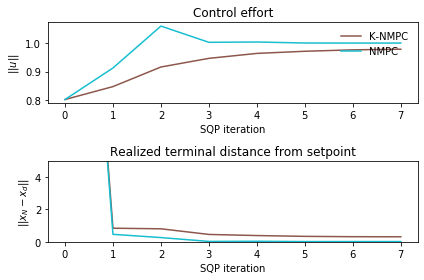

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       8               0.144868              0.108656        1.15894
Koopman bilinear MPC               16               1.4716                1.3996         23.5456


In [22]:
plt.figure(figsize=(6,4))
#plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], color=colors[2], label='K-NMPC')
plt.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], color=colors[3], label='NMPC')
plt.title('Control effort')
plt.ylabel('$||u||$')
plt.legend(loc='upper right', frameon=False)
plt.xlabel('SQP iteration')

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), iter_norm_dist_bedmd[:n_iter], color=colors[2], label=labels[2])
plt.plot(np.arange(n_iter), iter_norm_dist_nmpc[:n_iter], color=colors[3], label=labels[3])
plt.ylim(0,5)
plt.title('Realized terminal distance from setpoint')
plt.ylabel('$||x_N - x_d||$')
plt.xlabel('SQP iteration')

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_sqp_iterations.pdf', format='pdf', dpi=2400)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [50]:
from koopman_core.controllers import PerturbedController

Q_mpc_cl = 5e2*np.diag([1, 1, 1, 2e-1, 2e-1, 2e-1])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 1.
N_cl = int(traj_duration/dt)
t_eval_cl=np.arange(300)*dt

# Solver settings closed loop:
polish_osqp = False
max_iter_osqp = 10
linsys_solver_osqp = 'qdldl'
warm_start_osqp = True

controller_dmd_cl = MPCController(sys_dmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_dmd_cl = PerturbedController(sys_dmd,controller_dmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_edmd_cl = MPCController(sys_edmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_edmd_cl = PerturbedController(sys_edmd,controller_edmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_bedmd_cl = BilinearMPCController(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)
controller_bedmd_cl.nom_controller.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

controller_nmpc_cl = NonlinearMPCController(quadrotor_d, N_cl, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

#### Simulate designed trajectories closed-loop

In [51]:
xs_dmd_cl, us_dmd_cl = quadrotor.simulate(x0_cl, controller_dmd_cl, t_eval_cl)
xs_dmd_cl, us_dmd_cl = xs_dmd_cl.T, us_dmd_cl.T

xs_edmd_cl, us_edmd_cl = quadrotor.simulate(x0_cl, controller_edmd_cl, t_eval_cl)
xs_edmd_cl, us_edmd_cl = xs_edmd_cl.T, us_edmd_cl.T

controller_bedmd_cl.comp_time = []
xs_bedmd_cl, us_bedmd_cl = quadrotor.simulate(x0_cl, controller_bedmd_cl, t_eval_cl)
xs_bedmd_cl, us_bedmd_cl = xs_bedmd_cl.T, us_bedmd_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = quadrotor.simulate(x0_cl, controller_nmpc_cl, t_eval_cl)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

[ 1.53320132e-08  1.02971989e-04 -1.55006607e-04  6.13280527e-06
  2.05943975e-02 -3.10013213e-02]
[ 2.46804838e-07  4.18000372e-04 -6.17580763e-04  4.94068346e-05
  4.24112757e-02 -6.15135100e-02]
[ 1.25848996e-06  9.62515392e-04 -1.38075291e-03  1.68470975e-04
  6.64917131e-02 -9.11209202e-02]
[ 4.00477303e-06  1.75829279e-03 -2.43581640e-03  4.02638114e-04
  9.26637243e-02 -1.19891777e-01]
[ 9.83588842e-06  2.82572598e-03 -3.77461467e-03  7.91757543e-04
  1.20822827e-01 -1.47867877e-01]
[ 2.05025857e-05  4.18424318e-03 -5.38937549e-03  1.37607256e-03
  1.50880456e-01 -1.75084288e-01]
[ 3.81594071e-05  5.85242391e-03 -7.27266321e-03  2.19608844e-03
  1.82755432e-01 -2.01573255e-01]
[ 6.53665284e-05  7.84803720e-03 -9.41736377e-03  3.29241609e-03
  2.16366834e-01 -2.27366859e-01]
[ 1.05091010e-04  1.01881297e-02 -1.18166488e-02  4.70581797e-03
  2.51651094e-01 -2.52490147e-01]
[ 1.60707681e-04  1.28891347e-02 -1.44639309e-02  6.47707934e-03
  2.88549125e-01 -2.76966270e-01]
[ 2.359991

[0.86112497 0.46960146 0.05102107 0.92205783 0.0682285  0.16352041]
[0.87032062 0.47027608 0.05263649 0.91704809 0.06669511 0.15956458]
[0.8794654  0.47093553 0.05421224 0.91188222 0.06519206 0.15558482]
[0.88855776 0.47158009 0.05574808 0.90656398 0.06371894 0.15158379]
[0.89759618 0.47221007 0.05724382 0.90109715 0.06227531 0.14756413]
[0.90657921 0.47282575 0.05869928 0.89548553 0.06086078 0.14352847]
[0.91550542 0.47342744 0.06011432 0.88973295 0.05947494 0.13947939]
[0.92437341 0.47401541 0.06148882 0.88384327 0.0581174  0.13541948]
[0.93318184 0.47458994 0.06282267 0.87782035 0.05678778 0.13135126]
[0.94192939 0.47515132 0.06411581 0.87166806 0.05548569 0.12727726]
[0.95061478 0.4756998  0.0653682  0.86539031 0.05421077 0.12319996]
[0.95923678 0.47623568 0.06657981 0.85899099 0.05296265 0.11912178]
[0.9677942  0.4767592  0.06775064 0.852474   0.05174096 0.11504515]
[0.97628588 0.47727064 0.06888073 0.84584326 0.05054535 0.11097242]
[0.9847107  0.47777025 0.06997012 0.83910268 0.0

[ 1.47545235  0.50026888  0.01727955  0.04077334  0.00467079 -0.05270686]
[ 1.19205058e-08  2.48561184e-04 -9.67755262e-05  4.76820233e-06
  4.97122367e-02 -1.93551052e-02]
[ 1.88330636e-07  9.75715284e-04 -3.94513881e-04  3.76648213e-05
  9.57185815e-02 -4.01925656e-02]
[ 9.50111488e-07  2.14655259e-03 -9.07178897e-04  1.26724476e-04
  1.38448872e-01 -6.23404377e-02]
[ 3.00031390e-06  3.73075712e-03 -1.64689676e-03  3.00334836e-04
  1.78392014e-01 -8.56031359e-02]
[ 7.32840314e-06  5.70269350e-03 -2.62392111e-03  5.87380567e-04
  2.15995214e-01 -1.09801732e-01]
[ 1.52156874e-05  8.04090841e-03 -3.84683210e-03  1.01733751e-03
  2.51647681e-01 -1.34780466e-01]
[ 2.82416595e-05  1.07275941e-02 -5.32275072e-03  1.62036196e-03
  2.85689307e-01 -1.60403260e-01]
[ 4.82922866e-05  1.37483210e-02 -7.05744523e-03  2.42759904e-03
  3.18455850e-01 -1.86535640e-01]
[ 7.75697235e-05  1.70917926e-02 -9.05542850e-03  3.47113876e-03
  3.50238112e-01 -2.13061015e-01]
[ 1.18602346e-04  2.07494694e-02 -1

[0.64703603 0.44037019 0.0507436  1.05664162 0.12509944 0.31610863]
[0.65757748 0.44161224 0.05383062 1.05160017 0.12330721 0.30129459]
[0.66806706 0.44283627 0.05677176 1.04626871 0.12149573 0.28693322]
[0.67850194 0.44404208 0.05957156 1.04066117 0.11966419 0.2730283 ]
[0.68887941 0.44522948 0.0622346  1.03479101 0.11781249 0.25957851]
[0.69919693 0.44639826 0.06476538 1.02867121 0.11594128 0.24657791]
[0.70945205 0.44754824 0.06716835 1.02231426 0.11405194 0.23401636]
[0.71964246 0.44867924 0.06944783 1.01573217 0.11214664 0.22188   ]
[0.72976598 0.44979113 0.07160799 1.00893646 0.11022833 0.2101516 ]
[0.73982052 0.45088379 0.0736528  1.00193819 0.10830085 0.1988111 ]
[0.7498041  0.45195715 0.07558604 0.99474796 0.10636891 0.18783604]
[0.75971487 0.45301119 0.07741125 0.98737597 0.10443726 0.17720562]
[0.76955105 0.45404594 0.0791318  0.97983217 0.10250964 0.16690409]
[0.77931097 0.45506144 0.08075091 0.97212622 0.10058914 0.1569188 ]
[0.78899306 0.45605779 0.0822717  0.96426752 0.0

[ 1.34826153  0.49657438  0.03551903  0.20727822  0.00963014 -0.07036828]
[ 1.35031703  0.49666964  0.03482007  0.20383406  0.00942218 -0.06942295]
[ 1.35233844  0.49676284  0.03413061  0.20045779  0.00921851 -0.0684697 ]
[ 1.35432641  0.49685402  0.03345072  0.19714849  0.00901906 -0.06750931]
[ 1.35628163  0.49694324  0.03278046  0.19390521  0.0088237  -0.06654251]
[ 1.35820473  0.49703052  0.03211989  0.19072702  0.00863235 -0.06557006]
[ 1.36009638  0.4971159   0.03146908  0.18761297  0.00844491 -0.06459265]
[ 1.3619572   0.49719943  0.03082806  0.18456211  0.0082613  -0.063611  ]
[ 1.36378783  0.49728114  0.03019688  0.18157348  0.00808143 -0.06262578]
[ 1.36558888  0.49736107  0.02957556  0.17864611  0.00790521 -0.06163768]
[ 1.36736095  0.49743926  0.02896414  0.17577906  0.00773256 -0.06064733]
[ 1.36910466  0.49751574  0.02836262  0.17297134  0.0075634  -0.05965537]
[ 1.37082058  0.49759054  0.02777103  0.170222    0.00739766 -0.05866244]
[ 1.37250929  0.49766371  0.02718938  

[ 0.05752568  0.18849069 -0.16418838  0.40722154  0.76202989 -0.19028505]
[ 0.06168246  0.19612895 -0.16600116  0.42416549  0.76561796 -0.17227039]
[ 0.06600877  0.20379813 -0.16763411  0.44112219  0.76821225 -0.15431934]
[ 0.07050461  0.2114883  -0.16908798  0.45807079  0.76981845 -0.13645506]
[ 0.07516981  0.21918963 -0.17036377  0.47499118  0.77044303 -0.11870314]
[ 0.080004    0.22689232 -0.17146274  0.49186409  0.77009341 -0.10109116]
[ 0.0850066   0.2345867  -0.17238644  0.50867126  0.76877893 -0.08364776]
[ 0.09017688  0.24226316 -0.17313669  0.52539561  0.76651175 -0.0664021 ]
[ 0.09551392  0.24991228 -0.17371559  0.54202194  0.76331055 -0.04937956]
[ 0.10101669  0.25752488 -0.17412533  0.55853825  0.75920808 -0.03256735]
[ 0.10668401  0.26509204 -0.17436782  0.57493065  0.75422236 -0.01593042]
[ 1.12514611e-01  2.72605116e-01 -1.74444749e-01  5.91189767e-01
  7.48393339e-01  5.43940597e-04]
[ 0.11850711  0.28005597 -0.17435785  0.60730969  0.74177713  0.01683686]
[ 0.1246601  

[1.15545106 0.49378974 0.11099903 0.8122386  0.0103534  0.07423403]
[1.16351815 0.49389779 0.11170939 0.80116785 0.01125659 0.06783799]
[1.17147421 0.4940147  0.11235617 0.79003329 0.0121224  0.06151767]
[1.17931863 0.49414006 0.11294014 0.77884154 0.01294862 0.05527596]
[1.18705088 0.49427347 0.1134621  0.7675991  0.01373336 0.04911595]
[1.19467048 0.49441452 0.11392288 0.75631237 0.01447495 0.04304066]
[1.20217701 0.49456276 0.11432335 0.74498765 0.01517198 0.03705284]
[1.20957013 0.49471773 0.11466439 0.73363107 0.01582328 0.03115506]
[1.21684955 0.49487899 0.11494691 0.72224869 0.01642793 0.02534976]
[1.22401505 0.49504606 0.11517186 0.7108464  0.01698522 0.01963928]
[1.23106644 0.49521846 0.11534018 0.69943001 0.01749464 0.01402592]
[1.23800363 0.49539572 0.11545287 0.68800518 0.01795586 0.00851184]
[1.24482655 0.49557734 0.11551092 0.67657743 0.01836875 0.00309913]
[ 1.25153519  0.49576285  0.11551537  0.66515217  0.01873337 -0.00221029]
[ 1.25812962  0.49595177  0.11546724  0.65

[ 1.48057915  0.50027174  0.02121862 -0.02523142 -0.00623929 -0.0819628 ]
[ 1.48031655  0.5002097   0.02040504 -0.02727472 -0.00616889 -0.08075403]
[ 1.48003392  0.50014839  0.01960357 -0.02923884 -0.00609214 -0.07953971]
[ 1.47973204  0.50008788  0.01881427 -0.03112496 -0.00600934 -0.07832004]
[ 1.47941168  0.50002823  0.01803719 -0.03293426 -0.00592079 -0.07709521]
[ 1.4790736   0.49996949  0.01727239 -0.03466793 -0.00582678 -0.07586546]
[ 1.47871857  0.49991172  0.01651991 -0.03632718 -0.00572762 -0.07463103]
[ 1.4783473   0.49985492  0.01577964 -0.03791305 -0.00563201 -0.07342186]
[ 1.47796055  0.49979901  0.01505106 -0.03942661 -0.00554908 -0.0722951 ]
[ 1.47755901  0.49974387  0.01433304 -0.04086894 -0.00547939 -0.07130843]
[ 1.4771434   0.49968938  0.01362388 -0.04224111 -0.00541798 -0.07052436]
[ 1.47671442  0.49963552  0.01292115 -0.04354403 -0.00535431 -0.07002128]
[ 1.47627275  0.4995824   0.01222147 -0.04477839 -0.00526978 -0.06991491]
[ 1.47581908  0.49953041  0.0115199  -

[ 0.3881961   0.47097274 -0.07344131  0.9523683   0.26864514  0.35918875]
[ 0.39775006  0.47358705 -0.06984777  0.95837351  0.2542208   0.35951919]
[ 0.40736269  0.47605901 -0.06625292  0.96410226  0.24017488  0.35945068]
[ 0.41703122  0.4783925  -0.0626607   0.96955324  0.22652619  0.35899431]
[ 0.42675286  0.48059158 -0.05907492  0.97472517  0.21329206  0.35816185]
[ 0.43652483  0.48266047 -0.05549928  0.9796168   0.20048811  0.35696564]
[ 0.4463443   0.48460354 -0.05193736  0.98422695  0.18812851  0.3554186 ]
[ 0.45620846  0.48642529 -0.0483926   0.98855454  0.1762259   0.35353425]
[ 0.46611448  0.48813037 -0.04486829  0.99259855  0.16479125  0.35132671]
[ 0.47605952  0.48972349 -0.0413676   0.99635813  0.15383426  0.34881075]
[ 0.48604073  0.49120946 -0.03789354  0.99983253  0.14336336  0.3460017 ]
[ 0.49605525  0.4925932  -0.03444896  1.00302118  0.13338527  0.34291539]
[ 0.50610023  0.49387966 -0.03103654  1.00592375  0.12390906  0.33956827]
[ 0.5161728   0.49507396 -0.02765882  

[ 1.30123429  0.51073153  0.07883994  0.43159415  0.0074071  -0.06437799]
[ 1.3055116   0.51080537  0.07818808  0.4238795   0.00736171 -0.06599342]
[ 1.3097121   0.51087871  0.0775204   0.41623063  0.0073075  -0.06754234]
[ 1.31383644  0.51095147  0.07683756  0.40864903  0.00724491 -0.06902533]
[ 1.31788531  0.51102356  0.07614022  0.40113609  0.00717438 -0.07044298]
[ 1.3218594   0.51109491  0.07542903  0.39369316  0.00709634 -0.07179592]
[ 1.32575941  0.51116544  0.07470462  0.38632154  0.00701126 -0.0730848 ]
[ 1.32958607  0.51123509  0.07396765  0.37902243  0.00691958 -0.0743103 ]
[ 1.33334011  0.51130379  0.07321873  0.37179699  0.00682175 -0.07547311]
[ 1.33702226  0.51137149  0.0724585   0.36464633  0.00671822 -0.07657394]
[ 1.34063329  0.51143812  0.07168756  0.35757146  0.00660943 -0.07761355]
[ 1.34417395  0.51150364  0.07090653  0.35057338  0.00649583 -0.07859268]
[ 1.34764502  0.51156801  0.070116    0.343653    0.00637785 -0.07951212]
[ 1.35104727  0.51163117  0.06931658  

#### Plot/analyze the results

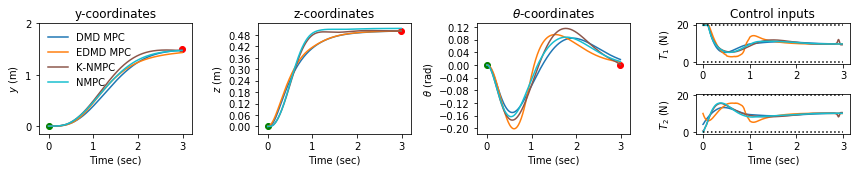

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


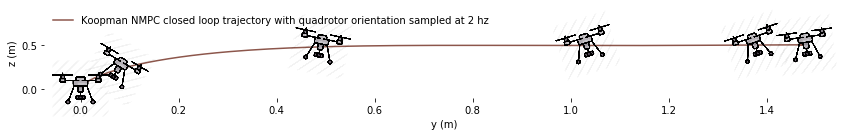

Solution statistics:

                                    Normalized cost,    Mean comp. time (secs)    std comp. time (secs)
                                 realized trajectory
-----------------------------  ---------------------  ------------------------  -----------------------
DMD MPC                                       1.0275                0.00102491              0.000228935
EDMD MPC                                      1.0244                0.0105799               0.00522557
bEDMD MPC                                     0.9916                0.0202558               0.00985884
NMPC (benchmark, known model)                 1                     0.0161916               0.00223548


In [72]:
plot_inds = [0, 1, 2, 0, 1]
subplot_inds = [1, 2, 3, 4, 8]

plt.figure(figsize=(12,2.5))
for ii in range(5):
    ind = plot_inds[ii]
    if ii < 3:
        ax = plt.subplot(1,4,subplot_inds[ii])
        plt.plot(t_eval_cl, xs_dmd_cl[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval_cl, xs_edmd_cl[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl, xs_bedmd_cl[ind, :], colors[2], label='K-NMPC')
        plt.plot(t_eval_cl, xs_nmpc_cl[ind,:], colors[3], label='NMPC')

        plt.scatter(t_eval_cl[0], x0_cl[ind], color='g')
        plt.scatter(t_eval_cl[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(titles[subplot_inds[ii]-1])
        plt.xlabel('Time (sec)')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
            plt.ylim(-0.15,2)
    else:
        bx = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval_cl[:-1],us_dmd_cl[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval_cl[:-1], us_edmd_cl[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl[:-1], us_bedmd_cl[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval_cl[:-1],us_nmpc_cl[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval_cl[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval_cl[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii+3])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii] == 4:
            plt.title('Control inputs')
        else:
            plt.xlabel('Time (sec)')
if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop.pdf', format='pdf', dpi=2400)
plt.show()
    
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import ndimage

draw_inds = np.arange(0,t_eval_cl.size)[::50]

plt.figure(figsize=(12,2))
ax = plt.subplot(1,1,1, frameon=False)
plt.plot(xs_bedmd_cl[0,:], xs_bedmd_cl[1,:], color=colors[2], label='Koopman NMPC closed loop trajectory with quadrotor orientation sampled at 2 hz')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.ylim(-0.1, xs_bedmd[1,-1]+0.45)
plt.legend(loc='upper left',frameon=False)
for ii in draw_inds:
    im_quad = read_png('quad_figure.png')
    im_quad = ndimage.rotate(im_quad, xs_bedmd_cl[2,ii]*180)
    imagebox_quad = OffsetImage(im_quad, zoom=.11)
    ab = AnnotationBbox(imagebox_quad, [xs_bedmd_cl[0,ii], xs_bedmd_cl[1,ii]], frameon=False)
    ax.add_artist(ab)

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop_2.pdf', format='pdf', dpi=2400)
plt.show()

cost_cl_dmd = np.sum(np.diag((xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_dmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_dmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_dmd_cl.T@R_mpc_cl@us_dmd_cl))
cost_cl_edmd = np.sum(np.diag((xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_edmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_edmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_edmd_cl.T@R_mpc_cl@us_edmd_cl))
cost_cl_bedmd = np.sum(np.diag((xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_bedmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_bedmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_cl.T@R_mpc_cl@us_bedmd_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_nmpc_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_cl.T@R_mpc_cl@us_nmpc_cl))

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_cl_dmd/cost_cl_nmpc), np.mean(controller_dmd_cl.nom_controller.comp_time), np.std(controller_dmd_cl.nom_controller.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_cl_edmd/cost_cl_nmpc),np.mean(controller_edmd_cl.nom_controller.comp_time), np.std(controller_edmd_cl.nom_controller.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_cl_bedmd/cost_cl_nmpc), np.mean(controller_bedmd_cl.nom_controller.comp_time), np.std(controller_bedmd_cl.nom_controller.comp_time)],
                ['NMPC (benchmark, known model)',1, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]], 
               headers=['Normalized cost,\nrealized trajectory', 'Mean comp. time (secs)', 'std comp. time (secs)']))